## Master ML Pipeline

### Imports


In [1]:
# Loading the key packages
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sklearn
import hyperopt
from hyperopt import hp
import imblearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import sklearn.calibration as cal
import xgboost as xgb
import sklearn.utils.class_weight as wt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from pathlib import Path
from sklearn import datasets, metrics, model_selection, svm
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
%matplotlib inline
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVC
from sklearn.svm import LinearSVR
from sklearn.dummy import DummyClassifier
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import multiprocessing



In [2]:
from tensorflow.keras import models, layers, utils, backend as K, callbacks
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
#tensorflow.compat.v1.disable_v2_behavior() 
import random
import os

import warnings
#warnings.filterwarnings('ignore')


from numpy.ma import MaskedArray
import sklearn.utils.fixes

import miceforest as mf

sklearn.utils.fixes.MaskedArray = MaskedArray

tf.config.run_functions_eagerly(True)

2025-01-17 12:30:38.706087: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import logging

# Configure the logging module
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [4]:
np.__version__

'1.23.5'

In [5]:
## Rays and tune imports
from tune_sklearn import TuneSearchCV

2025-01-17 12:30:44,197	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-17 12:30:44,440	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [6]:
#### USING PYTHON 3.11.0
print(sklearn.__version__)
print(shap.__version__)
print(tf.__version__)
print(pd.__version__)
print(np.__version__)
print(xgb.__version__)
print(tf.executing_eagerly())

'''
Should be: 
1.5.2
0.46.0
2.16.2
2.2.2
1.26.4
True
'''

'''
SHOUD BE THE FOLLOWING WITH 3.11.0
1.5.2
0.46.0
2.16.2
2.2.3
1.23.5
2.1.1
True
'''

1.5.2
0.46.0
2.16.2
2.2.3
1.23.5
2.1.1
True


'\nSHOUD BE THE FOLLOWING WITH 3.11.0\n1.5.2\n0.46.0\n2.16.2\n2.2.3\n1.23.5\n2.1.1\nTrue\n'

### Setup

In [7]:
# %% Initializing dataframes to store the results


all_results = []


# hyperparam_results = pd.DataFrame(
#     {
#         "Procedure": [],
#         "Outcome": [],
#         "Features": [],
#         "Model": [],
#         "Rep": [],
#         "Hyp_Name": [],
#         "Hyp_Value": []
#     }
# )



feature_results = []

auc_plot_results = []


# Areas which below pipeline will iterate through -- CHANGE THIS BASED ON NEED


#binary_outcomes = np.array(["readmission_binary", "major_med_comp", "extended_los", "returnor", "wnd_related_comp"])
#binary_outcomes = np.array(["readmission_binary"])
#binary_outcomes = np.array(["returnor", "any_med_comp_no_wnd", "any_med_comp_wnd", "any_comp_overall"])
binary_outcomes = ["High_Health_Utilizer"]

#continuous_outcomes = np.array(["outpatient_resource_sum", "los_days"])
#continuous_outcomes = np.array(['los_days'])

continuous_outcomes = []


outcomes = binary_outcomes + continuous_outcomes

#procedures = ["Microdisc", "Foraminotomy", "Laminectomy", "AXDLIF", "PLF", "PTLIF"]
procedures = ["Fusion", "Decompression"]


#features = ["Spine_Institution", "Spine_NSQIP", "Peripheral_NSQIP"]
#features = ["Spine_Institution"]
#features = ["Peripheral_NSQIP"]
#features = ["PLS_features"]
features = ["Health_Util_Features"]
feature = features[0]

model_set = ["RF", "ENet", "XGBoost", "NN", "ASA", "Dummy"]
#model_set = ["RF"]

#model_set = ["XGBoost"]
#model_set = ["Dummy"]



repetitions = list(range(10)) #TODO: Change to range(10)
date = "01_14_25"
impute_iterations = 2 #TODO CHANGE TO 2
tunesearch_iterations = 10 #TODO: Switch to 10
Get_shaps = False #TODO: DO I WANT SHAPS?
procedure_of_interest = "Fusion" #TODO: Change procedure-of-interest
pickle_folder_name = "NoLabs" # Change when doing a different pickling #NoLabs
FullDataset_model = "RF"
feature_perturbation_version = "tree_path_dependent" #TODO: For full dataset model RF


# Functions

## Setup


In [8]:
def reset_random_seed(rep):
    
    tf.keras.backend.clear_session()

    os.environ['PYTHONHASHSEED']=str(rep)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''
    tf.random.set_seed(rep)
    np.random.seed(rep)
    random.seed(rep)


In [9]:
def load_data(procedure):
    readdata = pd.read_csv(r"122124_Spine_Reports.csv", sep=',')
    
    if procedure == "Fusion":
        readdata = readdata[
            (readdata['cpt_thoracolumbar_sacro_arthrodesis'] == True) &
            (readdata['cohort_query_lumbar'] == True)
            ]
    elif procedure == "Decompression":
        readdata = readdata[
            (readdata['cpt_thoracolumbar_sacro_arthrodesis'] == False) & 
            (readdata['cohort_query_spinal_decompression'] == True) & 
            (readdata['cohort_query_lumbar'] == True)
        ]


    readdata = readdata.reset_index(drop=True)
    return readdata

In [10]:
def preop_to_binary(input_df):
    df = input_df.copy()
    # Get all columns that start with "preop_med_"
    preop_med_cols = [col for col in df.columns if col.startswith('preop_med_')]
    print(f"There are {len(preop_med_cols)} preop columns")

    # Check for missing values first
    missing_values = {col: df[col].isna().sum() 
                    for col in preop_med_cols 
                    if df[col].isna().any()}

    if missing_values:
        raise ValueError(f"Missing values found in the following columns: {missing_values}")

    # Convert to boolean if no missing values found
    for col in preop_med_cols:
        # Store original values for verification
        original_values = df[col].value_counts()
        
        # Convert: 0 -> False, >=1 -> True
        df[col] = df[col] > 0
        
        # Print verification of the conversion
        print(f"\nColumn: {col}")
        print("Original value counts:")
        print(original_values)
        print("New value counts:")
        print(df[col].value_counts())
    return df

In [11]:
def add_columns_remove_rows(input_df):

    df = input_df.copy()
    # Recode categorical columns
        # anesthesia_type
    df['anesthesia_type_General'] = df['anesthesia_type'].apply(
        lambda x: 1 if pd.notna(x) and str(x).upper() == 'GENERAL'
                  else (0 if pd.notna(x)  # if it's not NaN and not 'GENERAL', return 0
                        else np.nan)  # if it's NaN, return np.nan
    )
    df['anesthesia_type_General'] = df['anesthesia_type_General'].astype('Int64')
    
    #procedure_setting
    df['procedure_setting_Inpatient'] = df['procedure_setting'].apply(lambda x: 1 if str(x).upper() == 'INPATIENT' 
                                            else (0 if str(x).upper() == 'OUTPATIENT' 
                                            else np.nan))
    df['procedure_setting_Inpatient'] = df['procedure_setting_Inpatient'].astype('Int64')
    # Recode gender into new binary column
    df['gender_female'] = df['gender'].apply(lambda x: 1 if str(x).upper() == 'F' 
                                           else (0 if str(x).upper() == 'M' 
                                           else np.nan))
    df['gender_female'] = df['gender_female'].astype('Int64')

    # add allograft and autograft columns
    df['cpt_allograft'] = df['procedure_codes'].str.contains('20930|20931').astype(bool)
    df['cpt_autograft'] = df['procedure_codes'].str.contains('20936|20937|20938').astype(bool)

    # Anterior approach codes
    df['cpt_anterior_approach'] = df['procedure_codes'].str.contains(
        '22556|22558|22586|22808|22810|22812'
    ).astype(bool)

    # Lateral approach codes
    df['cpt_lateral_approach'] = df['procedure_codes'].str.contains(
        '22533|22534'
    ).astype(bool)

    # Posterior approach codes
    df['cpt_posterior_approach'] = df['procedure_codes'].str.contains(
        '22610|22612|22800|22802|22804|22630|22632|22633|22634|27279|27280'
    ).astype(bool)

    # Convert surgery_start_datetime to datetime type if it isn't already
    df['surgery_start_datetime_date'] = pd.to_datetime(df['surgery_start_datetime'])
    df['surgery_end_datetime_date'] = pd.to_datetime(df['surgery_end_datetime'])
    df['patient_in_or_datetime_date'] = pd.to_datetime(df['patient_in_or_datetime'])
    df['patient_out_or_datetime_date'] = pd.to_datetime(df['patient_out_or_datetime'])
    df['anesthesia_start_datetime_date'] = pd.to_datetime(df['anesthesia_start_datetime'])
    df['anesthesia_stop_datetime_date'] = pd.to_datetime(df['anesthesia_stop_datetime'])
    
    # Create date filters
    start_date = pd.to_datetime('2003-01-01')
    end_date = pd.to_datetime('2022-10-01')
    
    df = df[
        # Date conditions
        (df['surgery_start_datetime_date'] >= start_date) & 
        (df['surgery_start_datetime_date'] < end_date) &
        # Age filter - exclude patients under 18
        (df['age_at_procedure'] >= 18) &
        # Previous conditions (negated)
        ~(df['spine_preop_tumor'] | 
          df['spine_preop_trauma'] | 
          df['spine_preop_infection'] |
          df['cpt_tumor'] |
          df['cpt_trauma'] | 
          df['spine_preop_curvature'] |
          df['cpt_deformity']|
          df['cpt_infection'])
    ]



    # Remove neg los patient 1338489,"2012-05-02 09:43:00"
    df = df[~((df['ir_id'] == 1338489) & 
                   (df['surgery_start_datetime'] == "2012-05-02 09:43:00"))]

    df = df.reset_index(drop=True)


    ### Clean BMI: Make NA for >100 and =0
    df.loc[(df['BMI'] > 100) | (df['BMI'] == 0), 'BMI'] = np.nan

    ### Clean Anesthesia: Make NA for >=20
    df.loc[df['anesthesia_duration_hours'] >= 20, 'anesthesia_duration_hours'] = np.nan


    # Make columns in hours and minutes for surgery length
    # Calculate lengths
    df['OR_length_hours'] = ((df['patient_out_or_datetime_date'] - 
                                df['patient_in_or_datetime_date']).dt.total_seconds() / 3600).round()
    df['OR_length_minutes'] = ((df['patient_out_or_datetime_date'] - 
                                    df['patient_in_or_datetime_date']).dt.total_seconds() / 60).round()

    df['anesthesia_length_hours'] = ((df['anesthesia_stop_datetime_date'] - 
                                    df['anesthesia_start_datetime_date']).dt.total_seconds() / 3600).round()
    df['anesthesia_length_minutes'] = ((df['anesthesia_stop_datetime_date'] - 
                                        df['anesthesia_start_datetime_date']).dt.total_seconds() / 60).round()
    
    df['surgery_length_hours'] = ((df['surgery_end_datetime_date'] -
                                    df['surgery_start_datetime_date']).dt.total_seconds() / 3600).round()
    df['surgery_length_minutes'] = ((df['surgery_end_datetime_date'] -
                                    df['surgery_start_datetime_date']).dt.total_seconds() / 60).round()

    # Handle missing values
    OR_missing = df['patient_in_or_datetime_date'].isna() | df['patient_out_or_datetime_date'].isna()
    anesthesia_missing = df['anesthesia_start_datetime_date'].isna() | df['anesthesia_stop_datetime_date'].isna()
    surgery_missing = df['surgery_start_datetime_date'].isna() | df['surgery_end_datetime_date'].isna()

    df.loc[OR_missing, ['OR_length_hours', 'OR_length_minutes']] = np.nan
    df.loc[anesthesia_missing, ['anesthesia_length_hours', 'anesthesia_length_minutes']] = np.nan
    df.loc[surgery_missing, ['surgery_length_hours', 'surgery_length_minutes']] = np.nan

    # Convert to integer type (while preserving NaN values)
    length_columns = ['OR_length_hours', 'OR_length_minutes',
                    'anesthesia_length_hours', 'anesthesia_length_minutes',
                    'surgery_length_hours', 'surgery_length_minutes']
    df[length_columns] = df[length_columns].astype('Int64')  # Int64 allows for NaN values

     ### Clean Anesthesia: Make NA for >=20
    df.loc[df['anesthesia_length_hours'] >= 20, 'anesthesia_length_hours'] = np.nan
    df.loc[df['anesthesia_length_minutes'] >= 20*60, 'anesthesia_length_minutes'] = np.nan

    ### clean surgery: make NA for > 1000 hours or eqivalent minutes
    df.loc[df['surgery_length_hours'] >= 20, 'surgery_length_hours'] = np.nan
    df.loc[df['surgery_length_minutes'] >= 20*60, 'surgery_length_minutes'] = np.nan



    return df
    
    

In [12]:
def remove_labs_90(df):

    input_df = df.copy()

    # Create columns lists for days_before
    CBC_cols = ["CBC_MONOCYTES", "CBC_NEUTROPHILS", "CBC_BASOPHILS", "CBC_PLATELET_COUNT",
                    "CBC_WBC_COUNT", "CBC_HEMOGLOBIN", "CBC_RBC_COUNT",
                    "CBC_RDW", "CBC_HEMATOCRIT", "CBC_MCH", "CBC_MCHC",
                    "CBC_ABSOLUTE_LYMPHOCYTES", "CBC_ABSOLUTE_NEUTROPHILS",
                    "CBC_LYMPHOCYTE", "CBC_EOSINOPHILS", "CBC_ABSOLUTE_EOSINOPHILS",
                    "CBC_ABSOLUTE_BASOPHILS", "CBC_ABSOLUTE_MONOCYTES"]
    
    CBC_date_cols = [col + "_days_before_surgery" for col in CBC_cols]
        
    BMP_cols = ["BMP_POTASSIUM", "BMP_CREATININE", "BMP_BUN", "BMP_CALCIUM", "BMP_CHLORIDE", 
                    "BMP_SODIUM", "BMP_CO2", "BMP_GLUCOSE"]
    BMP_date_cols = [col + "_days_before_surgery" for col in BMP_cols]

    lab_cols = CBC_cols + BMP_cols
    lab_days_before = CBC_date_cols + BMP_date_cols
    lab_pairs = [(lab_cols[i], lab_days_before[i]) for i in range(len(lab_cols))]
    print(lab_pairs)

    def extract_days(x):
        if pd.isna(x):
            return np.nan
        # Extract just the number before "days"
        try:
            return float(str(x).split()[0])
        except:
            return np.nan
    # Process each pair of columns
    for lab_col, days_col in lab_pairs:
        # Convert the days strings to numbers
        days = input_df[days_col].apply(extract_days)

        # Create a mask for values > 90 days
        mask = days > 90
        
        # Set the lab values to NaN where mask is True
        input_df[lab_col] = input_df[lab_col].mask(mask)


    return input_df
    

In [13]:
def set_columns(data, outcome, pofI):
    individual_features_shap_full = []
    # Basic demographics = age, sex, race (not present), BMI
    basic_demographics = ["ir_id", "surgery_start_datetime", "age_at_procedure", "gender_female", "BMI"]

    #Med hx: include all of the comorbidities with the elix_ prefix. 
    # Those are based on the Elixhauser comorbidity guidelines and 
    # are the most comprehensive. We broke out several other frailty
    #  tools (CCI, MFI, etc) but these are ultimately duplicative 
    # and not as comprehensive (i.e. don’t worry about including). 
    # I do not believe elixhauser has anything on tobacco. 
    # If ther isn’t, then use validation_fmr_tobacco and 
    # validation_cur_tobacco.

    Medhx = ["elix_aids_hiv", "elix_lymphoma", "elix_paralysis",
            "elix_psychoses", "elix_depression", "elix_drug_abuse", "elix_weight_loss",
            "elix_coagulopathy", "elix_alcohol_abuse", "elix_liver_disease", "elix_renal_failure",
            "elix_hypothyroidism", "elix_valvular_disease", "elix_blood_loss_anemia",
            "elix_deficiency_anemia", "elix_metastatic_cancer", "elix_cardiac_arrhythmia",
            "elix_rheumatoid_arhritis", "elix_diabetes_complicated", "elix_diabetes_uncomplicated", 
            "elix_congestive_heart_failure", "elix_hypertension_complicated", "elix_chronic_pulmonary_disease",
            "elix_solid_tumor_wo_metastasis", "elix_hypertension_uncomplicated", "elix_other_neurological_disorder",
            "elix_peripheral vascular_disorder", "elix_pulmonary_circulation_disorder", "elix_fluid_and_electrolyte_disorders",
            "elix_peptic_ulcer_disease_excluding_bleeding", "validation_cur_tobacco", "validation_fmr_tobacco"]
    
    #Surg hx: look at the shx_ prefix variables and include those

    Surghx = ["shx_cervical_fusion", "shx_cervical_surgery", "shx_thoracolumbar_fusion",
                "shx_thoracolumbar_surgery", "shx_unspecified_spine_fusion", "shx_unspecified_spine_surgery"]
    
    #Spine-specific preop pathology: lumbar stenosis, lumbar spondy, 
    # lumbar disc disorders, lumbar disc herniation (all binary columns)
    SpineSpecific = ["lumbar_stenosis", "lumbar_spondy", "lumbar_disc_disorders",
                        "cervical_disc_diorders", "cervical_stenosis", "cervical_spondy",
                        "cervical_disc_herniation", "lumbar_disc_herniation", "spine_preop_pseudoarthrosis_post_fusion", "spine_preop_post_laminectomy_syndrome"]

    #Medication hx: look for preop_med_ suffix. Also just focus on 90
    #  days preop for this analysis. Exclude anything with _sorg in the
    #  name (that is for a separate validation analysis)

    Medicationhx = ["preop_med_90days_ace_inhibitor", "preop_med_90days_arb", "preop_med_90days_antidepressant",
                "preop_med_90days_beta_2_agonist", "preop_med_90days_beta_blocker", "preop_med_90days_benzodiazepine",
                "preop_med_90days_immunosuppresant", "preop_med_90days_nsaid", "preop_med_90days_opioid", "preop_med_90days_anti_psychotic",
                "preop_med_90days_neuromodulator", "preop_med_90days_biphosphonate", "preop_med_90days_loop_diuretic",
                "preop_med_90days_thiazide_diuretic", "preop_med_90days_cinacalcet", "preop_med_90days_insulin", 
                "preop_med_90days_oral_diabetes", "preop_med_90days_calcium_supplement", "preop_med_90days_vit_d_supplement"]

    #Surgical characteristics: inpatient versus outpatient, type of anesthesia 
    # (should almost always be general, but a few weird ones here and there), 
    # OR duration, anesthesia duration, cpt_multilevel, cpt_grafts, 
    # cpt_instrumentation (tell us more about what was done during the case)

    SurgCharsNumeric = ["asa_class", "OR_length_minutes",
                        "cpt_multilevel", "cpt_instrumentation", 
                        "cohort_query_microdisc", "anesthesia_type_General", "procedure_setting_Inpatient"]
    
    Approaches = ["cpt_anterior_approach", "cpt_lateral_approach", "cpt_posterior_approach"]

    #Add approach columns if Fusion
    if pofI == "Fusion":
        SurgCharsNumeric = SurgCharsNumeric + Approaches

    #SurgCharsCat = ["anesthesia_type", "procedure_setting"]

    # CBC and BMP, all with <50% missing values

    CBC_cols = ["CBC_MONOCYTES", "CBC_NEUTROPHILS", "CBC_BASOPHILS", "CBC_PLATELET_COUNT",
                "CBC_WBC_COUNT", "CBC_HEMOGLOBIN", "CBC_RBC_COUNT",
                "CBC_RDW", "CBC_HEMATOCRIT", "CBC_MCH", "CBC_MCHC",
                "CBC_ABSOLUTE_LYMPHOCYTES", "CBC_ABSOLUTE_NEUTROPHILS",
                "CBC_LYMPHOCYTE", "CBC_EOSINOPHILS", "CBC_ABSOLUTE_EOSINOPHILS",
                "CBC_ABSOLUTE_BASOPHILS", "CBC_ABSOLUTE_MONOCYTES"]
    
    BMP_cols = ["BMP_POTASSIUM", "BMP_CREATININE", "BMP_BUN", "BMP_CALCIUM", "BMP_CHLORIDE", 
                "BMP_SODIUM", "BMP_CO2", "BMP_GLUCOSE"]
    
    
    

    outcome = [outcome]
    ## Set Lab columns
    labCols = BMP_cols + CBC_cols
    if pickle_folder_name == "NoLabs":
        all_columns = basic_demographics + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "Labs":
        all_columns = basic_demographics + BMP_cols + CBC_cols + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "Testing":
        all_columns = basic_demographics + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome
    elif pickle_folder_name == "TestingLabs":
        all_columns = basic_demographics + BMP_cols + CBC_cols + Medhx + Surghx + SpineSpecific + Medicationhx + SurgCharsNumeric + outcome

    df = data[all_columns].copy()

    ## Fix ASA class
    df['asa_class'] = df['asa_class'].replace(0, np.nan)

    
    #df['asa_above_2'] = np.where(df['asa_class'] >= 3, 1, 0)
    

    #dum_cols = ["anesthesia_type", "procedure_setting"]

    numeric_features = ["age_at_procedure", "BMI", "OR_length_minutes"]
    
        # Convert preop columns to boolean
    preop_columns = [col for col in df.columns if col.startswith('preop')]
    print(f"{len(preop_columns)} Preop Columns")

    
    for col in preop_columns:
        trueBefore = sum(df[col] == True)
        df[col] = df[col].astype('boolean')
        # df[col] = df[col].astype('float')
        df[col] = df[col].astype('Int64') # Just convert to Int64
        # df[col] = df[col].fillna(0) #fill na as 0 in binary conversion
        trueAfter = sum(df[col] == True)
        if trueBefore != trueAfter:
            raise ValueError(f"""
            Column {col} has different number of True values after conversion!
            Before: {trueBefore} True values
            After: {trueAfter} True values
            Difference: {trueAfter - trueBefore}
            """)
        else: 
            print("All preop conversions good!")
    

    ## Change these float columns to ints

    to_int_cols = ["age_at_procedure", 'OR_length_minutes']

    for col in to_int_cols:
        df[col] = df[col].astype("Int64")

    
    ## ADD Lab columns to numeric_features
    if pickle_folder_name in ["Labs", "TestingLabs"]:
        numeric_features = numeric_features + labCols
        print("adding lab columns to numeric_features") 
        for col in labCols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            
            # Ensure the column dtype is float
            df[col] = df[col].astype('float')
    
    #Convert "object" columns to categorical (NO CATEGORICAL COLUMNS NOW)
    '''
    objectcols = SurgCharsCat
    for col in objectcols:
        df[col] = df[col].astype('category')
    '''

    # Create ASA df
    df_asa = df[['ir_id', 'surgery_start_datetime', 'asa_class', outcome[0]]].copy()
    df_asa['asa_class'] = df_asa['asa_class'].astype("Int64")

    #remove ASA from df
    df = df.drop('asa_class', axis=1)
    
        
    return df, df_asa, numeric_features, individual_features_shap_full

In [14]:
## Create new dfs for predictors, preds+dummies, and ys

def separate_dfs(df, outcome):
    """
    Separates a dataframe into three separate dataframes: predictors, dummies, and ys.

    Args:
        df (pandas.DataFrame): The input dataframe.
        dum_cols (list): A list of column names that are dummy variables. NO MORE DUM COLUMNS

    Returns:
        tuple: A tuple containing three dataframes: (df_preds, dum_df, y).
    """
    #df = df.dropna().reset_index(drop=True) # drop missing variables
    
    y = df[outcome].values

    df_preds = df.drop(columns = [outcome])

    #dum_df = pd.get_dummies(df_preds, columns= dum_cols)

    return df_preds, y

In [15]:
# Function for feature + outcome combo NOT USED YET
'''
def full_feature_outcome_test(feature, outcome):
   
   Function to do the entire test for a feature + outcome combo
   Inputs: feature (string), outcome (string)
   
   n = len(df)
   label_n = sum(y)
   return 

'''

'\ndef full_feature_outcome_test(feature, outcome):\n   \n   Function to do the entire test for a feature + outcome combo\n   Inputs: feature (string), outcome (string)\n   \n   n = len(df)\n   label_n = sum(y)\n   return \n\n'

## Functions to be repeated



In [16]:
### Formulating the preprocessor for scaling and stratified folds

def scaleAnd_skf(numeric_features, outcome, rep, fulldataset = False):
     # Formulating the preprocessor for scaling
    scaler = preprocessing.RobustScaler()

    if fulldataset:
        preprocessor = ColumnTransformer([('robust', scaler, numeric_features)], remainder = 'passthrough', verbose_feature_names_out=False)
    else:
        preprocessor = ColumnTransformer([('minmax', scaler, numeric_features)], remainder = 'passthrough')

    if outcome in binary_outcomes:
        
        skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = rep) #TODO: Change back to 5

    elif outcome in continuous_outcomes:
        
        print("In Progress")
    
    return preprocessor, skf

### To do within each traintest split

In [17]:
## Save the dtypes for the xtrain_std and x_test_std

def save_dtypes(df, original_df, preprocessor):
    feature_names = preprocessor.get_feature_names_out()
    df = pd.DataFrame(df, columns=feature_names, index=original_df.index)
    df.columns = [col.replace('minmax__', '') for col in df.columns]
    df.columns = [col.replace('remainder__', '') for col in df.columns]
    for col in df.columns:
        if col in original_df.columns:
            #print("Good")
            #print(col)

            #df[col] = df[col].astype(original_df[col].dtype)
            df[col] = df[col].astype('float64')

        else:
            print("ERROR")
            #print(col)
    return df
    

In [18]:
## Any extra missing values filled in using mode/median of same dataset

def post_imputation_cleanup(data):
    total_replaced = 0
    for col in data.columns:
        if data[col].isnull().any():
            nan_count_before = data[col].isnull().sum()
            if data[col].dtype.name == 'category':
                # For categorical data, use mode if it exists
                if not data[col].mode().empty:
                    data[col].fillna(data[col].mode()[0], inplace=True)
            elif data[col].dtype.kind in 'biufc':  # boolean, integer, unsigned integer, float, complex
                # For numeric data, use median if it exists and is not null
                median = data[col].median()
                if pd.notnull(median):
                    data[col].fillna(median, inplace=True)
            else:
                # For other types (like object), use mode if it exists
                if not data[col].mode().empty:
                    data[col].fillna(data[col].mode()[0], inplace=True)
            
            nan_count_after = data[col].isnull().sum()
            replaced = nan_count_before - nan_count_after
            total_replaced += replaced

            print(f"Column '{col}': {replaced} NaN values replaced")

            
            # Check if there are still NaN values after imputation
            if data[col].isnull().any():
                print(f"Warning: Column '{col}' still contains NaN values after imputation.")
    
    return data

In [19]:
def imputeData(x_train, y_train, x_test, y_test, rep, impute_number):
    # Combine x_train and y_train for imputation
    x_train = x_train.reset_index(drop=True)
    x_test = x_test.reset_index(drop=True)

    train_data = x_train.copy()
    train_data['target'] = y_train

    # Create and fit the imputation kernel
    
    kernel = mf.ImputationKernel(
        train_data,
        random_state=rep,
        variable_schema = NaNColumn_list
    )
    
    # Use sklearn pipeline method (as in examples)
    pipe = Pipeline([('impute', kernel)])
    
    # Perform imputation
    #kernel.mice(impute_number, verbose=True)  # Run 5 iterations, adjust as needed
    
    # Get the imputed training data
    #imputed_train = kernel.complete_data()

    imputed_train = pipe.fit_transform(train_data, impute__iterations = impute_number,
                                       impute__verbose=True)
    
    #imputed_train = post_imputation_cleanup(imputed_train)

    assert not np.any(np.isnan(imputed_train))

    # Separate features and target
    x_train_imputed = imputed_train.drop('target', axis=1)
    y_train_imputed = imputed_train['target']

    # Combine Test data
    test_data = x_test.copy()
    #test_data['target'] = y_test
    test_data['target'] = np.nan 
    test_data['target'] = test_data['target'].astype('bool')# add dummy target column
    # Impute test data
    test_imputed = pipe.transform(test_data)
    #test_imputed = kernel.transform(test_data)
    #test_imputed = post_imputation_cleanup(test_imputed)
    x_test_imputed = test_imputed.drop('target', axis=1)

    assert not np.any(np.isnan(x_test_imputed))

    y_test_imputed = y_test

    
    return x_train_imputed, y_train_imputed, x_test_imputed, y_test_imputed


In [20]:
#### Create training, test, validation sets and additional sets
def set_train_test(input_df, y, train_index, test_index, rep, preprocessor, impute_number,
                   want_val = False):
    # Split into train and test

    # NEED TO HAVE DUMMYS HERE AFTER IMPUTATION! do in impute_data

    # dum_df cut out asa_class column
    # x_train_asa = asa_class.iloc[train_index].copy()
    # x_test_asa = asa_class.iloc[test_index].copy()
    # add these two to the output of set_train_test
        
    x_train_split = input_df.iloc[train_index].copy()
    x_test_split = input_df.iloc[test_index].copy()
    y_train_split = y[train_index].copy()
    y_test_split = y[test_index].copy()
    
    
    # Peel off validation set

    x_train_actual_split, x_val_split, y_train_actual_split, y_val_split = train_test_split(x_train_split,
                                                                                            y_train_split, stratify = y_train_split,
                                                                                            test_size = 0.1, random_state = rep) # random process


    # Remove mrn and surgery start datetime and include that as the actual train and test
        
        
    #if feature == mainfeature:
        
    print("Test")

    if want_val:

        x_train_actual = x_train_actual_split.drop(columns = ["ir_id", "surgery_start_datetime"])
        x_val = x_val_split.drop(columns = ["ir_id", "surgery_start_datetime"])
        y_train_actual = y_train_actual_split.copy()
        y_val = y_val_split.copy()

        # IMPUTED VALUES
        x_train_actual, y_train_actual, x_val, y_val = imputeData(x_train_actual, y_train_actual, x_val, y_val, rep, impute_number)
    else:
        x_train_actual = None
        x_val = None
        y_train_actual = None
        y_val = None



    x_train = x_train_split.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_test = x_test_split.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_test_id_cols = x_test_split[["ir_id", "surgery_start_datetime"]]
    x_test_id_cols = x_test_id_cols.reset_index(drop=True)
    y_train = y_train_split.copy()
    y_test = y_test_split.copy()

    #IMPUTED VALUES
    x_train, y_train, x_test, y_test = imputeData(x_train, y_train, x_test, y_test, rep, impute_number)
    
    
    x_train_std = preprocessor.fit_transform(x_train)
    x_train_std = save_dtypes(x_train_std, x_train, preprocessor)
    x_test_std = preprocessor.transform(x_test)
    x_test_std = save_dtypes(x_test_std, x_test, preprocessor)



    # Keep a version that has those values as index columns 

    x_test_features = x_test.copy() #use imputed data
    # Add back the identifier columns
    x_test_features = pd.concat([x_test_id_cols, x_test_features], axis=1)

    x_test_features["Patient_ID"]=  np.arange(len(x_test_features))

    x_test_features_long = pd.melt(x_test_features, id_vars = ["ir_id", "Patient_ID", "surgery_start_datetime"], var_name = "Feature_Name", value_name = "Feature_Actual_Value" )
    
    x_test_features_long['Feature_Actual_Value'] = pd.to_numeric(x_test_features_long['Feature_Actual_Value'])

    x_cols = x_test.columns

    n_features = len(x_cols)
    
    return x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, x_test_features_long, n_features, x_cols, x_train_std, x_test_std

### All the different Models

In [21]:
## ASA model - only works for binary outcomes

def ASA_model(x_train, x_test, y_train, rep):

    '''
    Input: x_train: training data from train-test set
           x_test: test data from train-test set
           y_train: training labels from train-test set
           rep: random state for reproducibility

    Output: cv_model: trained logistic regression model
            y_pred: predicted labels for test set
            y_prob_vec: predicted probabilities for test set
    '''

    # Extract ASA class feature
    trim_train = x_train[["asa_class"]].copy()
    trim_test = x_test[["asa_class"]].copy()

    # Fit logistic regression model
    cv_model = linear_model.LogisticRegression(penalty=None, random_state=rep)
    cv_model.fit(trim_train, y_train)

    # Make predictions
    y_pred = cv_model.predict(trim_test)
    y_prob = cv_model.predict_proba(trim_test)
    y_prob_vec = y_prob[:, 1]

    return cv_model, y_pred, y_prob_vec

In [22]:
## ASA Categorical model -> <=2 and >2
def ASA_categorical_model(x_test):
    
    x_test['asa_above_2'] = np.where(x_test['asa_class'] >= 3, 1, 0)

    trim_test_categorical = x_test["asa_above_2"]


    y_pred = trim_test_categorical.values.reshape(-1,1)
    y_prob = trim_test_categorical.values.reshape(-1,1)
    y_prob_vec = trim_test_categorical.values.reshape(-1,1)
    #print(y_prob_vec)
    return y_pred, y_prob_vec

In [23]:
def ENet_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): column_name of outcome variable
            preprocessor (obj): standardizing preprocessing object
            x_train (df): training data from train-test set
            y_train (df): training outcome variable from train-test set
            x_test (df): test data from train-test set
            x_train_std (df): standardized training data
            x_test_std (df): standardized test data

    Outputs: cv_model (obj): best model from bayesian optimization
             y_pred (arr): predicted values for test set
             y_prob_vec (arr): predicted probability values for test set
             shap_values (arr): shap values for test set
    '''
    if outcome in binary_outcomes:
        '''
        y_train_df = pd.DataFrame(y_train, columns = ["y_train"])
        All_train = pd.concat([x_train, y_train_df], axis = 1)

        kernel = mf.ImputationKernel(
            All_train,
            random_state=rep,
            variable_schema = NaNColumn_list
        )
        '''
        pipe = Pipeline([   #('impute', kernel),
                            ('processing', preprocessor), 
                            ('estimator', linear_model.LogisticRegression(penalty = 'elasticnet', 
                                                                        solver='saga', 
                                                                        class_weight = 'balanced',
                                                                        random_state = rep, 
                                                                        max_iter = 1000
                                                                        ))])

        fit_params = {'impute__iterations': impute_iterations,
                      'impute__verbose': True}
        model_params = {'estimator__C': Real(1e-2, 1e2, prior = 'log-uniform'),
                        'estimator__l1_ratio': Real(0, 1)
                        }
        hyperopt_model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
            'estimator__l1_ratio': hp.uniform('estimator__l1_ratio', 0, 1)
                                 }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = hyperopt_model_params, 
                                search_optimization="hyperopt",
                                verbose = 2,
                                scoring='roc_auc', # auc is most important metric
                                refit=True,
                                cv=5,
                                n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep
                                )

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.predict_proba(x_test)
        y_prob_vec = y_prob[:,1]


    elif outcome in continuous_outcomes:

        print("In Progress")


    if Get_shaps:
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_std)
        shap_values = explainer.shap_values(x_test_std)
        print("SHAPS DONE")
    else:
        shap_values = None
        print("NO SHAPS FOOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [24]:
def XGBoost_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:

        weight_vec = wt.compute_sample_weight(class_weight = "balanced", y = y_train) # compute weights using sklearn
#        eval_weight = wt.compute_sample_weight(class_weight = "balanced", y = y_val)

        pipe = Pipeline([('processing', preprocessor), 
                            ('estimator', xgb.XGBClassifier(#n_estimators = 500,
                                                            #eval_metric = "auc",
                                                            use_label_encoder=False,
                                                            verbosity = 1, random_state = rep
                                                        ))]) 


        es = xgb.callback.EarlyStopping(
            rounds = 10,
            save_best=True,
        )
        print(f"XShape: {x_train.shape}")

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 2, 10),
            'estimator__subsample': hp.uniform('estimator__subsample', 0.5, 1.0),
            'estimator__learning_rate': hp.uniform('estimator__learning_rate', 0.1, 0.5),
            'estimator__colsample_bytree': hp.uniform('estimator__colsample_bytree', 0.5, 1.0),
            'estimator__colsample_bylevel': hp.uniform('estimator__colsample_bylevel', 0.5, 1.0),
            'estimator__min_child_weight': hp.uniformint('estimator__min_child_weight', 1, 10),
            'estimator__gamma': hp.uniform('estimator__gamma', 0, 1.0),
            'estimator__reg_lambda': hp.loguniform('estimator__reg_lambda', np.log(1e-2), np.log(1e2)),
            'estimator__reg_alpha': hp.loguniform('estimator__reg_alpha', np.log(1e-2), np.log(1e2)),
        }

        fit_params = {#'estimator__sample_weight_eval_set': [eval_weight],
#                                          'estimator__eval_set': [(x_val_std, y_val)],
#                                          'estimator__callbacks': [es],
                        'estimator__sample_weight': weight_vec,
#                                          'estimator__early_stopping_rounds': 10

        }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', 
                                refit=True, cv= 5, 
                                n_jobs = 7, random_state = rep, 
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train, **fit_params)



        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.predict_proba(x_test) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        print("In Progress")



    if Get_shaps:
        explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], data=x_train_std, model_output = "probability")
        shap_values = explainer.shap_values(x_test_std)
        print(shap_values.shape)
        test = shap_values[0] # TODO: Check if 0 is correct here if needed
        print(test.shape)
        print("SHAPS DONE")
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values

In [25]:
def RF_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep, n_features_in, Interventional):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:

        pipe = Pipeline([('processing', preprocessor), 
                            ('estimator', BalancedRandomForestClassifier(random_state = rep,
                                                                         sampling_strategy='all',
                                                                         replacement=True,
                                                                         bootstrap=False
                                                                         ))]) 

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_features': hp.uniformint('estimator__max_features', 2, n_features_in),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 1, 25),
            'estimator__min_samples_split': hp.uniformint('estimator__min_samples_split', 2, 10),
            'estimator__min_samples_leaf': hp.uniformint('estimator__min_samples_leaf', 1, 5),
        }

        cv_model = TuneSearchCV(pipe,
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', # AUC is most important metric
                                refit=True, cv=5, n_jobs = 7,
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_test) # generate prediction (0 or 1)
        y_prob = cv_model.predict_proba(x_test) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        print("In Progress")

    if Get_shaps:
        if Interventional:
            print("DOING INTERVENTIONAL")
            explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], data=x_train_std, feature_perturbation= "interventional",
                                       model_output = "probability")
        else:
            print("DOING PATH DEPENDENT")
            explainer = shap.TreeExplainer(cv_model.best_estimator_.named_steps['estimator'], feature_perturbation= "tree_path_dependent")
        shap_values = explainer.shap_values(x_test_std)
        print(shap_values.shape)
        shap_values = shap_values[:, :, 1]
        print(shap_values.shape)
        print("GET SHAPS")
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [26]:
def Dummy_model(outcome, x_train, y_train, x_test):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''
    if outcome in binary_outcomes:

        dummy_clf = DummyClassifier(strategy="prior")
        dummy_clf.fit(x_train, y_train)

        y_pred = dummy_clf.predict(x_test)
        y_prob = dummy_clf.predict_proba(x_test)
        y_prob_vec = y_prob[:,1]

    elif outcome in continuous_outcomes:

        dummy_clf = DummyRegressor(strategy="median")
        dummy_clf.fit(x_train, y_train)

        y_pred = np.round(dummy_clf.predict(x_test))

    return dummy_clf, y_pred, y_prob_vec


In [27]:
def NN_model(outcome, preprocessor, x_train_actual, y_train_actual, x_val, y_val, x_test, n_features, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    #tf.config.run_functions_eagerly(True)

    if outcome in binary_outcomes:

        x_train_actual_std = preprocessor.fit_transform(x_train_actual)
        x_train_actual_std = save_dtypes(x_train_actual_std, x_train_actual, preprocessor)
        x_val_std = preprocessor.transform(x_val)
        x_val_std = save_dtypes(x_val_std, x_val, preprocessor)

#       x_train_std = preprocessor.fit_transform(x_train)
        x_test_std = preprocessor.transform(x_test)
        x_test_std = save_dtypes(x_test_std, x_test, preprocessor)

        reset_random_seed(rep)


        metric_set=[tf.keras.metrics.AUC(name="auc")]



        weight_vec = wt.compute_sample_weight(class_weight = "balanced", y = y_train_actual) # compute weights using sklearn
        eval_weight = wt.compute_sample_weight(class_weight = "balanced", y = y_val)


        # Convert data to TensorFlow datasets
        #train_dataset = tf.data.Dataset.from_tensor_slices((x_train_actual_std, y_train_actual, weight_vec))
        #train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32)

        #val_dataset = tf.data.Dataset.from_tensor_slices((x_val_std, y_val, eval_weight))
        #val_dataset = val_dataset.batch(32)


        nn_model = tf.keras.Sequential(name="DeepNN_CLF", layers=[

            # Input layer is implicitly defined here

            ### hidden layer 1
            tf.keras.layers.Dense(name="h1", input_dim=n_features,
                            units=int(round((n_features+1)/2)), 
                            activation='relu'),

            ### dropout layer 1
            tf.keras.layers.Dropout(name="drop1", rate=0.2, seed = rep),

            ### hidden layer 2
            tf.keras.layers.Dense(name="h2", units=int(round((n_features+1)/4)), 
                            activation='relu'),

            ### dropout layer 2
            tf.keras.layers.Dropout(name="drop2", rate=0.2, seed = rep),

            ### layer output
            tf.keras.layers.Dense(name="output", units=1, activation='sigmoid')
        ])

        nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics = metric_set)

        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_auc', 
            verbose=1,
            patience=10,
            mode='max',
            restore_best_weights=True)

        history = nn_model.fit(
            x_train_actual_std,
            y_train_actual,
            epochs= 100, #TODO: Change back to 100
            sample_weight=weight_vec,
            batch_size=32, #added
            callbacks=[early_stopping],
            validation_data=(x_val_std, y_val, eval_weight),
        )

        y_prob = nn_model.predict(x_test_std) 
        y_pred = (y_prob > 0.5).astype("int32")                 
        y_prob_vec = y_prob.flatten()

        nn_model.summary()

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title('Model AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
        plt.tight_layout()
        plt.show()


    elif outcome in continuous_outcomes:

        print("In Progress")


    # SHAP values calculation
    '''
    tf.config.run_functions_eagerly(False)
    print(tf.executing_eagerly())
    background = shap.sample(x_train_actual_std, 100)  # Use a subset of training data as background
    explainer = shap.DeepExplainer(nn_model, background)
    shap_values = explainer.shap_values(x_test_std.values)
    shap_values = shap_values[:, :, 0]
    print(shap_values.shape)
    tf.config.run_functions_eagerly(True)
    '''
    
    
    #explainer = shap.DeepExplainer(nn_model, data=x_train_actual_std)
    #print(type(x_test_std))
    #shap_values = explainer.shap_values(x_test_std)
    #print(shap_values.shape)

    return nn_model, y_pred, y_prob_vec


In [28]:

def Linear_SVC_model(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            x_train_std (pd.DataFrame): standardized training data
            x_test_std (pd.DataFrame): standardized test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:


        pipe = Pipeline([('processing', preprocessor),
                         ('estimator', sklearn.svm.LinearSVC(random_state=rep,
                                                             dual=False,
                                                             max_iter=1000,
                                                             class_weight='balanced' ))])

        model_params = {
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
        }

        cv_model = TuneSearchCV(pipe, 
                                param_distributions = model_params, 
                                scoring='roc_auc', # auc is most important metric
                                refit=True, 
                                cv=5, n_jobs = 7,
                                n_trials = tunesearch_iterations, 
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2
                                )        
        
        cv_model.fit(x_train, y_train)

        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.decision_function(x_test)
        y_prob_vec = 1 / (1 + np.exp(-y_prob))

    elif outcome in continuous_outcomes:
        print("In Progress")

    if Get_shaps:
        print("GET SHAPS")
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_std)
        shap_values = explainer.shap_values(x_test_std)
    else:
        shap_values = None
        print("NO SHAPS FOR YOU")

    return cv_model, y_pred, y_prob_vec, shap_values


In [29]:
from sklearn.kernel_approximation import Nystroem


def SVC_model_with_kernels(outcome, preprocessor, x_train, y_train, x_test, x_train_std, x_test_std, rep):
    '''
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): training data from train-test set
            y_train (pd.Series): training outcome variable from train-test set
            x_test (pd.DataFrame): test data
            x_train_std (pd.DataFrame): standardized training data
            x_test_std (pd.DataFrame): standardized test data
            rep (int): random state for reproducibility

    Outputs: y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
             cv_model : trained model object
             shap_values: SHAP values for the model
    '''

    if outcome in binary_outcomes:
        pipe = Pipeline([
            ('processing', preprocessor),
            ('nystroem', Nystroem(random_state=rep)),
            ('estimator', LinearSVC(random_state=rep, dual=False, max_iter=1000, class_weight='balanced'))
        ])

        model_params = {
            'nystroem__kernel': hp.choice('nystroem__kernel', ['rbf', 'poly', 'sigmoid']),
            'nystroem__n_components': hp.uniformint('nystroem__n_components', 50, 200),
            'nystroem__gamma': hp.loguniform('nystroem__gamma', np.log(1e-3), np.log(1e1)),
            'nystroem__degree': hp.uniformint('nystroem__degree', 2, 6),  # Integer values from 2 to 5
            'nystroem__coef0': hp.uniform('nystroem__coef0', 0, 1),  # Uniform distribution between 0 and 1
            'estimator__C': hp.loguniform('estimator__C', np.log(1e-2), np.log(1e2)),
        }
        '''
        # Define separate search spaces for each kernel
        linear_params = {}  # No additional parameters for linear kernel
        rbf_params = {
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
        }
        poly_params = {
            'nystroem__degree': Integer(2, 5),
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
            'nystroem__coef0': Real(0, 1),
        }
        sigmoid_params = {
            'nystroem__gamma': Real(1e-3, 1e1, prior='log-uniform'),
            'nystroem__coef0': Real(0, 1),
        }

        # Combine the search spaces based on the kernel
        search_spaces = model_params.copy()
        search_spaces.update(linear_params if 'linear' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(rbf_params if 'rbf' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(poly_params if 'poly' in search_spaces['nystroem__kernel'] else {})
        search_spaces.update(sigmoid_params if 'sigmoid' in search_spaces['nystroem__kernel'] else {})
        '''
        
        cv_model = TuneSearchCV(
            pipe, 
            param_distributions=model_params, 
            scoring='roc_auc',
            refit=True, 
            cv=5,
            n_jobs=7,
            n_trials=tunesearch_iterations,  # Increased due to larger search space
            random_state=rep,
            search_optimization = "hyperopt",
            verbose = 2
        )        
        
        cv_model.fit(x_train, y_train)
        best_params = cv_model.best_params_
        best_kernel = best_params['nystroem__kernel']
        #best_gamma = best_params['nystroem__gamma']
        print(f"Best kernel: {best_kernel}")
        #print(f"Best gamma: {best_gamma}")

        y_pred = cv_model.predict(x_test)
        y_prob = cv_model.decision_function(x_test)
        y_prob_vec = 1 / (1 + np.exp(-y_prob))

    elif outcome in continuous_outcomes:
        print("In Progress")
        return

    # Transform the data using the fitted Nystroem approximation
    nystroem = cv_model.best_estimator_.named_steps['nystroem']
    x_train_nystroem = nystroem.transform(x_train_std)
    x_test_nystroem = nystroem.transform(x_test_std)
    print(type(nystroem.components_))
    print(nystroem.components_.shape)

    if Get_shaps:
        print("GET SHAPS")
        #For SHAP values, we'll use KernelExplainer as LinearExplainer won't work with the kernel approximation
        explainer = shap.LinearExplainer(cv_model.best_estimator_.named_steps['estimator'], x_train_nystroem)
        shap_values = explainer.shap_values(x_test_nystroem)
        print(shap_values.shape)
    else:
        print("NO SHAPS FOR YOU")
        shap_values = None

    return cv_model, y_pred, y_prob_vec, shap_values, best_kernel


In [30]:
print(shap.__version__)

0.46.0


## Function for Results

In [31]:
from datetime import datetime
import math

def log_execution(csv_path, name_of_model, start_time):
    end_time = time.time()
    total_seconds = end_time - start_time
    
    # Calculate minutes and seconds
    minutes = math.floor(total_seconds / 60)  # Get complete minutes
    seconds = round(total_seconds % 60)  # Get remaining seconds, rounded
    
    # Create new row
    new_row = {
        'model_name': name_of_model,
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'execution_time_minutes': minutes,
        'execution_time_seconds': seconds
    }
    
    # Read existing CSV, append new row, and save
    try:
        df = pd.read_csv(csv_path)
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    except FileNotFoundError:
        # If file doesn't exist, create new DataFrame
        df = pd.DataFrame([new_row])
    
    df.to_csv(csv_path, index=False)


In [32]:
def collect_results(results_list, auc_plot_list, outcome, procedure, feature, model_name, rep, i, n, label_n, y_test, y_prob_vec, y_pred):
    """
    Collects and computes performance metrics for binary classification models.

    This function calculates various performance metrics for binary classification models and stores them in a results dataframe.
    It also generates ROC curve data for plotting.

    Parameters:
        results_list (list): List to store performance metric results
        auc_plot_list (list): List to store ROC curve plotting data
        outcome (str): Name of the outcome being predicted
        procedure (str): Name of the procedure being analyzed
        feature (str): Name/description of features used
        model_name (str): Name of the model used
        rep (int): Repetition number
        i (int): Fold number for cross-validation
        n (int): Total number of samples
        label_n (int): Number of labeled samples
        y_test (array-like): True labels
        y_prob_vec (array-like): Predicted probabilities
        y_pred (array-like): Predicted labels

    Returns:
        None - Updates results_list and auc_plot_list in place

    Metrics calculated:
    - AUC (Area Under ROC Curve)
    - Sensitivity/Recall
    - Specificity
    - PPV (Positive Predictive Value)
    - NPV (Negative Predictive Value) 
    - Log Loss
    - Brier Score
    - Weighted F1 Score
    - Accuracy
    - Balanced Accuracy
    - Confusion Matrix

    The function only processes binary classification outcomes (checks if outcome is in binary_outcomes).
    Results are stored in a pandas DataFrame and appended to the input lists.
    """

    if outcome in binary_outcomes:
        # Computing AUC
        fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob_vec, pos_label = 1)
        roc_auc = metrics.auc(fpr, tpr)
        AUC = metrics.auc(fpr, tpr)

        print(f"AUC: {AUC}")
        logging.info(f"AUC, Logging: {AUC}")
        # Sensitivity, Specificity

        recall_score_0 = metrics.recall_score(y_test,y_pred, pos_label=0)
        recall_score_1 = metrics.recall_score(y_test,y_pred, pos_label=1)

        # PPV, NPV
        precision_score_0 = metrics.precision_score(y_test,y_pred, pos_label=0)
        precision_score_1 = metrics.precision_score(y_test,y_pred, pos_label=1)

        # Computing Log Loss
        log_loss = metrics.log_loss(y_test, y_prob_vec, labels = [0,1])

        # Computing Brier score
        brier_loss = metrics.brier_score_loss(y_test, y_prob_vec, pos_label = 1)

        # Computing WF1
        W_F1= metrics.f1_score(y_test, y_pred, average='weighted')

        # Computing Accuracy
        accuracy_score = metrics.accuracy_score(y_test,y_pred)
        B_accuracy_score = metrics.balanced_accuracy_score(y_test,y_pred)


        # Confusion Matrix
        c_mat = metrics.confusion_matrix(y_test, y_pred)

        new_results = pd.DataFrame(
            {
                "Procedure": [procedure],
                "Outcome": [outcome],
                "Features": [feature],
                "Model": [model_name],
                "Rep": [rep],
                "Fold": [i],
                "W_F1": [W_F1],
                "AUC": [AUC],
                "MAE": ["NA"],
                "R2": ["NA"],
                "RMSE": ["NA"],
                "Log-Loss": [log_loss],
                "Brier-Loss": [brier_loss],
                "Accuracy": [accuracy_score],
                "Balanced_Accuracy": [B_accuracy_score],
                "Sensitivity": [recall_score_1],
                "Specificity": [recall_score_0],
                "NPV": [precision_score_0],
                "PPV": [precision_score_1],
                "c_matrix": [c_mat],
                "n":[n],
                "label_n": [label_n]
            }
        )

        auc_plot_results_new = pd.DataFrame(
            {
                "Procedure": np.repeat(procedure, len(fpr)),
                "Outcome": np.repeat(outcome, len(fpr)),
                "Features": np.repeat(feature, len(fpr)),
                "Model": np.repeat(model_name, len(fpr)),
                "Rep": np.repeat(rep, len(fpr)),
                "Fold": np.repeat(i, len(fpr)),
                "FPR": fpr,
                "TPR": tpr,
                "Thresholds": threshold
            }
        )
        #print(len(fpr))
        auc_plot_list.append(auc_plot_results_new)

        results_list.append(new_results)

    return


In [33]:
def collect_shap_results(individual_features_shap_full_list, feature_results_list, shap_values, y_test, x_cols, x_test_features_long, outcome, procedure,
                         feature, model_name, rep, i, svcKernel = False):
    
    '''
    Inputs: individual_features_shap_full: empty shap list

    Outputs: shap_file_results: dataframe of shap values for each patient and feature
    '''
    mod_shap = shap_values.copy()
    #mod_shap = shap_values[0]

    test_length = len(y_test)

    row_vec = list(range(0, test_length))
    shap_features_row = []
    if svcKernel:
        print(x_cols)
    for row in row_vec:

        shap_values_row = mod_shap[row]

        temp_feature_names = list(x_cols) #CHECK here
        



        new_shap_features_row = pd.DataFrame(
            {
                "Patient_ID": np.repeat(row, len(x_cols)),
                "Feature_Name": temp_feature_names,
                "Feature_Value": shap_values_row,
                "Feature_Abs_Value": np.abs(shap_values_row),

            }
        )

        shap_features_row.append(new_shap_features_row)




    shap_features_tabular = pd.concat(shap_features_row)



    individual_features_shap = x_test_features_long.merge(shap_features_tabular, how = "left", on = ["Patient_ID", "Feature_Name"])

    individual_features_shap["Procedure"]=  procedure
    individual_features_shap["Outcome"]=  outcome
    individual_features_shap["Model"]=  model_name
    individual_features_shap["Rep"]=  rep
    individual_features_shap["Fold"]=  i


    individual_features_shap_full_list.append(individual_features_shap)

    summarized_features_shap = shap_features_tabular.groupby(['Feature_Name']).agg(   
        Feature_Mean_Abs = ('Feature_Abs_Value','mean'),
    ).reset_index()


    feature_coef = summarized_features_shap['Feature_Mean_Abs'].values
    feature_names = summarized_features_shap['Feature_Name'].values


    new_features = pd.DataFrame(
        {
            "Procedure": np.repeat(procedure, len(feature_names)),
            "Outcome": np.repeat(outcome, len(feature_names)),
            "Features": np.repeat(feature, len(feature_names)),
            "Model": np.repeat(model_name, len(feature_names)),
            "Rep": np.repeat(rep, len(feature_names)),
            "Fold": np.repeat(i, len(feature_names)),
            "Feature_Name": feature_names,
            "Feature_Mean_Abs_Value": feature_coef,

        }
    )


#                    feature_results = feature_results.append(new_features, ignore_index=True)
    feature_results_list.append(new_features)


    return

In [34]:
#pip install shap==0.41.0 --user
print(shap.__version__)


0.46.0


# Code

## Code Setup

In [35]:
# Load data 
## TEST WITH FUSION FIRST

print(procedure_of_interest)
data_non_binary = load_data(procedure_of_interest)
#data = pd.read_csv(r"081524_Spine_reports_vf.csv", sep=',')

Fusion


/var/folders/92/tt9zk05n4qd65slhpygj9v4r0000gr/T/ipykernel_97523/3567218305.py:2: DtypeWarning: Columns (73,74,75,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,455,456,460,462,464,466,468,470,471,474,476,478,480,481,482,490,492,493,494,495,496,497,498,499,500,502,504,506,508,510,511,512,516,518,520,522,523,524,526,528,529,531,532,534,537,538,539,540,541,542,544,545,546,547,548,550,551,552,553,554,555,557,560,561,562,563,564,566,568,570,571,574,575,576,577,583,585,586,587,588,589,590,591,592,593,596,600,601,605,606,607,609,610,612,613,614,616,618,619,620,622,624,625,626,628,629,634,635,636,637,638,642,643,646,650,652,653,654,658,660,662,664,666,668,671,673,675,677,679,681,682,683,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,708,709,710,711,714,716,717,719,720,722,725,728,729,732,736,737,740,743,744,746,747,750,751,754,766,767,768,769,772,773,782,783,784,785,786,787,788,789,792,793,794,795,796,797,814,815,822,823,830,831,83

In [36]:
outcomes

['High_Health_Utilizer']

In [37]:
##Convert to binary preop_meds
data = preop_to_binary(data_non_binary)

There are 66 preop columns

Column: preop_med_90days_ace_inhibitor
Original value counts:
preop_med_90days_ace_inhibitor
0    4286
1     432
2      25
3       1
Name: count, dtype: int64
New value counts:
preop_med_90days_ace_inhibitor
False    4286
True      458
Name: count, dtype: int64

Column: preop_med_90days_arb
Original value counts:
preop_med_90days_arb
0    4307
1     405
2      32
Name: count, dtype: int64
New value counts:
preop_med_90days_arb
False    4307
True      437
Name: count, dtype: int64

Column: preop_med_90days_antidepressant
Original value counts:
preop_med_90days_antidepressant
0    3757
1     852
2     127
3       8
Name: count, dtype: int64
New value counts:
preop_med_90days_antidepressant
False    3757
True      987
Name: count, dtype: int64

Column: preop_med_90days_beta_2_agonist
Original value counts:
preop_med_90days_beta_2_agonist
0    3864
1     609
2     207
3      51
4      12
5       1
Name: count, dtype: int64
New value counts:
preop_med_90days_beta

In [38]:
# BMP missing columns

cbc_columns = [col for col in data.columns if col.startswith('BMP')]
# Calculate the percentage of missing values for each of these columns
missing_percentages = data[cbc_columns].isnull().mean() * 100

# Convert the result to a DataFrame for better readability
BMP_missing_df = pd.DataFrame({'Column': missing_percentages.index, 'Percent Missing': missing_percentages.values})

In [39]:
# CBC missing columns

cbc_columns = [col for col in data.columns if col.startswith('CBC')]
# Calculate the percentage of missing values for each of these columns
missing_percentages = data[cbc_columns].isnull().mean() * 100

# Convert the result to a DataFrame for better readability
CBC_missing_df = pd.DataFrame({'Column': missing_percentages.index, 'Percent Missing': missing_percentages.values})


In [40]:

file_name_base = procedure_of_interest+"_"+date+"_"
file_name_base

'Fusion_01_14_25_'

In [41]:
#full_feature_outcome_test(feature="PLS_features", outcome="Post_lam_syndrome")
data.shape

(4744, 985)

In [42]:
sum(data['gender'] == 'U')

0

In [43]:
### Set up what columns to use 
## Testing with fusion first
# Set feature, outcome
mainfeature = "Health_Util_Features"
outcome = outcomes[0]
print(outcome)
data_new = add_columns_remove_rows(data)
data_null_labs = remove_labs_90(data_new)
print(data_null_labs.shape)


High_Health_Utilizer
[('CBC_MONOCYTES', 'CBC_MONOCYTES_days_before_surgery'), ('CBC_NEUTROPHILS', 'CBC_NEUTROPHILS_days_before_surgery'), ('CBC_BASOPHILS', 'CBC_BASOPHILS_days_before_surgery'), ('CBC_PLATELET_COUNT', 'CBC_PLATELET_COUNT_days_before_surgery'), ('CBC_WBC_COUNT', 'CBC_WBC_COUNT_days_before_surgery'), ('CBC_HEMOGLOBIN', 'CBC_HEMOGLOBIN_days_before_surgery'), ('CBC_RBC_COUNT', 'CBC_RBC_COUNT_days_before_surgery'), ('CBC_RDW', 'CBC_RDW_days_before_surgery'), ('CBC_HEMATOCRIT', 'CBC_HEMATOCRIT_days_before_surgery'), ('CBC_MCH', 'CBC_MCH_days_before_surgery'), ('CBC_MCHC', 'CBC_MCHC_days_before_surgery'), ('CBC_ABSOLUTE_LYMPHOCYTES', 'CBC_ABSOLUTE_LYMPHOCYTES_days_before_surgery'), ('CBC_ABSOLUTE_NEUTROPHILS', 'CBC_ABSOLUTE_NEUTROPHILS_days_before_surgery'), ('CBC_LYMPHOCYTE', 'CBC_LYMPHOCYTE_days_before_surgery'), ('CBC_EOSINOPHILS', 'CBC_EOSINOPHILS_days_before_surgery'), ('CBC_ABSOLUTE_EOSINOPHILS', 'CBC_ABSOLUTE_EOSINOPHILS_days_before_surgery'), ('CBC_ABSOLUTE_BASOPHILS',

In [44]:
## Create outcome variable
data_w_outcome = data_null_labs.copy()

data_w_outcome['specialist_visits'] = data_w_outcome['Number_of_neurosurgery_visits'] + data_w_outcome['Number_of_orthopaedic_visits']
data_w_outcome['emergency_visits'] = data_w_outcome['Number_of_ED'] + data_w_outcome['Number_of_urgent_care_visits']
data_w_outcome['Number_pain_meds'] = data_w_outcome['Number_of_opioids_prescriptions'] + data_w_outcome['Number_of_benzodiazepine_prescriptions'] + data_w_outcome['Number_of_neuromodulator_prescriptions']
data_w_outcome['Number_referrals'] = data_w_outcome['Number_of_PT_referrals'] + data_w_outcome['Number_of_other_referrals'] 

count_columns = ['specialist_visits', 'emergency_visits', 'Number_of_imaging_orders', 'Number_pain_meds', 'Number_referrals']


for column in count_columns:
    p75 = data_w_outcome[column].quantile(0.75)
    print(f"{column}: {p75}")

percentiles = data_w_outcome[count_columns].quantile(0.75)
data_w_outcome['High_physician_time'] = ((data_w_outcome['specialist_visits'] > percentiles['specialist_visits']) | 
                                            (data_w_outcome['Number_referrals'] > percentiles['Number_referrals'])).astype('Int64')
data_w_outcome['High_medication_time'] = ((data_w_outcome['emergency_visits'] >= 1) | 
                                               (data_w_outcome['Number_pain_meds'] > percentiles['Number_pain_meds']) |
                                               (data_w_outcome['Number_of_imaging_orders'] > percentiles['Number_of_imaging_orders'])).astype('Int64')


# Convert to DataFrame (makes it easier to save to CSV)
count_stats = []
for col in count_columns:
    col_type = data_w_outcome[col].dtype
    missing = data_w_outcome[col].isna().sum()
    total = len(data_w_outcome[col])
    
    # Create stats dictionary for each column
    col_stats = {
        'column': col,
        'dtype': str(col_type),
        'missing_count': missing,
        'missing_pct': (missing/total * 100).round(2),
        'mean': data_w_outcome[col].mean(),
        'std': data_w_outcome[col].std(),
        'min': data_w_outcome[col].min(),
        '25%': data_w_outcome[col].quantile(0.25),
        'median': data_w_outcome[col].median(),
        '75%': data_w_outcome[col].quantile(0.75),
        'max': data_w_outcome[col].max()
    }
    count_stats.append(col_stats)

extra_cols = ['High_physician_time', 'High_medication_time']

for col in extra_cols:
    col_type = data_w_outcome[col].dtype
    missing = data_w_outcome[col].isna().sum()
    total = len(data_w_outcome[col])

    # Handle both boolean and binary integer columns
    non_null = total - missing
    true_count = data_w_outcome[col].sum()
    false_count = non_null - true_count
    
    col_stats = {
        'column': col,
        'dtype': str(col_type),
        'missing_count': missing,
        'missing_pct': (missing/total * 100).round(2),
        'true_count': true_count,
        'true_pct': (true_count/non_null * 100).round(2) if non_null > 0 else 0,
        'false_count': false_count,
        'false_pct': (false_count/non_null * 100).round(2) if non_null > 0 else 0
    }
    count_stats.append(col_stats)

# Convert to DataFrame
count_summary_df = pd.DataFrame(count_stats)

# Save to CSV
count_summary_df.to_csv(f'{procedure_of_interest}_{pickle_folder_name}_percentile_75_thresholds.csv', index=False)

''' OR
# Create the classification
# If threshold or more counts are above their 75th percentile -> high utilizer (1)
# Otherwise -> low/normal utilizer (0)
def classify_utilizer(row, threshold=2):  # Added threshold parameter
    count_above_75 = 0  # Counter for columns exceeding 75th percentile
    for column in count_columns:
        if row[column] > percentiles[column]:
            count_above_75 += 1
    return 1 if count_above_75 >= threshold else 0  # Return 1 if meets or exceeds threshold
'''
# Create the classification
# If ALL counts are above their 75th percentiles -> high utilizer (1)
# If ANY count is below its 75th percentile -> low/normal utilizer (0)
''' AND
def classify_utilizer(row):
    for column in count_columns:
        if row[column] <= percentiles[column]:  # Changed > to <= and flipped the logic
            return 0  # Low/normal utilizer
    return 1  # High utilizer - only reached if ALL counts are above 75th percentile
'''

# Apply the classification with threshold of 2
threshold = 1  # You can adjust this number as needed
#data_w_outcome['High_Health_Utilizer'] = data_w_outcome.apply(lambda x: classify_utilizer(x, threshold=threshold), axis=1)
#data_w_outcome['High_Health_Utilizer'] = data_w_outcome.apply(classify_utilizer, axis=1)
data_w_outcome['High_Health_Utilizer'] = ((data_w_outcome['High_physician_time'] == 1) &
                                          (data_w_outcome['High_medication_time'] == 1))
data_w_outcome['High_Health_Utilizer'] = data_w_outcome['High_Health_Utilizer'].astype('Int64')

specialist_visits: 3.0
emergency_visits: 0.0
Number_of_imaging_orders: 6.0
Number_pain_meds: 10.0
Number_referrals: 2.0


In [45]:

# Calculate percentage of emergency visits >= 1
emergency_visits_pct = (len(data_w_outcome[data_w_outcome['emergency_visits'] >= 1]) / len(data_w_outcome)) * 100
print(f"Percentage of patients with emergency visits: {emergency_visits_pct:.2f}%")

# Calculate 75th percentile of emergency visits
emergency_visits_75th = data_w_outcome['emergency_visits'].quantile(0.75)
print(f"75th percentile of emergency visits: {emergency_visits_75th:.2f}")

Percentage of patients with emergency visits: 18.13%
75th percentile of emergency visits: 0.00


In [46]:
df, df_asa, numeric_features, individual_features_shap_full = set_columns(data=data_w_outcome, outcome=outcome,
                                                                          pofI= procedure_of_interest)


19 Preop Columns
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!
All preop conversions good!


In [47]:
column_info = pd.DataFrame({
    'Column Name': df.columns,
    'Data Type': df.dtypes    
})
print(df.shape)


(2890, 82)


In [48]:
print(numeric_features)


['age_at_procedure', 'BMI', 'OR_length_minutes']


In [49]:
### Separate df into three new dfs using separate_dfs
# original dum_df shape (with dropnan): 11709, 102

df_preds, y = separate_dfs(df, outcome=outcome)
n = len(df_preds)
label_n = sum(y)
df_preds.shape

#Fusion shape (3581, 81)

(2890, 81)

In [50]:
## Get a list of all columns with nan values
nan_df = df_preds.isna()
NaNColumn_list = nan_df.any().loc[nan_df.any() == True].index.tolist()
print(len(NaNColumn_list))
print(NaNColumn_list)

3
['BMI', 'anesthesia_type_General', 'procedure_setting_Inpatient']


In [51]:
# Get summary stats
df_for_summary = df.copy()
df_for_summary['surgery_start_datetime'] = pd.to_datetime(df_for_summary['surgery_start_datetime'])
(df_for_summary.dtypes).unique()

def get_summary_stats(df):
    # Initialize lists to store results
    stats = []
    nrow, ncol = df.shape
    shape_stats = {
        'column': 'DataFrame Shape',
        'dtype': 'info',
        'missing_count': nrow,
        'missing_pct': ncol
    }
    stats.append(shape_stats)

    for col in df.columns:
        col_type = df[col].dtype
        missing = df[col].isna().sum()
        total = len(df[col])
        
        # Create base stats dictionary
        col_stats = {
            'column': col,
            'dtype': str(col_type),
            'missing_count': missing,
            'missing_pct': (missing/total * 100).round(2)
        }
        # Check if Int64/int64 column is binary (0,1,NA only)
        is_binary = False
        if col_type in ['Int64']:
            unique_vals = df[col].dropna().unique()
            is_binary = set(unique_vals).issubset({0, 1})

        # Add type-specific statistics
        if (col_type in ['int64', 'Int64', 'float64']) and not is_binary:
            col_stats.update({
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                '25%': df[col].quantile(0.25),
                'median': df[col].median(),
                '75%': df[col].quantile(0.75),
                'max': df[col].max()
            })
        elif col_type == 'datetime64[ns]':
             # For datetime, calculate days from the minimum date
            min_date = df[col].min()
            days_from_min = (df[col] - min_date).dt.total_seconds() / (24*60*60)
            
            col_stats.update({
                'min': df[col].min(),
                'max': df[col].max(),
                'mean': df[col].mean(),
                'std': days_from_min.std(),  # Standard deviation in days
                '25%': df[col].quantile(0.25),
                'median': df[col].quantile(0.50),
                '75%': df[col].quantile(0.75),
                'range_days': (df[col].max() - df[col].min()).days
            })
        elif col_type == 'bool' or is_binary:
            # Handle both boolean and binary integer columns
            non_null = total - missing
            true_count = df[col].sum()
            false_count = non_null - true_count
            
            col_stats.update({
                'true_count': true_count,
                'true_pct': (true_count/non_null * 100).round(2) if non_null > 0 else 0,
                'false_count': false_count,
                'false_pct': (false_count/non_null * 100).round(2) if non_null > 0 else 0
            })
        stats.append(col_stats)
    
    # Convert to DataFrame
    summary_df = pd.DataFrame(stats)
    return summary_df

# Use the function
summary_stats = get_summary_stats(df_for_summary)

summary_stats.to_csv(f'{procedure_of_interest}_{pickle_folder_name}_summary_stats.csv', index=True)


In [52]:
# Setup cell
csv_path = f'{procedure_of_interest}_{date}_model_execution_log.csv'
if not os.path.exists(csv_path):
    pd.DataFrame(columns=['model_name', 'timestamp', 
                        'execution_time_minutes', 'execution_time_seconds']).to_csv(csv_path, index=False)

In [53]:
'''
#Negative LOS patients
df_LOS_neg = df_for_summary[df_for_summary['LOS_days'] < 0]
df_LOS_neg.to_csv('df_LOS_neg.csv', index=True)
'''

"\n#Negative LOS patients\ndf_LOS_neg = df_for_summary[df_for_summary['LOS_days'] < 0]\ndf_LOS_neg.to_csv('df_LOS_neg.csv', index=True)\n"

In [54]:
'''
#Where graft is true
df_graft_true = data[data['cpt_graft'] == True]
# Split the strings and get unique values
unique_numbers = set()

# Assuming your column name is 'column_name' - replace with actual column name
for string in df_graft_true['procedure_codes'].dropna():  # dropna() to handle any NaN values
    numbers = string.split('; ')  # split on '; '
    unique_numbers.update(numbers)

# Convert to sorted list for better viewing
unique_numbers_sorted = sorted(unique_numbers)

print("Unique numbers found:")
print(unique_numbers_sorted)
print(f"\nTotal unique numbers: {len(unique_numbers_sorted)}")
'''


'\n#Where graft is true\ndf_graft_true = data[data[\'cpt_graft\'] == True]\n# Split the strings and get unique values\nunique_numbers = set()\n\n# Assuming your column name is \'column_name\' - replace with actual column name\nfor string in df_graft_true[\'procedure_codes\'].dropna():  # dropna() to handle any NaN values\n    numbers = string.split(\'; \')  # split on \'; \'\n    unique_numbers.update(numbers)\n\n# Convert to sorted list for better viewing\nunique_numbers_sorted = sorted(unique_numbers)\n\nprint("Unique numbers found:")\nprint(unique_numbers_sorted)\nprint(f"\nTotal unique numbers: {len(unique_numbers_sorted)}")\n'

In [55]:
### plot out number of missing by surgery year
import matplotlib.pyplot as plt
import os
import seaborn as sns
want_missingcharts = False
if want_missingcharts:

    # Create directory if it doesn't exist
    output_dir = f'preop_missing_{procedure_of_interest}'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract year from datetime column
    df_for_summary['surgery_year'] = df_for_summary['surgery_start_datetime'].dt.year

    # Get all preop columns
    preop_columns = [col for col in df_for_summary.columns if col.startswith('preop')]

    # Create a plot for each preop column
    for col in preop_columns:
        plt.figure(figsize=(10, 6))
        
        # Calculate missing values by year
        missing_by_year = df_for_summary.groupby('surgery_year')[col].apply(lambda x: x.isna().sum()).reset_index()
        missing_by_year.columns = ['Year', 'Missing Count']
        
        # Create bar plot
        sns.barplot(data=missing_by_year, x='Year', y='Missing Count')
        
        # Customize plot
        plt.title(f'Missing Values by Year: {col}')
        plt.xlabel('Surgery Year')
        plt.ylabel('Number of Missing Values')
        plt.xticks(rotation=45)
        
        # Add value labels on top of bars
        for i, v in enumerate(missing_by_year['Missing Count']):
            plt.text(i, v, str(v), ha='center', va='bottom')
        
        # Adjust layout and save
        plt.tight_layout()
        plt.savefig(f'{output_dir}/{col}_missing.png')
        plt.close()

    # Optional: Create a summary plot with all preop columns
    plt.figure(figsize=(12, 8))

    # Melt the data for all preop columns
    melted_df_for_summary = df_for_summary.melt(id_vars=['surgery_year'], 
                        value_vars=preop_columns, 
                        var_name='Preop Variable', 
                        value_name='Value')

    # Calculate missing values
    missing_summary = (melted_df_for_summary.groupby(['surgery_year', 'Preop Variable'])
                    .apply(lambda x: x['Value'].isna().sum())
                    .reset_index(name='Missing Count'))

    # Create summary plot
    sns.barplot(data=missing_summary, 
                x='surgery_year', 
                y='Missing Count', 
                hue='Preop Variable')

    plt.title('Missing Values by Year: All Preop Variables')
    plt.xlabel('Surgery Year')
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/all_preop_missing.png')
    plt.close()



## Model Fitting and Results DFs

In [56]:
print(model_set)
print(n)
print(label_n)
print(df_preds.shape)


['RF', 'ENet', 'XGBoost', 'NN', 'ASA', 'Dummy']
2890
451
(2890, 81)


In [57]:
# Later, when you need to use the data for a specific model:
def load_split_data(rep, fold):
    print(f'Loading split data for {pickle_folder_name}, {procedure_of_interest}, rep {rep} and fold {fold}')
    with open(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits/split_data_rep{rep}_fold{fold}.pkl', 'rb') as f:
        return pickle.load(f)


### Save TrainTests

In [ ]:
import pickle
# Create a directory to store the pickled data
traintest_start_time = time.time()
os.makedirs(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits', exist_ok=True)
for rep in repetitions:
    preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
    for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
        
        # Create all the different train_test splits
        print(f'Creating train_test split for {pickle_folder_name}, procedure {procedure_of_interest}, rep {rep} fold {i}')
        split_data = set_train_test(input_df= df_preds, y=y, train_index=train_index, test_index=test_index, rep=rep, preprocessor=preprocessor,
                                    impute_number=impute_iterations, want_val=True)
        with open(f'{pickle_folder_name}_{procedure_of_interest}_SavedSplits/split_data_rep{rep}_fold{i}.pkl', 'wb') as f:
            pickle.dump(split_data, f)

log_execution(csv_path, 'TrainTestSplit', traintest_start_time)

### ASA

In [ ]:
## ASA
'''
def ASA_train_test(procedure):

    # Create results lists
    ASA_results_list = []
    ASA_auc_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            ASA_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            
            
         
            asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)
            collect_results(ASA_results_list, ASA_auc_list, outcome, procedure, feature, "ASA", rep, i, n, label_n,
                                                            y_test, y_prob_vec, y_pred)

    ASA_results = pd.concat(ASA_results_list, ignore_index=True)
    ASA_auc_results = pd.concat(ASA_auc_list, ignore_index=True)

    return ASA_results, ASA_auc_results
'''

In [228]:
#NEW ASA USING LOGISTIC REGRESSION!
def ASA_train_test(procedure):

    # Create results lists
    ASA_results_list = []
    ASA_auc_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_asa, y)):
            # Create all the different train_test splits

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            X_train_asa = df_asa.iloc[train_index].copy()
            X_train_asa = X_train_asa.reset_index(drop=True)
            X_test_asa = df_asa.iloc[test_index].copy()
            X_test_asa = X_test_asa.reset_index(drop=True)
            y_train = y[train_index].copy()
            y_test = y[test_index].copy()


            # Impute ASA class with mode of training set
            train_mode = X_train_asa['asa_class'].mode()[0]
            X_train_asa['asa_class'] = X_train_asa['asa_class'].fillna(train_mode)
            X_test_asa['asa_class'] = X_test_asa['asa_class'].fillna(train_mode)

            # Extract features and reshape for sklearn
            X_train = X_train_asa['asa_class'].values.reshape(-1, 1)
            X_test = X_test_asa['asa_class'].values.reshape(-1, 1)

            # No need to scale since it's a single ordinal variable
            # Train logistic regression
            lr_model = LogisticRegression(random_state=rep)
            lr_model.fit(X_train, y_train)
            
            # Get predictions
            y_pred = lr_model.predict(X_test)
            y_prob_vec = lr_model.predict_proba(X_test)[:, 1]
            
            
            collect_results(ASA_results_list, ASA_auc_list, outcome, procedure, feature, "ASA", rep, i, n, label_n,
                                                            y_test, y_prob_vec, y_pred)

    ASA_results = pd.concat(ASA_results_list, ignore_index=True)
    ASA_auc_results = pd.concat(ASA_auc_list, ignore_index=True)

    return ASA_results, ASA_auc_results


#### Run ASA


In [ ]:
ASA_start_time = time.time()
ASA_results, ASA_auc_results = ASA_train_test(procedure_of_interest)
log_execution(csv_path, "ASA", ASA_start_time)

In [230]:
ASA_auc_results.to_csv(procedure_of_interest+ "_" + pickle_folder_name + "_ASA_" + "auc_data.csv")
ASA_results.to_csv(procedure_of_interest+"_" + pickle_folder_name + "_ASA_"+ "model_results.csv")

### ASA Categorical

In [ ]:
## ASA categorical
'''
def ASA_categorical_train(procedure):
    asa_cat_results_list = []
    asa_cat_auc_list = []
    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            ASA_cat_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = ASA_cat_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            y_pred, y_prob_vec_two = ASA_categorical_model(x_test)
            #print(y_prob_vec_two)
            collect_results(asa_cat_results_list, asa_cat_auc_list, outcome, procedure, feature,
                            "ASA_Categorical", rep, i, n, label_n, y_test, y_prob_vec_two, y_pred)

    ASA_cat_results = pd.concat(asa_cat_results_list, ignore_index=True)
    ASA_cat_auc_results = pd.concat(asa_cat_auc_list, ignore_index=True)

    return ASA_cat_results, ASA_cat_auc_results
'''

#### Run ASA Categorical

In [ ]:
'''
ASA_cat_results, ASA_cat_auc_results = ASA_categorical_train(procedure_of_interest)
ASA_cat_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_" + "auc_data.csv")
ASA_cat_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_ASACat_"+ "model_results.csv")
'''

### ENet

In [243]:
## ENet

import numpy as np
def ENet_model_train_test(procedure):

    ENet_results_list = []
    ENet_auc_list = []
    ENet_shap_full_list = []
    ENet_shap_summary_list = []

    for rep in repetitions:
        #rep = 4
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            #if i != 3: 
            #    continue
            # Create all the different train_test splits
            Enet_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = Enet_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            print(f"SizeData {x_train.shape}")
            #x_train = x_train.reset_index(drop=True)

            ENet_model_fitted, y_pred, y_prob_vec, shap_values = ENet_model(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(ENet_results_list, ENet_auc_list, outcome, procedure, feature,
                            "ENet", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(ENet_shap_full_list, ENet_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure, feature, "ENet",
                                    rep, i)
            else:
                print("Not collecting shaps")
            
            ENET_temp_results = pd.concat(ENet_results_list, ignore_index=True)
            ENET_temp_auc_results = pd.concat(ENet_auc_list, ignore_index=True)
            
            ENET_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_ENET_" + "auc_data.csv")
            ENET_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                ENET_temp_shap_long_results = pd.concat(ENet_shap_full_list, ignore_index=True)
                ENET_temp_shap_summary_results = pd.concat(ENet_shap_summary_list, ignore_index=True)
                ENET_temp_shap_long_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+"feature_importance_full.csv")
                ENET_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_ENET_"+"feature_importance.csv")
            else:
                print("Not saving temp Shaps")
            
            

    ENet_results = pd.concat(ENet_results_list, ignore_index=True)
    ENet_auc_results = pd.concat(ENet_auc_list, ignore_index=True)
    if Get_shaps:
        print("Saving final shaps")
        ENet_shap_long_results = pd.concat(ENet_shap_full_list, ignore_index=True)
        ENet_shap_summary_results = pd.concat(ENet_shap_summary_list, ignore_index=True)
    else:
        print("Not saving final shaps")
        ENet_shap_long_results = None
        ENet_shap_summary_results = None

    return ENet_results, ENet_auc_results, ENet_shap_long_results, ENet_shap_summary_results, shap_values


#### Enet Run

In [ ]:
# Get results, AUC results, shaps, and shap summaries
import time
ENet_start_time = time.time()
ENet_results, ENet_auc_results, ENet_shap_long_results, ENet_shap_summary_results, shap_values_Enet = ENet_model_train_test(procedure_of_interest)
log_execution(csv_path, 'ENet', ENet_start_time)

#### Enet Save

In [245]:
ENet_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_" + "auc_data.csv")
ENet_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Saving Shap vals to CSV")
    ENet_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+"feature_importance.csv")
    ENet_shap_long_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Enet_"+"feature_importance_full.csv")
else:
    print("Not saving Shap vals to CSV")

### XGBoost

In [247]:
## XGBoost
def XGB_model_train_test(procedure):
    XGB_results_list = []
    XGB_auc_list = []
    XGB_shap_full_list = []
    XGB_shap_summary_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            XGBoost_model_fitted, y_pred, y_prob_vec, shap_values_two = XGBoost_model(outcome, preprocessor, x_train,
                                                                                y_train, x_test, x_train_std, x_test_std,
                                                                                rep)
            collect_results(XGB_results_list, XGB_auc_list, outcome, procedure, feature, "XGB", rep, i, n,
                            label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(XGB_shap_full_list, XGB_shap_summary_list, shap_values_two, y_test,
                                 x_cols, x_test_features_long, outcome, procedure, feature, 
                                 "XGB", rep, i)
            else:
                print("Not collecting shaps")
            
            XGB_temp_results = pd.concat(XGB_results_list, ignore_index=True)
            XGB_temp_auc_results = pd.concat(XGB_auc_list, ignore_index=True)
            XGB_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_XGB_" + "auc_data.csv")
            XGB_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+ "model_results.csv")


            if Get_shaps:
                print("Saving temp shaps")
                XGB_temp_shap_full_results = pd.concat(XGB_shap_full_list, ignore_index=True)
                XGB_temp_shap_summary_results = pd.concat(XGB_shap_summary_list, ignore_index=True)
                XGB_temp_shap_full_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance_full.csv")
                XGB_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance.csv")
            else:
                print("Not saving temp shaps")


    XGB_results = pd.concat(XGB_results_list, ignore_index=True)
    XGB_auc_results = pd.concat(XGB_auc_list, ignore_index=True)

    if Get_shaps:
        print("Saving final shaps")
        XGB_shap_full_results = pd.concat(XGB_shap_full_list, ignore_index=True)
        XGB_shap_summary_results = pd.concat(XGB_shap_summary_list, ignore_index=True)
    else:
        print("Not Saving Final shaps")
        XGB_shap_full_results = None
        XGB_shap_summary_results = None

    return XGB_results, XGB_auc_results, XGB_shap_full_results, XGB_shap_summary_results

#### XGB run

In [ ]:
XGB_start_time = time.time()
XGB_results, XGB_auc_results, XGB_shap_full_results, XGB_shap_summary_results = XGB_model_train_test(procedure_of_interest)
log_execution(csv_path, 'XGB', XGB_start_time)

#### XBG Save

In [249]:
XGB_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_" + "auc_data.csv")
XGB_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+ "model_results.csv")


In [ ]:
if Get_shaps:
    print("Saving shap csv")
    XGB_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance.csv")
    XGB_shap_full_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_XGB_"+"feature_importance_full.csv")
else:
    print("Not saving shap csv")

In [ ]:
print(XGB_shap_summary_results)



### RF

In [68]:
## RF
Get_shaps = True
InterventionalBool = False
def RF_model_train_test(procedure):
    RF_results_list = []
    RF_auc_list = []
    RF_shap_full_list = []
    RF_shap_summary_list = []

    for rep in repetitions:
       # if rep != 1:
        #    continue
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
         #   if i != 1:
          #      continue
            RF_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = RF_split_data

            print(f"XShape {x_train.shape}")
            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            RF_model_fitted, y_pred, y_prob_vec, shap_values = RF_model(outcome, preprocessor, x_train,
                                                                        y_train, x_test, x_train_std, x_test_std,
                                                                        rep, n_features, InterventionalBool)
            
            collect_results(RF_results_list, RF_auc_list, outcome, procedure, feature, "RF", rep, i,
                            n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collect Shaps")
                collect_shap_results(RF_shap_full_list, RF_shap_summary_list, shap_values, y_test, 
                                    x_cols, x_test_features_long, outcome, procedure, feature, "RF", rep,
                                    i)
            else:
                print("Not collecting Shaps")
            
            RF_temp_results = pd.concat(RF_results_list, ignore_index=True)
            RF_temp_auc_results = pd.concat(RF_auc_list, ignore_index=True)
            RF_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_RF_" + "auc_data.csv")
            RF_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                RF_temp_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
                RF_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
                RF_temp_shap_full_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "feature_importance_full.csv")
                RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance.csv")
            else:
                print("Not Saving Temp Shaps")

    RF_results = pd.concat(RF_results_list, ignore_index=True)
    RF_auc_results = pd.concat(RF_auc_list, ignore_index=True)

    if Get_shaps:
        print("Save full shaps")
        RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
        RF_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
    else:
        print("Not saving full shaps")
        RF_shap_full_results = None
        RF_shap_summary_results = None

    return RF_results, RF_auc_results, RF_shap_full_results, RF_shap_summary_results

#### RF Run

In [69]:
RF_start_time = time.time()
RF_results, RF_auc_results, RF_shap_full_results, RF_shap_summary_results = RF_model_train_test(procedure_of_interest)
log_execution(csv_path, 'RF', RF_start_time)

2025-01-17 15:15:21,091	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 0 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0


2025-01-17 15:16:02,056	INFO tune.py:1042 -- Total run time: 40.97 seconds (40.91 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:16:06,147 - INFO - AUC, Logging: 0.7571948998178506


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7571948998178506
Collect Shaps
Saving temp shaps


2025-01-17 15:16:07,174	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 0 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1


2025-01-17 15:16:44,211	INFO tune.py:1042 -- Total run time: 37.04 seconds (37.00 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:16:50,834 - INFO - AUC, Logging: 0.7232923497267759


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7232923497267759
Collect Shaps
Saving temp shaps


2025-01-17 15:16:52,035	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 0 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2


2025-01-17 15:17:26,966	INFO tune.py:1042 -- Total run time: 34.93 seconds (34.90 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:17:31,217 - INFO - AUC, Logging: 0.7314663023679417


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7314663023679417
Collect Shaps
Saving temp shaps


2025-01-17 15:17:32,729	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 0 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3


2025-01-17 15:18:08,071	INFO tune.py:1042 -- Total run time: 35.34 seconds (35.31 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:18:14,100 - INFO - AUC, Logging: 0.6811703096539162


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6811703096539162
Collect Shaps
Saving temp shaps


2025-01-17 15:18:15,984	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 0 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4


2025-01-17 15:18:50,605	INFO tune.py:1042 -- Total run time: 34.62 seconds (34.59 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:18:55,177 - INFO - AUC, Logging: 0.7283886544666832


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7283886544666832
Collect Shaps
Saving temp shaps


2025-01-17 15:18:58,260	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 1 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0


2025-01-17 15:19:36,958	INFO tune.py:1042 -- Total run time: 38.70 seconds (38.67 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:19:40,405 - INFO - AUC, Logging: 0.71448087431694


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.71448087431694
Collect Shaps
Saving temp shaps


2025-01-17 15:19:43,251	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 1 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1


2025-01-17 15:20:22,868	INFO tune.py:1042 -- Total run time: 39.62 seconds (39.59 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:20:26,372 - INFO - AUC, Logging: 0.775136612021858


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.775136612021858
Collect Shaps
Saving temp shaps


2025-01-17 15:20:29,410	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 1 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2


2025-01-17 15:21:09,500	INFO tune.py:1042 -- Total run time: 40.09 seconds (40.06 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:21:11,319 - INFO - AUC, Logging: 0.6744535519125683


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6744535519125683
Collect Shaps
Saving temp shaps


2025-01-17 15:21:15,435	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 1 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3


2025-01-17 15:21:54,360	INFO tune.py:1042 -- Total run time: 38.93 seconds (38.89 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:21:57,880 - INFO - AUC, Logging: 0.7111338797814207


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7111338797814207
Collect Shaps
Saving temp shaps


2025-01-17 15:22:02,152	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 1 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4


2025-01-17 15:22:40,027	INFO tune.py:1042 -- Total run time: 37.88 seconds (37.85 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:22:43,244 - INFO - AUC, Logging: 0.7501184646975201


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7501184646975201
Collect Shaps
Saving temp shaps


2025-01-17 15:22:47,393	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 2 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0


2025-01-17 15:23:22,394	INFO tune.py:1042 -- Total run time: 35.00 seconds (34.20 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:23:27,208 - INFO - AUC, Logging: 0.729940801457195


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.729940801457195
Collect Shaps
Saving temp shaps


2025-01-17 15:23:31,642	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 2 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1


2025-01-17 15:24:07,411	INFO tune.py:1042 -- Total run time: 35.77 seconds (35.06 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:24:11,442 - INFO - AUC, Logging: 0.6833333333333333


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6833333333333333
Collect Shaps
Saving temp shaps


2025-01-17 15:24:17,596	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 2 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2


2025-01-17 15:24:53,716	INFO tune.py:1042 -- Total run time: 36.12 seconds (35.48 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:24:58,425 - INFO - AUC, Logging: 0.7370218579234973


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7370218579234973
Collect Shaps
Saving temp shaps


2025-01-17 15:25:05,589	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 2 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3


2025-01-17 15:25:46,056	INFO tune.py:1042 -- Total run time: 40.47 seconds (39.88 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:25:50,513 - INFO - AUC, Logging: 0.7364754098360655


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7364754098360655
Collect Shaps
Saving temp shaps


2025-01-17 15:25:57,152	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 2 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4


2025-01-17 15:26:33,815	INFO tune.py:1042 -- Total run time: 36.66 seconds (36.03 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:26:38,400 - INFO - AUC, Logging: 0.7317282307015366


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7317282307015366
Collect Shaps
Saving temp shaps


2025-01-17 15:26:44,773	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 3 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0


2025-01-17 15:27:19,504	INFO tune.py:1042 -- Total run time: 34.73 seconds (34.70 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:27:29,430 - INFO - AUC, Logging: 0.7046675774134792


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7046675774134792
Collect Shaps
Saving temp shaps


2025-01-17 15:27:35,738	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 3 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1


2025-01-17 15:28:08,423	INFO tune.py:1042 -- Total run time: 32.68 seconds (32.66 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:28:12,513 - INFO - AUC, Logging: 0.7287795992714026


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7287795992714026
Collect Shaps
Saving temp shaps


2025-01-17 15:28:20,004	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 3 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2


2025-01-17 15:28:55,072	INFO tune.py:1042 -- Total run time: 35.07 seconds (35.04 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:28:56,208 - INFO - AUC, Logging: 0.7038023679417122


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7038023679417122
Collect Shaps
Saving temp shaps


2025-01-17 15:29:04,046	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 3 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3


2025-01-17 15:29:40,633	INFO tune.py:1042 -- Total run time: 36.59 seconds (36.56 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:29:44,618 - INFO - AUC, Logging: 0.7017304189435336


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7017304189435336
Collect Shaps
Saving temp shaps


2025-01-17 15:29:52,398	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 3 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4


2025-01-17 15:30:28,731	INFO tune.py:1042 -- Total run time: 36.33 seconds (36.30 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:30:30,082 - INFO - AUC, Logging: 0.722431572534242


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.722431572534242
Collect Shaps
Saving temp shaps


2025-01-17 15:30:38,484	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 4 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0


2025-01-17 15:31:17,678	INFO tune.py:1042 -- Total run time: 39.19 seconds (39.17 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:31:20,838 - INFO - AUC, Logging: 0.7340391621129326


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7340391621129326
Collect Shaps
Saving temp shaps


2025-01-17 15:31:29,192	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 4 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1


2025-01-17 15:32:09,268	INFO tune.py:1042 -- Total run time: 40.08 seconds (40.05 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:32:12,312 - INFO - AUC, Logging: 0.7624544626593808


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7624544626593808
Collect Shaps
Saving temp shaps


2025-01-17 15:32:21,325	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 4 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2


2025-01-17 15:33:09,626	INFO tune.py:1042 -- Total run time: 48.30 seconds (48.26 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:33:12,939 - INFO - AUC, Logging: 0.7098588342440803


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7098588342440803
Collect Shaps
Saving temp shaps


2025-01-17 15:33:23,645	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 4 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3


2025-01-17 15:34:05,803	INFO tune.py:1042 -- Total run time: 42.16 seconds (42.11 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:34:08,849 - INFO - AUC, Logging: 0.6878870673952641


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6878870673952641
Collect Shaps
Saving temp shaps


2025-01-17 15:34:20,026	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 4 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4


2025-01-17 15:35:02,986	INFO tune.py:1042 -- Total run time: 42.96 seconds (42.93 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:35:06,546 - INFO - AUC, Logging: 0.7373242773653451


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7373242773653451
Collect Shaps
Saving temp shaps


2025-01-17 15:35:19,109	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 5 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0


2025-01-17 15:35:55,372	INFO tune.py:1042 -- Total run time: 36.26 seconds (36.22 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:35:58,368 - INFO - AUC, Logging: 0.7177140255009108


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7177140255009108
Collect Shaps
Saving temp shaps


2025-01-17 15:36:10,238	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 5 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1


2025-01-17 15:36:46,164	INFO tune.py:1042 -- Total run time: 35.93 seconds (35.90 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:36:49,188 - INFO - AUC, Logging: 0.7241120218579236


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7241120218579236
Collect Shaps
Saving temp shaps


2025-01-17 15:37:00,730	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 5 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2


2025-01-17 15:37:37,009	INFO tune.py:1042 -- Total run time: 36.28 seconds (36.25 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:37:40,236 - INFO - AUC, Logging: 0.739071038251366


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.739071038251366
Collect Shaps
Saving temp shaps


2025-01-17 15:37:51,674	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 5 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3


2025-01-17 15:38:29,566	INFO tune.py:1042 -- Total run time: 37.89 seconds (37.86 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:38:32,481 - INFO - AUC, Logging: 0.727891621129326


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.727891621129326
Collect Shaps
Saving temp shaps


2025-01-17 15:38:44,278	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 5 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4


2025-01-17 15:39:20,931	INFO tune.py:1042 -- Total run time: 36.65 seconds (36.62 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:39:24,295 - INFO - AUC, Logging: 0.7055757384299479


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7055757384299479
Collect Shaps
Saving temp shaps


2025-01-17 15:39:37,051	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 6 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0


2025-01-17 15:40:18,040	INFO tune.py:1042 -- Total run time: 40.99 seconds (40.96 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:40:21,271 - INFO - AUC, Logging: 0.7786657559198542


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7786657559198542
Collect Shaps
Saving temp shaps


2025-01-17 15:40:34,428	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 6 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1


2025-01-17 15:41:15,668	INFO tune.py:1042 -- Total run time: 41.24 seconds (41.22 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:41:19,036 - INFO - AUC, Logging: 0.6782331511839708


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6782331511839708
Collect Shaps
Saving temp shaps


2025-01-17 15:41:32,677	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 6 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2


2025-01-17 15:42:12,243	INFO tune.py:1042 -- Total run time: 39.57 seconds (39.53 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:42:15,390 - INFO - AUC, Logging: 0.7347449908925319


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7347449908925319
Collect Shaps
Saving temp shaps


2025-01-17 15:42:30,316	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 6 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3


2025-01-17 15:43:10,294	INFO tune.py:1042 -- Total run time: 39.98 seconds (39.94 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:43:13,678 - INFO - AUC, Logging: 0.6896174863387978


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6896174863387978
Collect Shaps
Saving temp shaps


2025-01-17 15:43:27,897	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 6 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4


2025-01-17 15:44:07,452	INFO tune.py:1042 -- Total run time: 39.56 seconds (39.52 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:44:10,708 - INFO - AUC, Logging: 0.7555565584313018


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7555565584313018
Collect Shaps
Saving temp shaps


2025-01-17 15:44:26,276	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 7 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0


2025-01-17 15:45:01,084	INFO tune.py:1042 -- Total run time: 34.81 seconds (34.54 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:45:12,955 - INFO - AUC, Logging: 0.7305100182149362


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7305100182149362
Collect Shaps
Saving temp shaps


2025-01-17 15:45:27,209	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 7 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1


2025-01-17 15:46:05,169	INFO tune.py:1042 -- Total run time: 37.96 seconds (37.73 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:46:16,089 - INFO - AUC, Logging: 0.74735883424408


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.74735883424408
Collect Shaps
Saving temp shaps


2025-01-17 15:46:31,418	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 7 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2


2025-01-17 15:47:34,354	INFO tune.py:1042 -- Total run time: 62.94 seconds (62.81 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:47:45,326 - INFO - AUC, Logging: 0.7050774134790528


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7050774134790528
Collect Shaps
Saving temp shaps


2025-01-17 15:48:01,214	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 7 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3


2025-01-17 15:48:40,529	INFO tune.py:1042 -- Total run time: 39.32 seconds (38.94 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:48:51,391 - INFO - AUC, Logging: 0.751252276867031


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.751252276867031
Collect Shaps
Saving temp shaps


2025-01-17 15:49:07,348	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 7 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4


2025-01-17 15:49:45,410	INFO tune.py:1042 -- Total run time: 38.06 seconds (37.83 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:49:56,466 - INFO - AUC, Logging: 0.7168355258704334


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7168355258704334
Collect Shaps
Saving temp shaps


2025-01-17 15:50:12,305	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 8 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0


2025-01-17 15:50:57,157	INFO tune.py:1042 -- Total run time: 44.85 seconds (44.83 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:51:04,107 - INFO - AUC, Logging: 0.7274134790528233


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7274134790528233
Collect Shaps
Saving temp shaps


2025-01-17 15:51:21,524	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 8 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1


2025-01-17 15:52:04,153	INFO tune.py:1042 -- Total run time: 42.63 seconds (42.60 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:52:05,772 - INFO - AUC, Logging: 0.6765027322404372


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.6765027322404372
Collect Shaps
Saving temp shaps


2025-01-17 15:52:23,120	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 8 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2


2025-01-17 15:53:07,773	INFO tune.py:1042 -- Total run time: 44.65 seconds (44.62 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:53:18,681 - INFO - AUC, Logging: 0.7046220400728598


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7046220400728598
Collect Shaps
Saving temp shaps


2025-01-17 15:53:36,327	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 8 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3


2025-01-17 15:54:18,847	INFO tune.py:1042 -- Total run time: 42.52 seconds (42.49 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:54:23,732 - INFO - AUC, Logging: 0.7127959927140255


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7127959927140255
Collect Shaps
Saving temp shaps


2025-01-17 15:54:42,732	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 8 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4


2025-01-17 15:55:29,727	INFO tune.py:1042 -- Total run time: 47.00 seconds (46.96 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:55:36,683 - INFO - AUC, Logging: 0.7506825823047589


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7506825823047589
Collect Shaps
Saving temp shaps


2025-01-17 15:55:57,989	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 9 and fold 0
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0


2025-01-17 15:56:35,915	INFO tune.py:1042 -- Total run time: 37.93 seconds (37.89 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:56:44,098 - INFO - AUC, Logging: 0.7150273224043717


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7150273224043717
Collect Shaps
Saving temp shaps


2025-01-17 15:57:03,261	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 9 and fold 1
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1


2025-01-17 15:57:38,789	INFO tune.py:1042 -- Total run time: 35.53 seconds (35.49 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:57:46,843 - INFO - AUC, Logging: 0.7141165755919854


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7141165755919854
Collect Shaps
Saving temp shaps


2025-01-17 15:58:07,214	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 9 and fold 2
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2


2025-01-17 15:58:43,422	INFO tune.py:1042 -- Total run time: 36.21 seconds (36.17 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:58:45,060 - INFO - AUC, Logging: 0.7530737704918032


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7530737704918032
Collect Shaps
Saving temp shaps


2025-01-17 15:59:04,864	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 9 and fold 3
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3


2025-01-17 15:59:36,505	INFO tune.py:1042 -- Total run time: 31.64 seconds (31.61 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 15:59:38,709 - INFO - AUC, Logging: 0.7491347905282332


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7491347905282332
Collect Shaps
Saving temp shaps


2025-01-17 15:59:59,403	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 9 and fold 4
XShape (2312, 79)
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4


2025-01-17 16:00:37,655	INFO tune.py:1042 -- Total run time: 38.25 seconds (38.22 seconds for the tuning loop).


DOING PATH DEPENDENT


2025-01-17 16:00:39,432 - INFO - AUC, Logging: 0.7006566328948258


(578, 79, 2)
(578, 79)
GET SHAPS
AUC: 0.7006566328948258
Collect Shaps
Saving temp shaps
Save full shaps


#### RF Save

In [70]:
RF_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_" + "auc_data.csv")
RF_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+ "model_results.csv")


In [71]:
if Get_shaps:
    print("Save shaps to csv")
    RF_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance.csv")
    RF_shap_full_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_RF_"+"feature_importance_full.csv")
else:
    print("Not saving shaps to csv")

Get_shaps = False

Save shaps to csv


### Dummy

In [233]:
## Dummy

def Dummy_model_train_test(procedure):
    Dummy_results_list = []
    Dummy_auc_list = []
    for rep in repetitions:
        #rep = 1
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            #if i != 2:
            #    continue
            # Create all the different train_test splits

            Dummy_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = Dummy_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            Dummy_model_fitted, y_pred, y_prob_vec = Dummy_model(outcome, x_train, y_train, x_test)
            collect_results(Dummy_results_list, Dummy_auc_list, outcome, procedure, feature, "Dummy", rep, i, n, 
                            label_n, y_test, y_prob_vec, y_pred)
    
    Dummy_results = pd.concat(Dummy_results_list, ignore_index=True)
    Dummy_auc_results = pd.concat(Dummy_auc_list, ignore_index=True) 

    return Dummy_results, Dummy_auc_results
            

In [ ]:
Dummy_start_time = time.time()
Dummy_results, Dummy_auc_results = Dummy_model_train_test(procedure_of_interest)
log_execution(csv_path, 'Dummy', Dummy_start_time)


In [235]:
Dummy_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Dummy_" + "auc_data.csv")
Dummy_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_Dummy_"+ "model_results.csv")

### Neural Network

In [65]:
## NN, no shap values right now to save runtime
def NN_model_train_test(procedure):
    NN_results_list = []
    NN_auc_results_list = []
    NN_shap_results_list = []
    NN_shap_summary_list = []
    for rep in repetitions:
        #rep = 4
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits
            #if i != 3:
            #    continue
            NN_split_data = load_split_data(rep, i)

            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = NN_split_data

            nn_n_features = x_train_actual.shape[1]
            
            y_train_actual = y_train_actual.values if isinstance(y_train_actual, pd.Series) else y_train_actual
            y_val = y_val.values if isinstance(y_val, pd.Series) else y_val

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")
            
            
            nn_model_fitted, y_pred, y_prob_vec = NN_model(outcome, preprocessor, x_train_actual, 
                                                        y_train_actual, x_val, y_val, x_test, nn_n_features,
                                                        rep)
            collect_results(NN_results_list, NN_auc_results_list, outcome, procedure, feature, "NN", rep, i,
                            n, label_n, y_test, y_prob_vec, y_pred)
            
            NN_temp_results = pd.concat(NN_results_list, ignore_index=True)
            NN_temp_auc_results = pd.concat(NN_auc_results_list, ignore_index=True)
            #RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
            #NN_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
            
            NN_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_NN_" + "auc_data.csv")
            NN_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_NN_"+ "model_results.csv")
            #RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_RF_"+"feature_importance.csv")
            #collect_shap_results(NN_shap_results_list, NN_shap_summary_list, shap_values, y_test, x_cols, x_test_features_long,
             #                    outcome, procedure, feature, "NN", rep, i)
            
    NN_results = pd.concat(NN_results_list, ignore_index=True)
    NN_auc_results = pd.concat(NN_auc_results_list, ignore_index=True)
    #NN_shap_full_results = pd.concat(NN_shap_results_list, ignore_index=True)
    #NN_shap_summary_results = pd.concat(NN_shap_summary_list, ignore_index=True)
    
    return NN_results, NN_auc_results


#### NN run

Loading split data for NoLabs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - auc: 0.6107 - loss: 0.6856

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - auc: 0.6108 - loss: 0.6854 - val_auc: 0.6599 - val_loss: 0.6650
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.6326 - loss: 0.6689 - val_auc: 0.6996 - val_loss: 0.6435
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.6890 - loss: 0.6420 - val_auc: 0.7058 - val_loss: 0.6272
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7210 - loss: 0.6180 - val_auc: 0.7135 - val_loss: 0.6169
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7244 - loss: 0.6134 - val_auc: 0.7229 - val_loss: 0.6102
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - auc: 0.7421 - loss: 0.5966 - val_auc: 0.7218 - val_loss: 0.6097
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7493 - loss: 0.5861 - val_auc: 0.7155 - val_loss: 0.6150
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7589 - loss: 0.5862 - val_auc: 0.7171 - val_loss: 0.6155
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7724 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

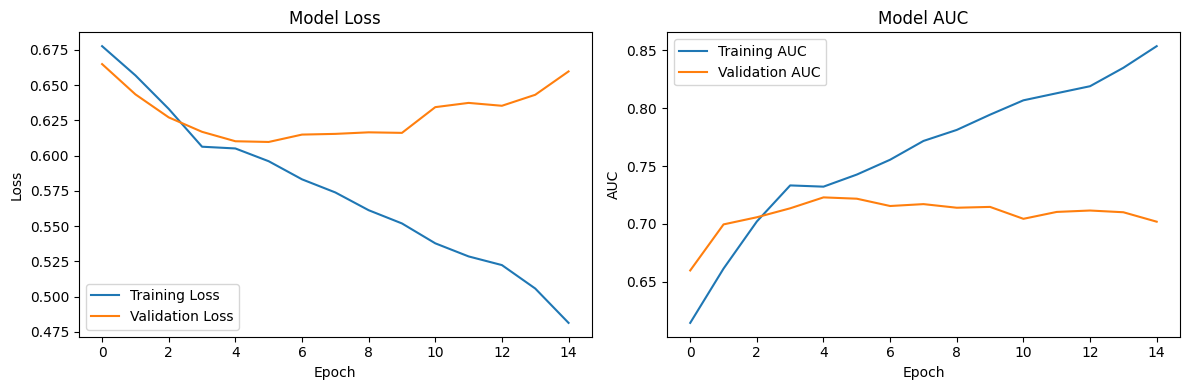

2025-01-17 13:59:05,005 - INFO - AUC, Logging: 0.7287795992714026


AUC: 0.7287795992714026
Loading split data for NoLabs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - auc: 0.6124 - loss: 0.6853

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.6122 - loss: 0.6852 - val_auc: 0.6725 - val_loss: 0.6626
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.6449 - loss: 0.6690 - val_auc: 0.6813 - val_loss: 0.6481
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7019 - loss: 0.6424 - val_auc: 0.6741 - val_loss: 0.6390
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7293 - loss: 0.6191 - val_auc: 0.6745 - val_loss: 0.6369
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7396 - loss: 0.6065 - val_auc: 0.6622 - val_loss: 0.6431
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.7620 - loss: 0.5869 - val_auc: 0.6659 - val_loss: 0.6447
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7656 - loss: 0.5827 - val_auc: 0.6621 - val_loss: 0.6481
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7770 - loss: 0.5732 - val_auc: 0.6555 - val_loss: 0.6603
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7919 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

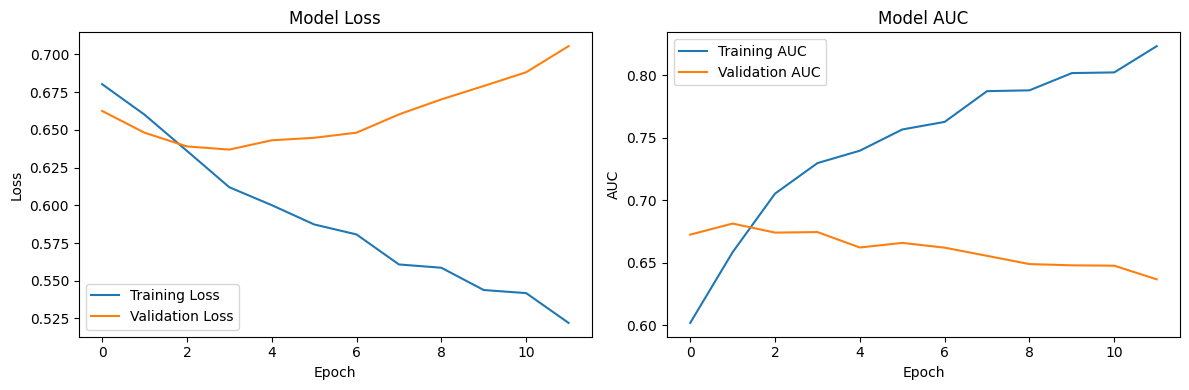

2025-01-17 13:59:59,929 - INFO - AUC, Logging: 0.7377732240437158


AUC: 0.7377732240437158
Loading split data for NoLabs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.6419 - loss: 0.6783

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.6415 - loss: 0.6783 - val_auc: 0.6335 - val_loss: 0.6706
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.6799 - loss: 0.6563 - val_auc: 0.6842 - val_loss: 0.6483
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7298 - loss: 0.6273 - val_auc: 0.7118 - val_loss: 0.6272
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7452 - loss: 0.6081 - val_auc: 0.7139 - val_loss: 0.6192
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7408 - loss: 0.6030 - val_auc: 0.7084 - val_loss: 0.6192
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7837 - loss: 0.5728 - val_auc: 0.7062 - val_loss: 0.6145
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7675 - loss: 0.5804 - val_auc: 0.7262 - val_loss: 0.6019
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7860 - loss: 0.5616 - val_auc: 0.7229 - val_loss: 0.5997
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7967 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

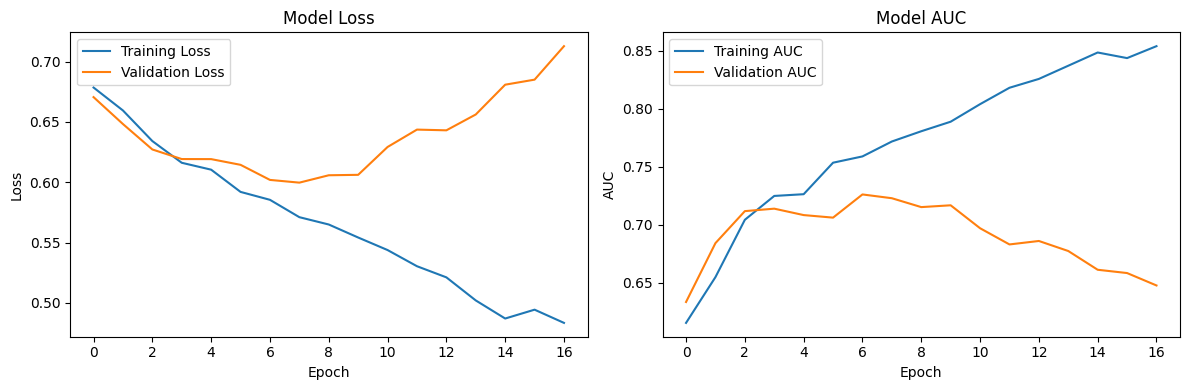

2025-01-17 14:01:17,296 - INFO - AUC, Logging: 0.7092668488160291


AUC: 0.7092668488160291
Loading split data for NoLabs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.6609 - loss: 0.6707

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.6605 - loss: 0.6708 - val_auc: 0.7000 - val_loss: 0.6550
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7071 - loss: 0.6452 - val_auc: 0.7248 - val_loss: 0.6343
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7479 - loss: 0.6128 - val_auc: 0.7277 - val_loss: 0.6208
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7623 - loss: 0.5924 - val_auc: 0.7346 - val_loss: 0.6140
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7680 - loss: 0.5795 - val_auc: 0.7284 - val_loss: 0.6144
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7857 - loss: 0.5660 - val_auc: 0.7254 - val_loss: 0.6152
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7784 - loss: 0.5662 - val_auc: 0.7248 - val_loss: 0.6169
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.8030 - loss: 0.5467 - val_auc: 0.7122 - val_loss: 0.6300
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.8072 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

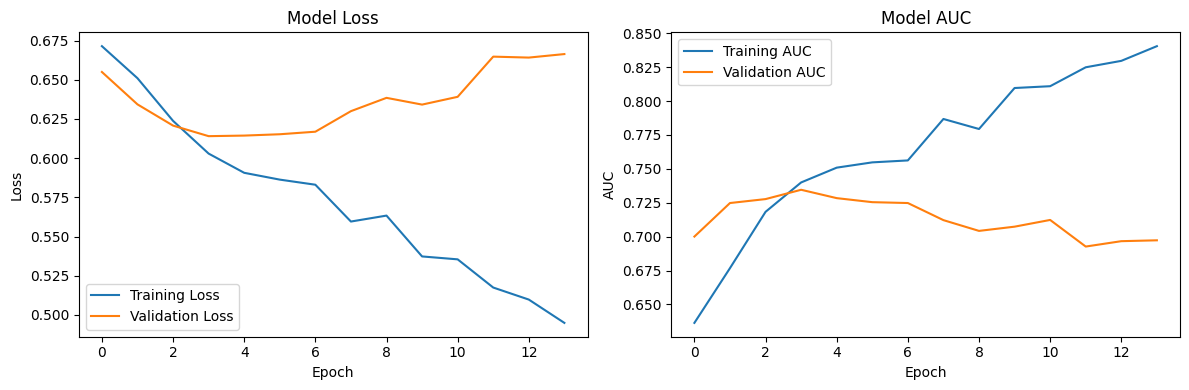

2025-01-17 14:02:18,113 - INFO - AUC, Logging: 0.649476320582878


AUC: 0.649476320582878
Loading split data for NoLabs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.6362 - loss: 0.6782

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.6359 - loss: 0.6782 - val_auc: 0.6959 - val_loss: 0.6568
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6596 - loss: 0.6635 - val_auc: 0.7277 - val_loss: 0.6345
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.6800 - loss: 0.6436 - val_auc: 0.7327 - val_loss: 0.6153
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7258 - loss: 0.6140 - val_auc: 0.7244 - val_loss: 0.6074
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7152 - loss: 0.6155 - val_auc: 0.7277 - val_loss: 0.5985
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7460 - loss: 0.5939 - val_auc: 0.7218 - val_loss: 0.5996
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7274 - loss: 0.5962 - val_auc: 0.7242 - val_loss: 0.5955
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7626 - loss: 0.5731 - val_auc: 0.7215 - val_loss: 0.6011
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7485 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

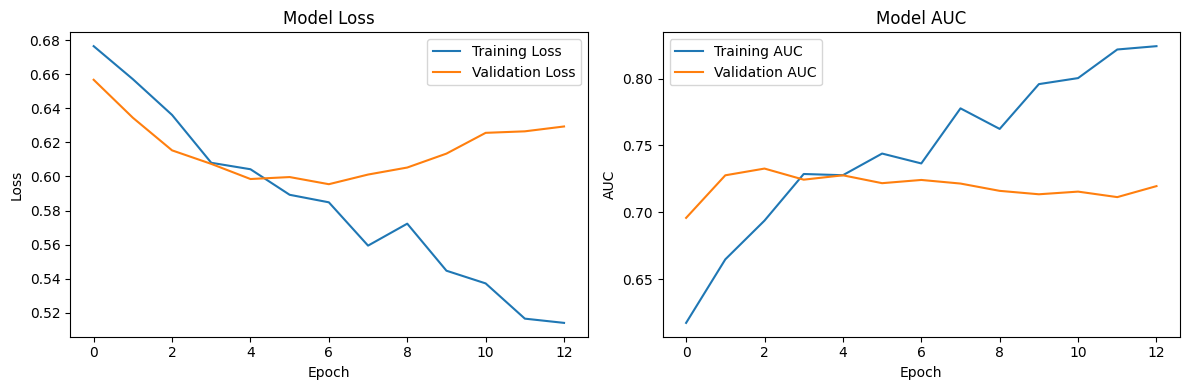

2025-01-17 14:03:13,316 - INFO - AUC, Logging: 0.7067942324615836


AUC: 0.7067942324615836
Loading split data for NoLabs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.5518 - loss: 0.7005

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.5522 - loss: 0.7003 - val_auc: 0.6385 - val_loss: 0.6729
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.6477 - loss: 0.6742 - val_auc: 0.6846 - val_loss: 0.6439
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6943 - loss: 0.6434 - val_auc: 0.6852 - val_loss: 0.6338
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7156 - loss: 0.6277 - val_auc: 0.6987 - val_loss: 0.6217
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7420 - loss: 0.6033 - val_auc: 0.6954 - val_loss: 0.6232
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7448 - loss: 0.5989 - val_auc: 0.6949 - val_loss: 0.6221
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7649 - loss: 0.5817 - val_auc: 0.6986 - val_loss: 0.6212
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.7669 - loss: 0.5818 - val_auc: 0.6968 - val_loss: 0.6209
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7855 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

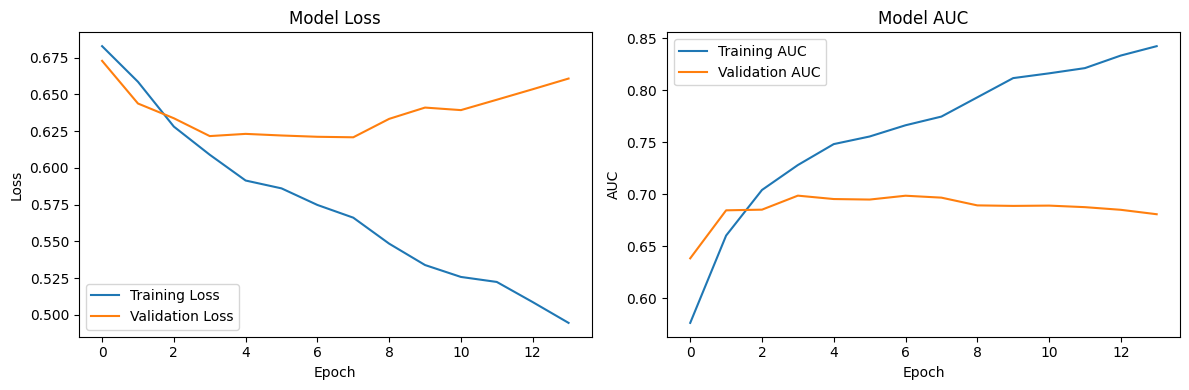

2025-01-17 14:04:16,474 - INFO - AUC, Logging: 0.6951275045537341


AUC: 0.6951275045537341
Loading split data for NoLabs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.5088 - loss: 0.7132

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.5096 - loss: 0.7128 - val_auc: 0.6655 - val_loss: 0.6722
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.5967 - loss: 0.6899 - val_auc: 0.6677 - val_loss: 0.6554
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.6311 - loss: 0.6782 - val_auc: 0.6643 - val_loss: 0.6466
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.6897 - loss: 0.6493 - val_auc: 0.6572 - val_loss: 0.6419
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.6975 - loss: 0.6355 - val_auc: 0.6545 - val_loss: 0.6411
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7270 - loss: 0.6190 - val_auc: 0.6416 - val_loss: 0.6505
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7494 - loss: 0.6032 - val_auc: 0.6341 - val_loss: 0.6620
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7534 - loss: 0.5964 - val_auc: 0.6325 - val_loss: 0.6654
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7550 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

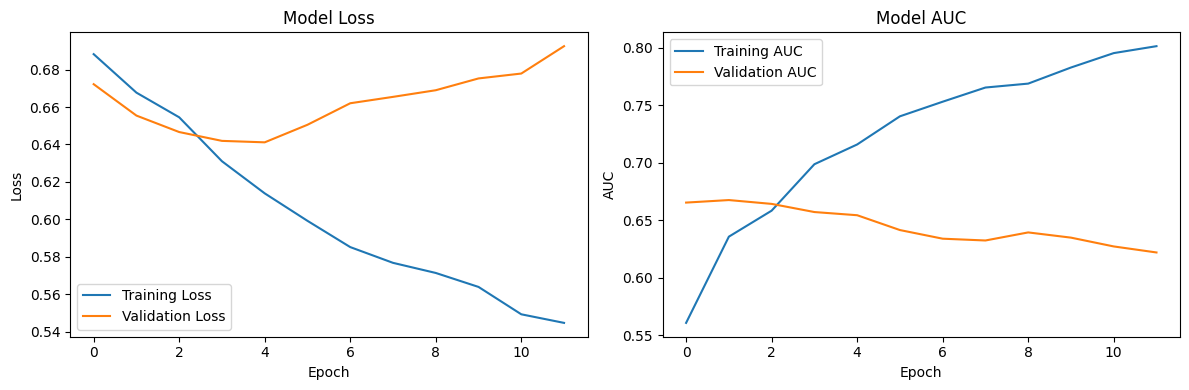

2025-01-17 14:05:08,906 - INFO - AUC, Logging: 0.7543032786885246


AUC: 0.7543032786885246
Loading split data for NoLabs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - auc: 0.5276 - loss: 0.7090

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.5281 - loss: 0.7087 - val_auc: 0.6100 - val_loss: 0.6772
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.6415 - loss: 0.6783 - val_auc: 0.6807 - val_loss: 0.6481
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6900 - loss: 0.6554 - val_auc: 0.7191 - val_loss: 0.6173
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7380 - loss: 0.6153 - val_auc: 0.7326 - val_loss: 0.6017
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7577 - loss: 0.5944 - val_auc: 0.7406 - val_loss: 0.5941
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7622 - loss: 0.5924 - val_auc: 0.7511 - val_loss: 0.5895
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7816 - loss: 0.5755 - val_auc: 0.7557 - val_loss: 0.5830
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7838 - loss: 0.5687 - val_auc: 0.7628 - val_loss: 0.5763
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7949 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

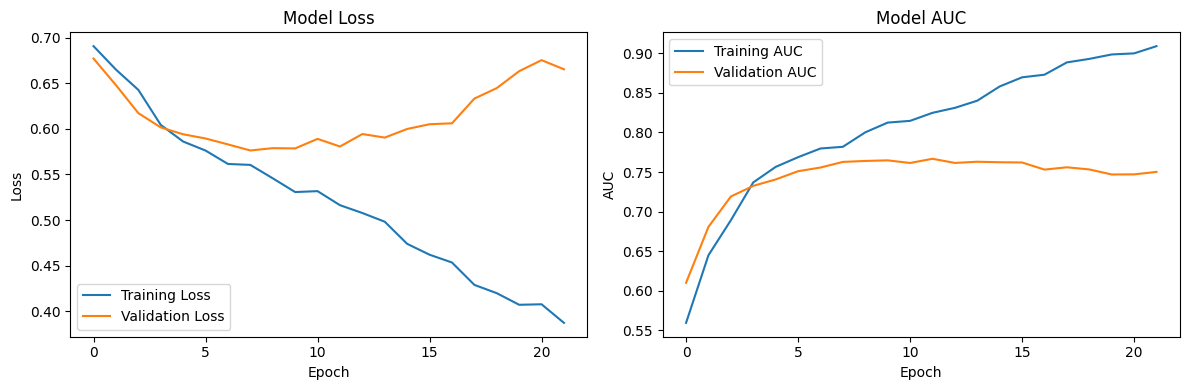

2025-01-17 14:06:37,683 - INFO - AUC, Logging: 0.6742714025500911


AUC: 0.6742714025500911
Loading split data for NoLabs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.5764 - loss: 0.6964

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.5766 - loss: 0.6962 - val_auc: 0.6784 - val_loss: 0.6628
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6736 - loss: 0.6666 - val_auc: 0.7134 - val_loss: 0.6327
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6966 - loss: 0.6491 - val_auc: 0.7224 - val_loss: 0.6174
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.7510 - loss: 0.6132 - val_auc: 0.7319 - val_loss: 0.6031
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7644 - loss: 0.5947 - val_auc: 0.7237 - val_loss: 0.5984
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7714 - loss: 0.5907 - val_auc: 0.7229 - val_loss: 0.5970
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7887 - loss: 0.5682 - val_auc: 0.7185 - val_loss: 0.5964
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7907 - loss: 0.5636 - val_auc: 0.7118 - val_loss: 0.6065
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.7979 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

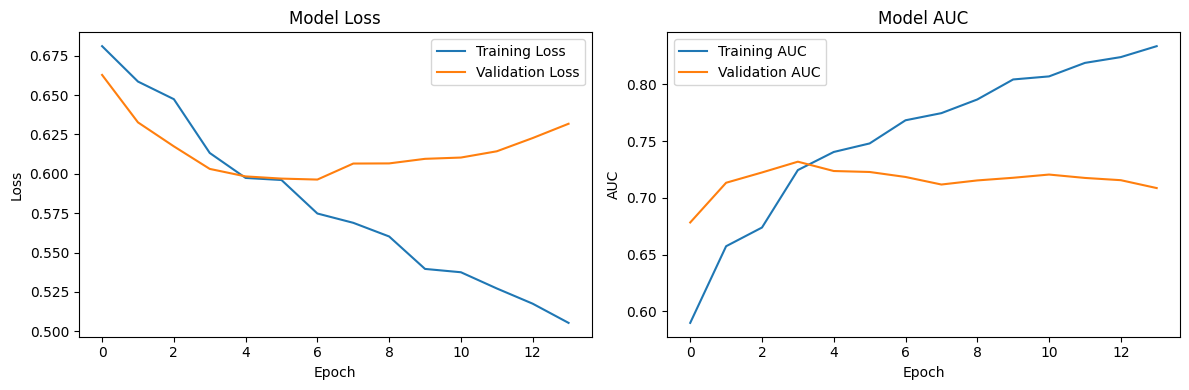

2025-01-17 14:07:36,527 - INFO - AUC, Logging: 0.7036429872495445


AUC: 0.7036429872495445
Loading split data for NoLabs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.5661 - loss: 0.7026

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.5669 - loss: 0.7020 - val_auc: 0.6204 - val_loss: 0.6735
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.6490 - loss: 0.6734 - val_auc: 0.6684 - val_loss: 0.6532
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.6990 - loss: 0.6450 - val_auc: 0.6883 - val_loss: 0.6383
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7288 - loss: 0.6199 - val_auc: 0.7017 - val_loss: 0.6278
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7489 - loss: 0.6056 - val_auc: 0.7108 - val_loss: 0.6218
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7628 - loss: 0.5888 - val_auc: 0.7268 - val_loss: 0.6123
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7853 - loss: 0.5708 - val_auc: 0.7312 - val_loss: 0.6113
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7827 - loss: 0.5728 - val_auc: 0.7315 - val_loss: 0.6100
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7905 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

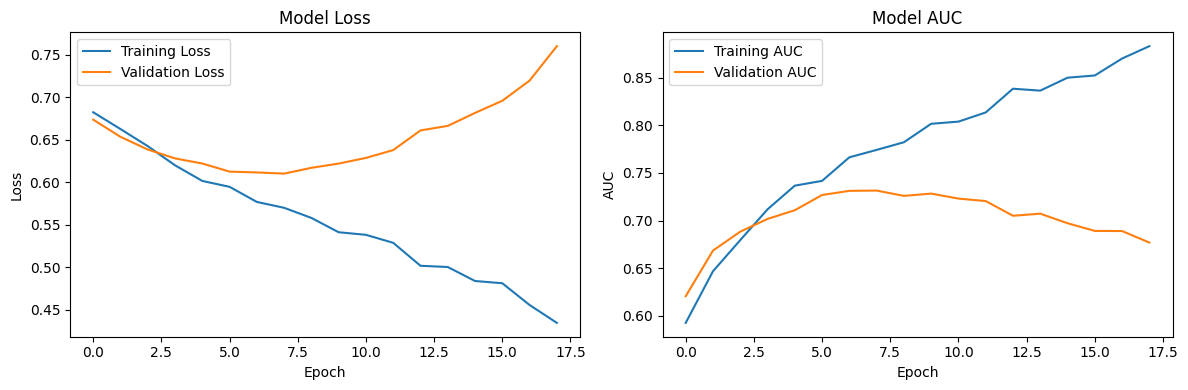

2025-01-17 14:08:50,979 - INFO - AUC, Logging: 0.7430105828463118


AUC: 0.7430105828463118
Loading split data for NoLabs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - auc: 0.5500 - loss: 0.7123

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - auc: 0.5501 - loss: 0.7121 - val_auc: 0.7036 - val_loss: 0.6591
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.6486 - loss: 0.6675 - val_auc: 0.7404 - val_loss: 0.6350
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - auc: 0.6890 - loss: 0.6463 - val_auc: 0.7448 - val_loss: 0.6157
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7108 - loss: 0.6269 - val_auc: 0.7551 - val_loss: 0.6020
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7030 - loss: 0.6277 - val_auc: 0.7457 - val_loss: 0.5976
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - auc: 0.7354 - loss: 0.6067 - val_auc: 0.7411 - val_loss: 0.5988
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7402 - loss: 0.5991 - val_auc: 0.7358 - val_loss: 0.6000
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7479 - loss: 0.5919 - val_auc: 0.7397 - val_loss: 0.5961
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - auc: 0.7768 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

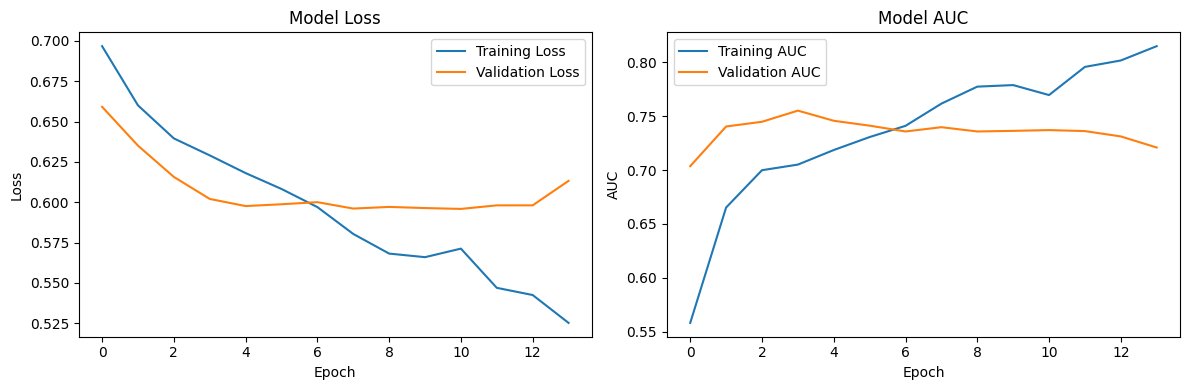

2025-01-17 14:09:50,950 - INFO - AUC, Logging: 0.729007285974499


AUC: 0.729007285974499
Loading split data for NoLabs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.5952 - loss: 0.7029 - val_auc: 0.7219 - val_loss: 0.6565


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6914 - loss: 0.6513 - val_auc: 0.7567 - val_loss: 0.6193
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7359 - loss: 0.6179 - val_auc: 0.7645 - val_loss: 0.5969
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7368 - loss: 0.6051 - val_auc: 0.7603 - val_loss: 0.5924
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - auc: 0.7432 - loss: 0.5954 - val_auc: 0.7537 - val_loss: 0.5907
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7773 - loss: 0.5709 - val_auc: 0.7564 - val_loss: 0.5884
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7729 - loss: 0.5723 - val_auc: 0.7487 - val_loss: 0.5953
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7771 - loss: 0.5644 - val_auc: 0.7467 - val_loss: 0.5968
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7968 - loss: 0.5425 - val_auc: 0.7485 - val_loss: 0.5923
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - a

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

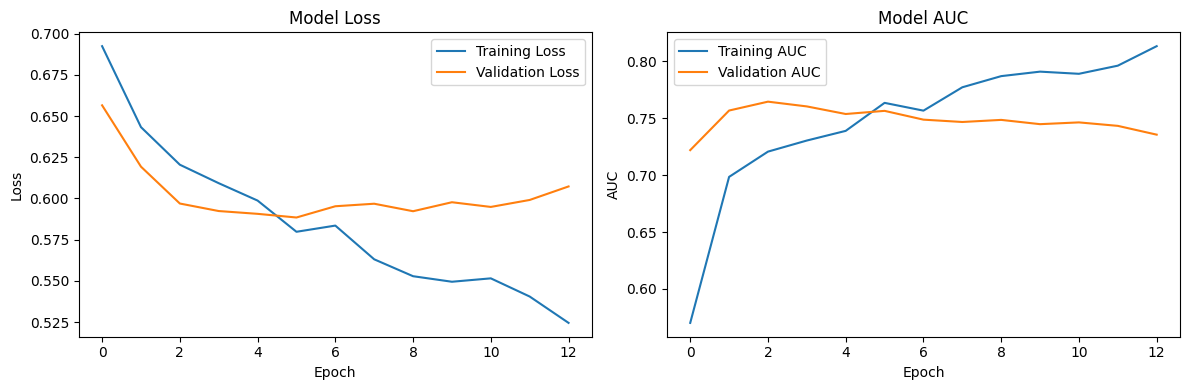

2025-01-17 14:10:42,692 - INFO - AUC, Logging: 0.6843579234972678


AUC: 0.6843579234972678
Loading split data for NoLabs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.5812 - loss: 0.7039

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5810 - loss: 0.7037 - val_auc: 0.6615 - val_loss: 0.6692
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6804 - loss: 0.6551 - val_auc: 0.6568 - val_loss: 0.6605
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7065 - loss: 0.6350 - val_auc: 0.6612 - val_loss: 0.6525
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7204 - loss: 0.6169 - val_auc: 0.6601 - val_loss: 0.6510
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7188 - loss: 0.6171 - val_auc: 0.6629 - val_loss: 0.6461
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7267 - loss: 0.6096 - val_auc: 0.6660 - val_loss: 0.6398
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7469 - loss: 0.5944 - val_auc: 0.6690 - val_loss: 0.6357
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7494 - loss: 0.5917 - val_auc: 0.6699 - val_loss: 0.6321
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7642 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

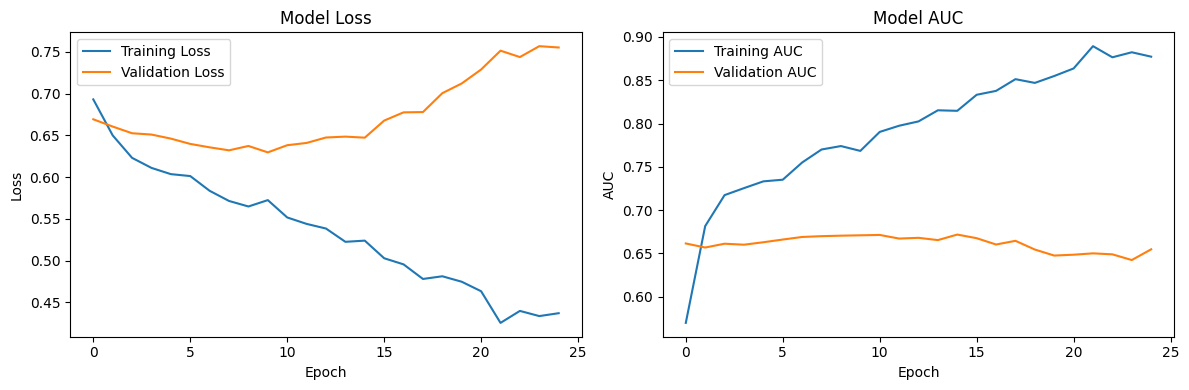

2025-01-17 14:12:19,844 - INFO - AUC, Logging: 0.7157559198542806


AUC: 0.7157559198542806
Loading split data for NoLabs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.5866 - loss: 0.7028

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5866 - loss: 0.7026 - val_auc: 0.6956 - val_loss: 0.6647
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6924 - loss: 0.6531 - val_auc: 0.7134 - val_loss: 0.6423
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7048 - loss: 0.6356 - val_auc: 0.7155 - val_loss: 0.6292
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7001 - loss: 0.6270 - val_auc: 0.7192 - val_loss: 0.6223
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7357 - loss: 0.6047 - val_auc: 0.7179 - val_loss: 0.6185
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7332 - loss: 0.6029 - val_auc: 0.7172 - val_loss: 0.6148
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7371 - loss: 0.5991 - val_auc: 0.7173 - val_loss: 0.6156
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7416 - loss: 0.5987 - val_auc: 0.7201 - val_loss: 0.6121
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7651 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

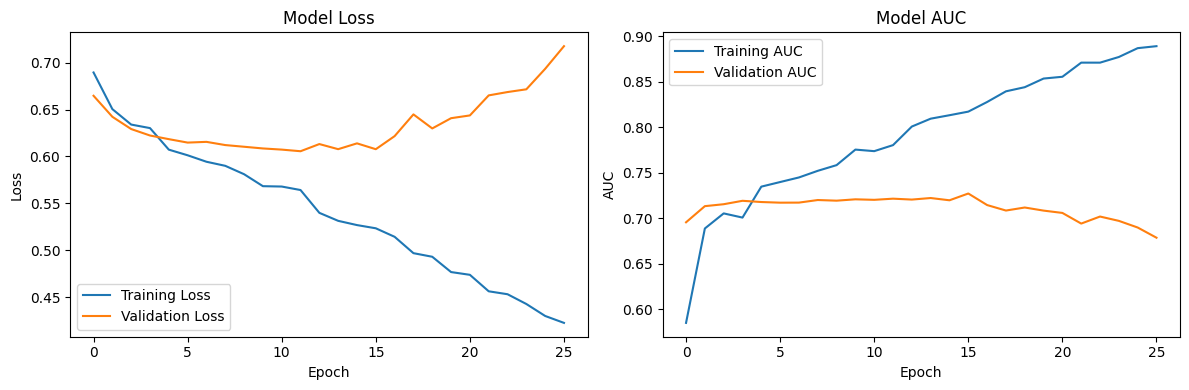

2025-01-17 14:13:58,446 - INFO - AUC, Logging: 0.7180783242258653


AUC: 0.7180783242258653
Loading split data for NoLabs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.5929 - loss: 0.7021 - val_auc: 0.6821 - val_loss: 0.6611
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7000 - loss: 0.6503 - val_auc: 0.6856 - val_loss: 0.6455
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7222 - loss: 0.6229 - val_auc: 0.6813 - val_loss: 0.6423
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7299 - loss: 0.6099 - val_auc: 0.6808 - val_loss: 0.6408
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7328 - loss: 0.6080 - val_auc: 0.6813 - val_loss: 0.6407
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7586 - loss: 0.5886 - val_auc: 0.6854 - val_loss: 0.6379
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7693 - loss: 0.5753 - val_auc: 0.6888 - val_loss: 0.6404
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7692 - loss: 0.5745 - val_auc: 0.6893 - val_loss: 0.6406
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7890 - loss: 0.5503 - val_auc: 0.6924 - val_loss: 0.6405
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7908 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

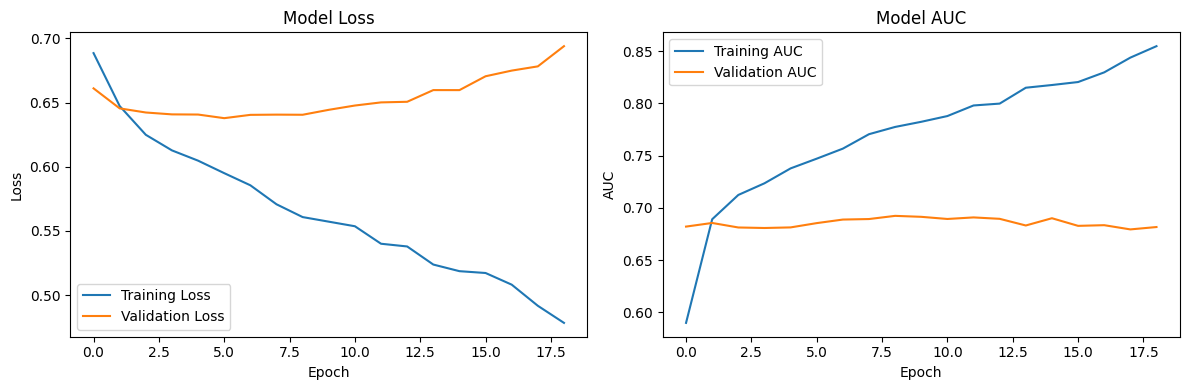

2025-01-17 14:15:05,545 - INFO - AUC, Logging: 0.7133379967055531


AUC: 0.7133379967055531
Loading split data for NoLabs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.5567 - loss: 0.7098 - val_auc: 0.7149 - val_loss: 0.6415


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6534 - loss: 0.6662 - val_auc: 0.7343 - val_loss: 0.6215
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6724 - loss: 0.6535 - val_auc: 0.7316 - val_loss: 0.6121
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6796 - loss: 0.6465 - val_auc: 0.7263 - val_loss: 0.6144
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7348 - loss: 0.6120 - val_auc: 0.7281 - val_loss: 0.6138
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7293 - loss: 0.6093 - val_auc: 0.7233 - val_loss: 0.6225
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7279 - loss: 0.6125 - val_auc: 0.7174 - val_loss: 0.6336
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.7413 - loss: 0.6051 - val_auc: 0.7175 - val_loss: 0.6373
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7548 - loss: 0.5886 - val_auc: 0.7165 - val_loss: 0.6393
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - a

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

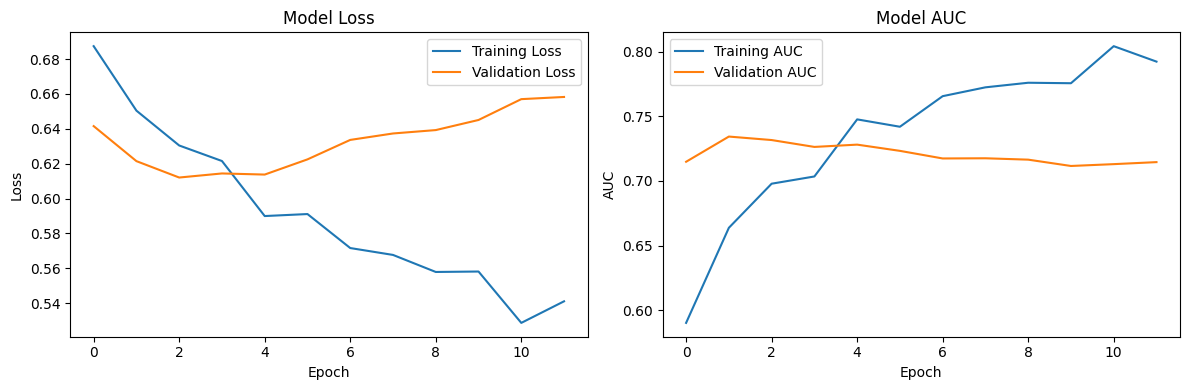

2025-01-17 14:15:47,568 - INFO - AUC, Logging: 0.6939663023679417


AUC: 0.6939663023679417
Loading split data for NoLabs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - auc: 0.5637 - loss: 0.7063 - val_auc: 0.6018 - val_loss: 0.6739
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6609 - loss: 0.6651 - val_auc: 0.6356 - val_loss: 0.6588
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6787 - loss: 0.6534 - val_auc: 0.6487 - val_loss: 0.6512
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7089 - loss: 0.6342 - val_auc: 0.6537 - val_loss: 0.6515
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7211 - loss: 0.6229 - val_auc: 0.6628 - val_loss: 0.6410
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7338 - loss: 0.6107 - val_auc: 0.6552 - val_loss: 0.6537
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7458 - loss: 0.5965 - val_auc: 0.6686 - val_loss: 0.6568
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7589 - loss: 0.5899 - val_auc: 0.6704 - val_loss: 0.6501
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7619 - loss: 0.5807 - val_auc: 0.6691 - val_loss: 0.6515
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.7760 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

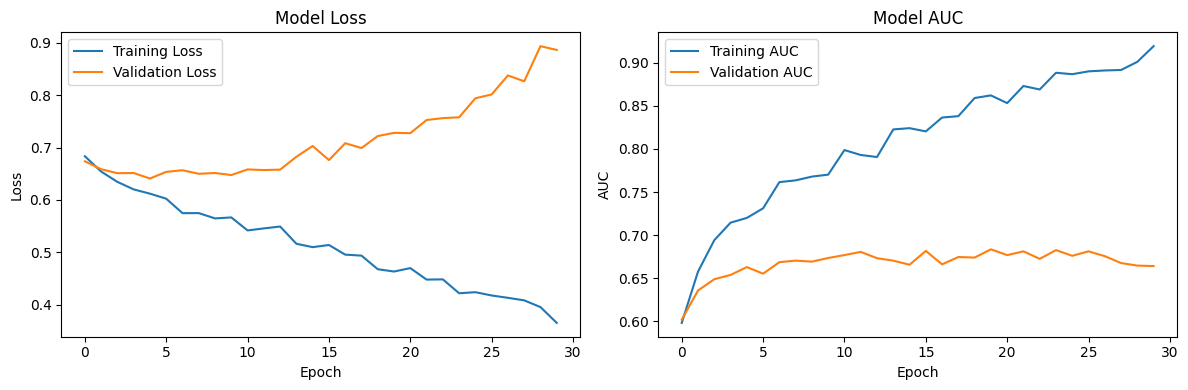

2025-01-17 14:17:30,207 - INFO - AUC, Logging: 0.7229280510018214


AUC: 0.7229280510018214
Loading split data for NoLabs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.5580 - loss: 0.7060

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.5588 - loss: 0.7056 - val_auc: 0.6555 - val_loss: 0.6599
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6650 - loss: 0.6627 - val_auc: 0.6806 - val_loss: 0.6415
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6714 - loss: 0.6531 - val_auc: 0.6847 - val_loss: 0.6344
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7060 - loss: 0.6310 - val_auc: 0.6773 - val_loss: 0.6368
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7235 - loss: 0.6181 - val_auc: 0.6894 - val_loss: 0.6260
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - auc: 0.7272 - loss: 0.6147 - val_auc: 0.6892 - val_loss: 0.6268
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - auc: 0.7563 - loss: 0.5917 - val_auc: 0.6891 - val_loss: 0.6290
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7620 - loss: 0.5864 - val_auc: 0.6800 - val_loss: 0.6346
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7681 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

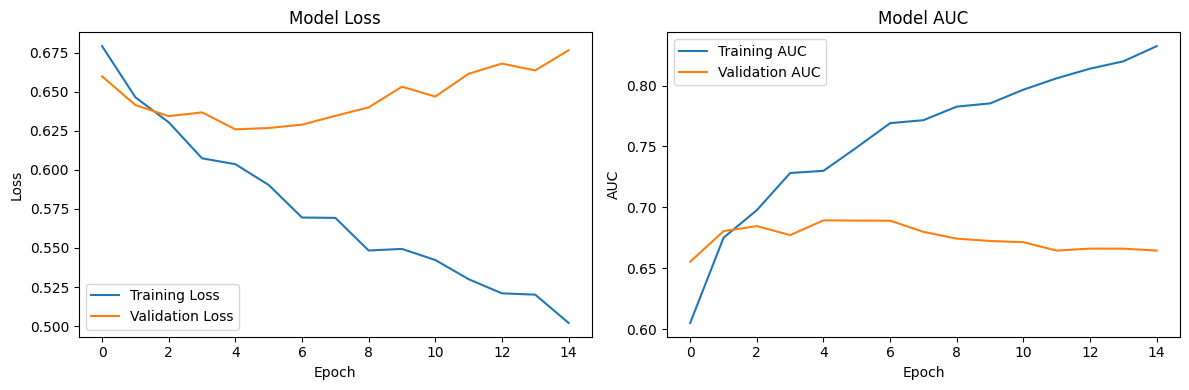

2025-01-17 14:18:20,312 - INFO - AUC, Logging: 0.670787795992714


AUC: 0.670787795992714
Loading split data for NoLabs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.5724 - loss: 0.7038 - val_auc: 0.6183 - val_loss: 0.6693
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6734 - loss: 0.6621 - val_auc: 0.6599 - val_loss: 0.6542
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6718 - loss: 0.6505 - val_auc: 0.6789 - val_loss: 0.6466
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.6952 - loss: 0.6381 - val_auc: 0.6859 - val_loss: 0.6424
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.7179 - loss: 0.6198 - val_auc: 0.6975 - val_loss: 0.6358
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7434 - loss: 0.5990 - val_auc: 0.6973 - val_loss: 0.6423
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7365 - loss: 0.6068 - val_auc: 0.7012 - val_loss: 0.6537
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7402 - loss: 0.6076 - val_auc: 0.7028 - val_loss: 0.6499
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7516 - loss: 0.5915 - val_auc: 0.7018 - val_loss: 0.6526
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7729 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

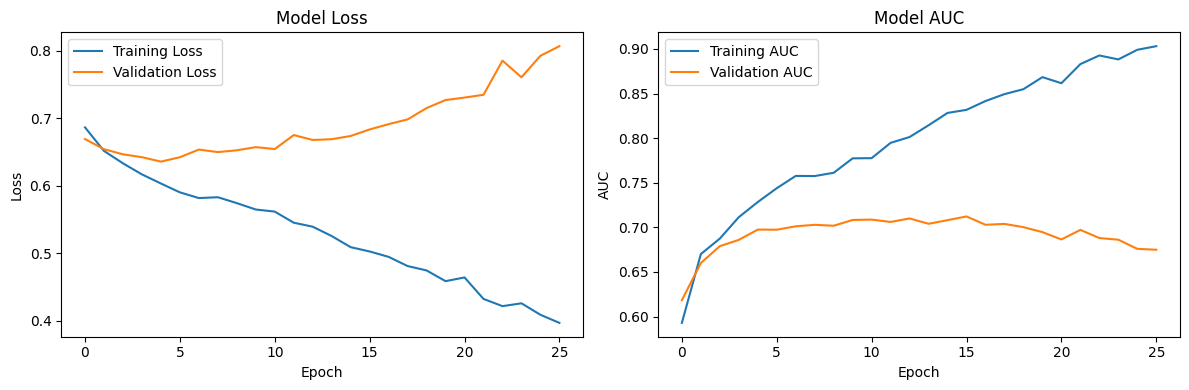

2025-01-17 14:19:49,221 - INFO - AUC, Logging: 0.7227459016393444


AUC: 0.7227459016393444
Loading split data for NoLabs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.5552 - loss: 0.7090 - val_auc: 0.6382 - val_loss: 0.6648
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6723 - loss: 0.6597 - val_auc: 0.6521 - val_loss: 0.6591
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7090 - loss: 0.6374 - val_auc: 0.6619 - val_loss: 0.6546
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7208 - loss: 0.6264 - val_auc: 0.6668 - val_loss: 0.6556
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7343 - loss: 0.6141 - val_auc: 0.6712 - val_loss: 0.6557
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7547 - loss: 0.6006 - val_auc: 0.6818 - val_loss: 0.6563
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7618 - loss: 0.5921 - val_auc: 0.6939 - val_loss: 0.6520
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7646 - loss: 0.5948 - val_auc: 0.6922 - val_loss: 0.6638
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7785 - loss: 0.5776 - val_auc: 0.6937 - val_loss: 0.6578
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7877 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

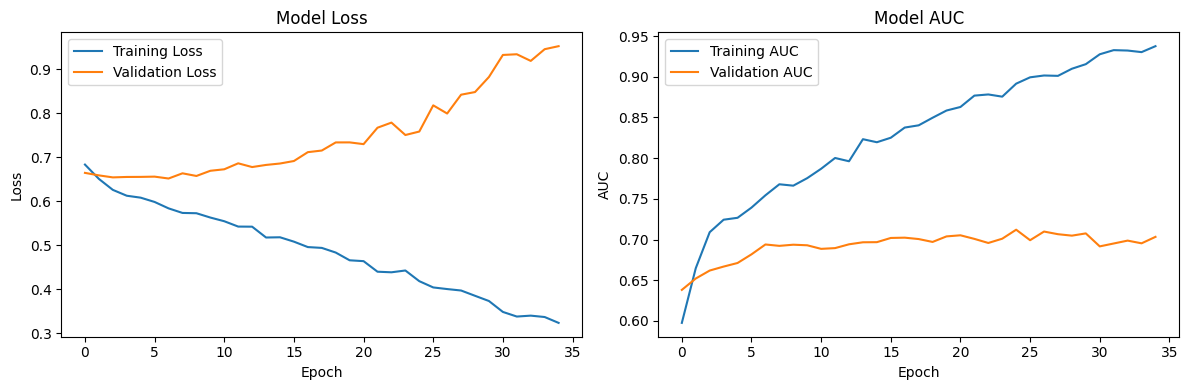

2025-01-17 14:21:54,340 - INFO - AUC, Logging: 0.6789042579596993


AUC: 0.6789042579596993
Loading split data for NoLabs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.5401 - loss: 0.7077

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.5407 - loss: 0.7073 - val_auc: 0.6026 - val_loss: 0.6836
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.6736 - loss: 0.6536 - val_auc: 0.6244 - val_loss: 0.6672
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7189 - loss: 0.6246 - val_auc: 0.6421 - val_loss: 0.6584
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7374 - loss: 0.6006 - val_auc: 0.6574 - val_loss: 0.6529
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.7311 - loss: 0.6006 - val_auc: 0.6576 - val_loss: 0.6540
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7670 - loss: 0.5742 - val_auc: 0.6674 - val_loss: 0.6524
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7662 - loss: 0.5689 - val_auc: 0.6641 - val_loss: 0.6603
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7757 - loss: 0.5607 - val_auc: 0.6645 - val_loss: 0.6614
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7669 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

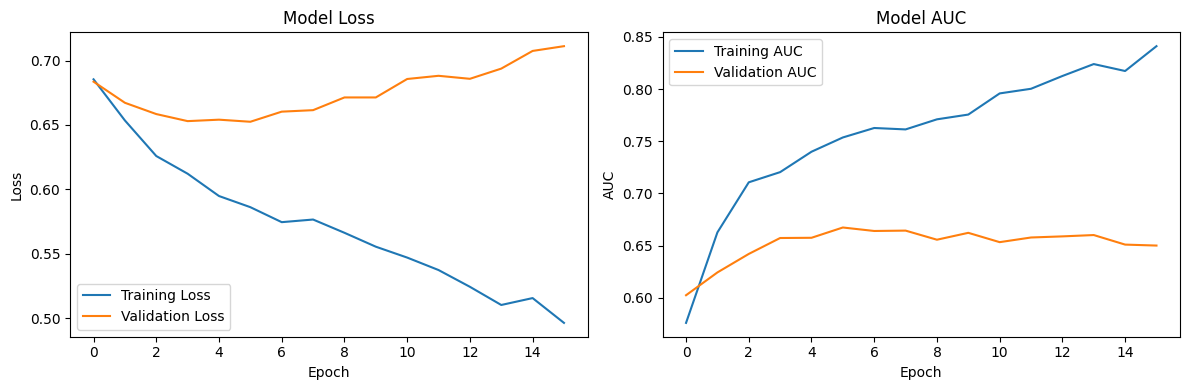

2025-01-17 14:22:58,571 - INFO - AUC, Logging: 0.7140938069216758


AUC: 0.7140938069216758
Loading split data for NoLabs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - auc: 0.5233 - loss: 0.7252

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.5240 - loss: 0.7247 - val_auc: 0.6706 - val_loss: 0.6630
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6519 - loss: 0.6622 - val_auc: 0.6932 - val_loss: 0.6432
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7225 - loss: 0.6247 - val_auc: 0.6965 - val_loss: 0.6336
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7044 - loss: 0.6253 - val_auc: 0.6886 - val_loss: 0.6300
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7601 - loss: 0.5898 - val_auc: 0.6933 - val_loss: 0.6247
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7671 - loss: 0.5808 - val_auc: 0.6877 - val_loss: 0.6250
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7681 - loss: 0.5749 - val_auc: 0.6836 - val_loss: 0.6262
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7673 - loss: 0.5759 - val_auc: 0.6886 - val_loss: 0.6217
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7706 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

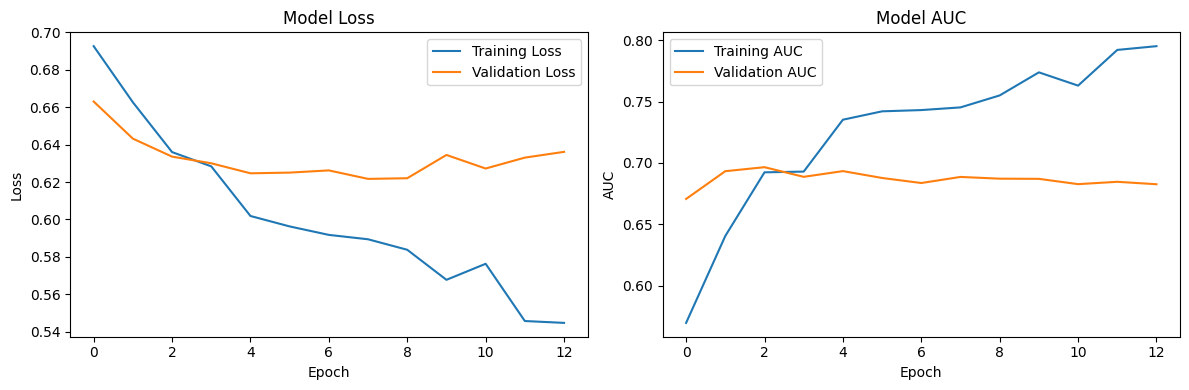

2025-01-17 14:23:49,585 - INFO - AUC, Logging: 0.7333788706739527


AUC: 0.7333788706739527
Loading split data for NoLabs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.5016 - loss: 0.7303 - val_auc: 0.7127 - val_loss: 0.6576
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6401 - loss: 0.6684 - val_auc: 0.7472 - val_loss: 0.6280
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.6971 - loss: 0.6382 - val_auc: 0.7569 - val_loss: 0.6020
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7062 - loss: 0.6248 - val_auc: 0.7642 - val_loss: 0.5890
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7058 - loss: 0.6233 - val_auc: 0.7593 - val_loss: 0.5875
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7304 - loss: 0.6061 - val_auc: 0.7633 - val_loss: 0.5832
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7437 - loss: 0.5901 - val_auc: 0.7632 - val_loss: 0.5776
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7466 - loss: 0.5826 - val_auc: 0.7581 - val_loss: 0.5733
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7415 - loss: 0.5923 - val_auc: 0.7543 - val_loss: 0.5757
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7657 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

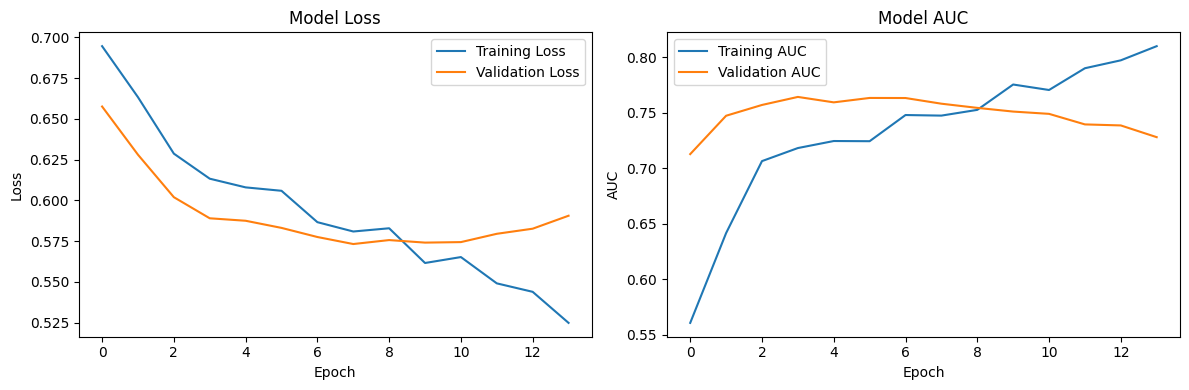

2025-01-17 14:24:43,681 - INFO - AUC, Logging: 0.7175318761384335


AUC: 0.7175318761384335
Loading split data for NoLabs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.5063 - loss: 0.7226 - val_auc: 0.6673 - val_loss: 0.6702
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6684 - loss: 0.6560 - val_auc: 0.6689 - val_loss: 0.6538
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7118 - loss: 0.6300 - val_auc: 0.6796 - val_loss: 0.6381
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7131 - loss: 0.6202 - val_auc: 0.6833 - val_loss: 0.6320
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7386 - loss: 0.5988 - val_auc: 0.6854 - val_loss: 0.6295
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7514 - loss: 0.5861 - val_auc: 0.6901 - val_loss: 0.6275
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7540 - loss: 0.5797 - val_auc: 0.6825 - val_loss: 0.6355
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7568 - loss: 0.5747 - val_auc: 0.6835 - val_loss: 0.6377
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7749 - loss: 0.5670 - val_auc: 0.6871 - val_loss: 0.6368
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7707 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

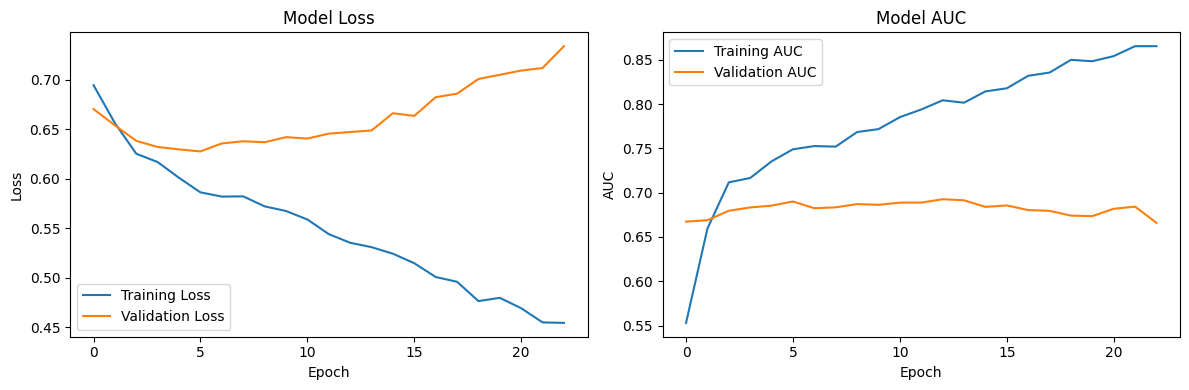

2025-01-17 14:26:14,887 - INFO - AUC, Logging: 0.7062841530054644


AUC: 0.7062841530054644
Loading split data for NoLabs, Fusion, rep 4 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5295 - loss: 0.7014 - val_auc: 0.6545 - val_loss: 0.6698
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6471 - loss: 0.6586 - val_auc: 0.6689 - val_loss: 0.6560
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7218 - loss: 0.6246 - val_auc: 0.6770 - val_loss: 0.6381
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7556 - loss: 0.5950 - val_auc: 0.6786 - val_loss: 0.6306
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7333 - loss: 0.6017 - val_auc: 0.6832 - val_loss: 0.6273
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7813 - loss: 0.5665 - val_auc: 0.6784 - val_loss: 0.6286
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7938 - loss: 0.5527 - val_auc: 0.6830 - val_loss: 0.6308
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7902 - loss: 0.5487 - val_auc: 0.6749 - val_loss: 0.6362
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.8107 - loss: 0.5291 - val_auc: 0.6802 - val_loss: 0.6381
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.8013 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

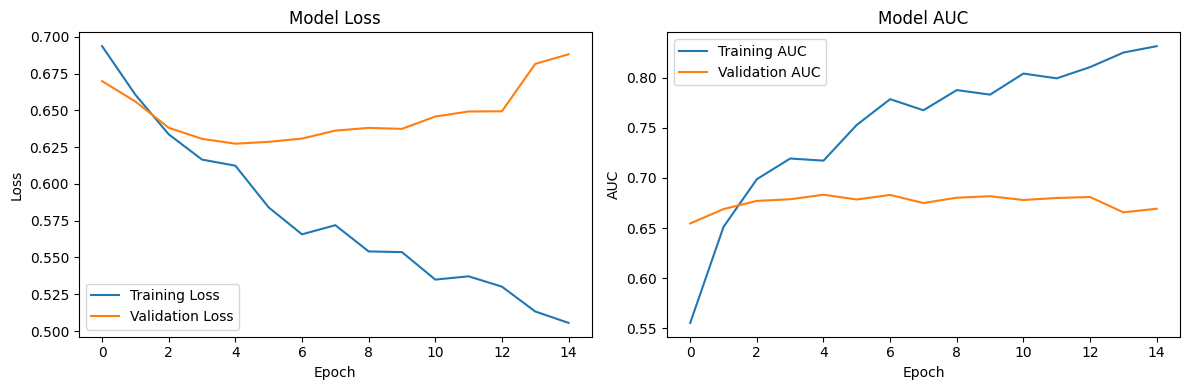

2025-01-17 14:27:09,108 - INFO - AUC, Logging: 0.71349594963558


AUC: 0.71349594963558
Loading split data for NoLabs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.4708 - loss: 0.7620

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.4714 - loss: 0.7613 - val_auc: 0.6159 - val_loss: 0.6811
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.5943 - loss: 0.6905 - val_auc: 0.6739 - val_loss: 0.6613
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.6664 - loss: 0.6670 - val_auc: 0.6957 - val_loss: 0.6355
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7044 - loss: 0.6421 - val_auc: 0.7234 - val_loss: 0.6110
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7379 - loss: 0.6092 - val_auc: 0.7304 - val_loss: 0.5973
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7164 - loss: 0.6231 - val_auc: 0.7402 - val_loss: 0.5887
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7621 - loss: 0.5901 - val_auc: 0.7378 - val_loss: 0.5900
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7478 - loss: 0.5918 - val_auc: 0.7430 - val_loss: 0.5878
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7763 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

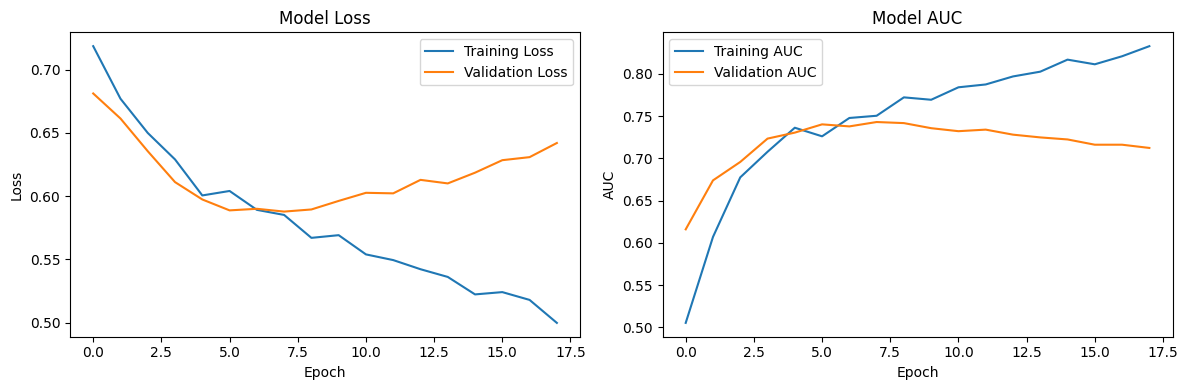

2025-01-17 14:28:12,388 - INFO - AUC, Logging: 0.7165072859744992


AUC: 0.7165072859744992
Loading split data for NoLabs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.4590 - loss: 0.7654 - val_auc: 0.6923 - val_loss: 0.6708
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6284 - loss: 0.6826 - val_auc: 0.7185 - val_loss: 0.6510
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6561 - loss: 0.6681 - val_auc: 0.7200 - val_loss: 0.6293
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7027 - loss: 0.6407 - val_auc: 0.7211 - val_loss: 0.6141
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7192 - loss: 0.6216 - val_auc: 0.7158 - val_loss: 0.6099
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - auc: 0.6986 - loss: 0.6337 - val_auc: 0.7175 - val_loss: 0.6040
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7458 - loss: 0.5950 - val_auc: 0.7281 - val_loss: 0.5962
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7343 - loss: 0.6029 - val_auc: 0.7294 - val_loss: 0.5950
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7668 - loss: 0.5818 - val_auc: 0.7306 - val_loss: 0.5977
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7596 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

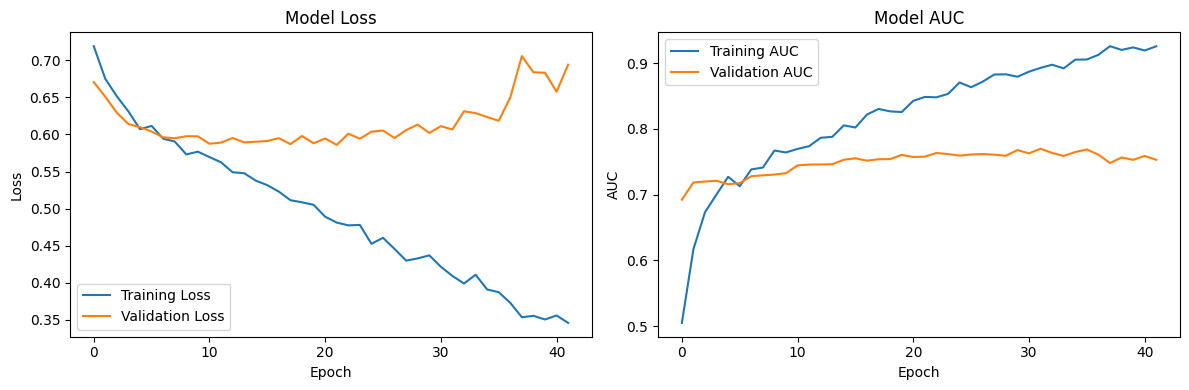

2025-01-17 14:30:43,339 - INFO - AUC, Logging: 0.6806693989071039


AUC: 0.6806693989071039
Loading split data for NoLabs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.4791 - loss: 0.7605 - val_auc: 0.6754 - val_loss: 0.6741
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6165 - loss: 0.6867 - val_auc: 0.7144 - val_loss: 0.6503
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6312 - loss: 0.6795 - val_auc: 0.7160 - val_loss: 0.6290
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6862 - loss: 0.6513 - val_auc: 0.7268 - val_loss: 0.6062
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7230 - loss: 0.6222 - val_auc: 0.7268 - val_loss: 0.5968
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6784 - loss: 0.6508 - val_auc: 0.7224 - val_loss: 0.6001
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7432 - loss: 0.6036 - val_auc: 0.7268 - val_loss: 0.5958
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7319 - loss: 0.6029 - val_auc: 0.7166 - val_loss: 0.6029
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7609 - loss: 0.5838 - val_auc: 0.7072 - val_loss: 0.6130
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7482 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

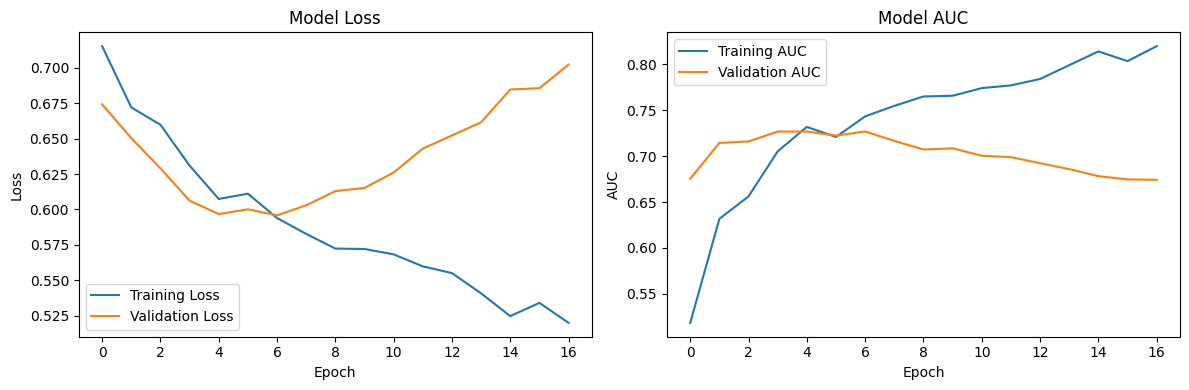

2025-01-17 14:31:43,759 - INFO - AUC, Logging: 0.7293488160291439


AUC: 0.7293488160291439
Loading split data for NoLabs, Fusion, rep 5 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - auc: 0.4642 - loss: 0.7613

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.4648 - loss: 0.7607 - val_auc: 0.6460 - val_loss: 0.6793
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6511 - loss: 0.6780 - val_auc: 0.6898 - val_loss: 0.6608
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6621 - loss: 0.6660 - val_auc: 0.6981 - val_loss: 0.6432
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7143 - loss: 0.6392 - val_auc: 0.7256 - val_loss: 0.6187
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7303 - loss: 0.6175 - val_auc: 0.7222 - val_loss: 0.6128
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7052 - loss: 0.6292 - val_auc: 0.7285 - val_loss: 0.6058
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7472 - loss: 0.6006 - val_auc: 0.7245 - val_loss: 0.6011
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7497 - loss: 0.5950 - val_auc: 0.7296 - val_loss: 0.5973
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7742 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

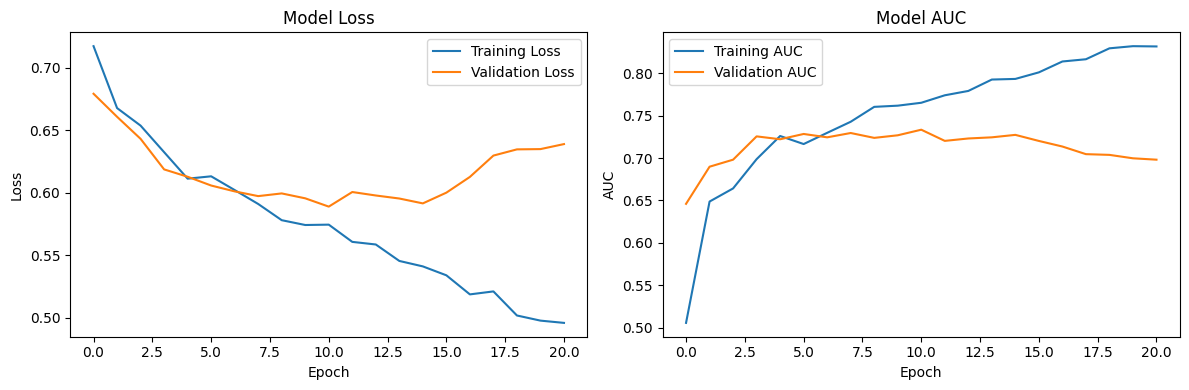

2025-01-17 14:32:59,467 - INFO - AUC, Logging: 0.713683970856102


AUC: 0.713683970856102
Loading split data for NoLabs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.4383 - loss: 0.7752 - val_auc: 0.6026 - val_loss: 0.6841
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6127 - loss: 0.6838 - val_auc: 0.6763 - val_loss: 0.6633
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6475 - loss: 0.6737 - val_auc: 0.7017 - val_loss: 0.6432
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6847 - loss: 0.6530 - val_auc: 0.7246 - val_loss: 0.6234
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7179 - loss: 0.6268 - val_auc: 0.7408 - val_loss: 0.6115
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6769 - loss: 0.6480 - val_auc: 0.7428 - val_loss: 0.6024
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7416 - loss: 0.6060 - val_auc: 0.7453 - val_loss: 0.5986
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7300 - loss: 0.6127 - val_auc: 0.7446 - val_loss: 0.5981
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7525 - loss: 0.5931 - val_auc: 0.7484 - val_loss: 0.5958
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7556 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

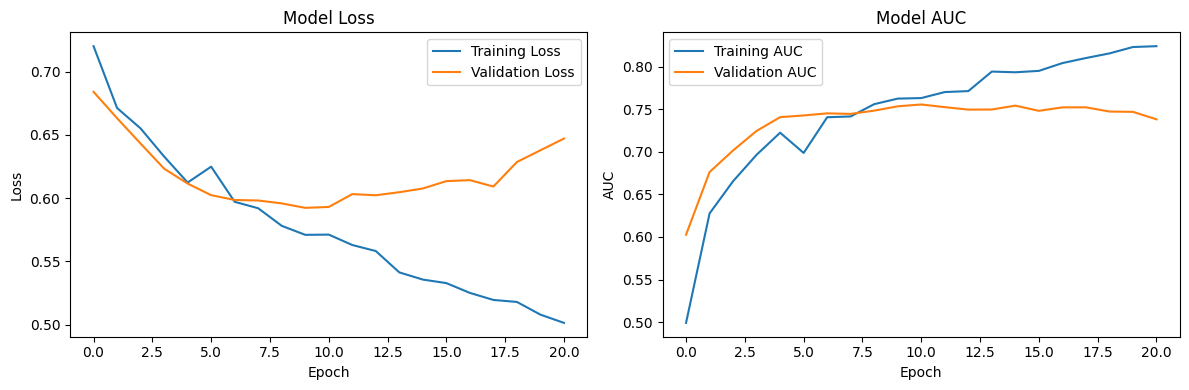

2025-01-17 14:34:13,722 - INFO - AUC, Logging: 0.6901640454001851


AUC: 0.6901640454001851
Loading split data for NoLabs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.5592 - loss: 0.6826 - val_auc: 0.6704 - val_loss: 0.6639
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6582 - loss: 0.6467 - val_auc: 0.7194 - val_loss: 0.6402
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7023 - loss: 0.6214 - val_auc: 0.7212 - val_loss: 0.6254
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7281 - loss: 0.6005 - val_auc: 0.7268 - val_loss: 0.6165
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7273 - loss: 0.5962 - val_auc: 0.7232 - val_loss: 0.6130
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7393 - loss: 0.5884 - val_auc: 0.7205 - val_loss: 0.6107
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7661 - loss: 0.5609 - val_auc: 0.7354 - val_loss: 0.6035
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7802 - loss: 0.5531 - val_auc: 0.7290 - val_loss: 0.6050
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7705 - loss: 0.5604 - val_auc: 0.7304 - val_loss: 0.6069
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7936 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

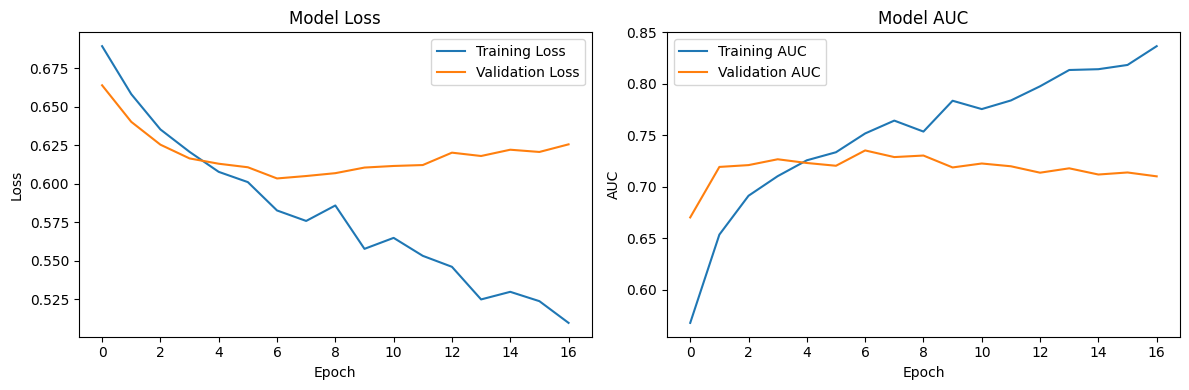

2025-01-17 14:35:15,975 - INFO - AUC, Logging: 0.7584244080145719


AUC: 0.7584244080145719
Loading split data for NoLabs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.5817 - loss: 0.6718

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.5820 - loss: 0.6719 - val_auc: 0.6612 - val_loss: 0.6579
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7164 - loss: 0.6157 - val_auc: 0.6747 - val_loss: 0.6406
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7295 - loss: 0.6025 - val_auc: 0.6823 - val_loss: 0.6294
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7492 - loss: 0.5867 - val_auc: 0.6883 - val_loss: 0.6225
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7554 - loss: 0.5784 - val_auc: 0.6935 - val_loss: 0.6195
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7631 - loss: 0.5697 - val_auc: 0.7029 - val_loss: 0.6117
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7744 - loss: 0.5640 - val_auc: 0.7054 - val_loss: 0.6131
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7747 - loss: 0.5517 - val_auc: 0.7078 - val_loss: 0.6106
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7911 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

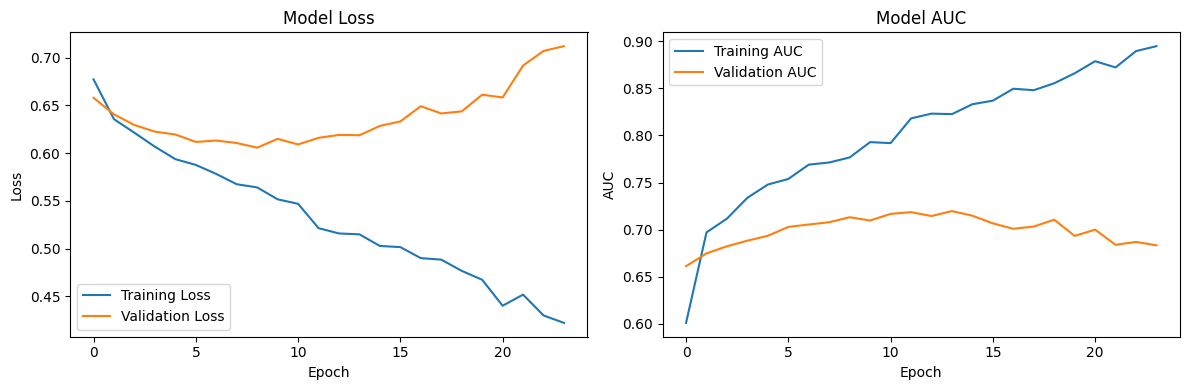

2025-01-17 14:36:47,225 - INFO - AUC, Logging: 0.6910746812386157


AUC: 0.6910746812386157
Loading split data for NoLabs, Fusion, rep 6 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.5643 - loss: 0.6801 - val_auc: 0.6008 - val_loss: 0.6769
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6834 - loss: 0.6370 - val_auc: 0.6253 - val_loss: 0.6653
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7027 - loss: 0.6197 - val_auc: 0.6404 - val_loss: 0.6625
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7411 - loss: 0.5902 - val_auc: 0.6482 - val_loss: 0.6632
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7386 - loss: 0.5915 - val_auc: 0.6568 - val_loss: 0.6613
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7335 - loss: 0.5886 - val_auc: 0.6603 - val_loss: 0.6641
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7450 - loss: 0.5778 - val_auc: 0.6655 - val_loss: 0.6645
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7720 - loss: 0.5585 - val_auc: 0.6650 - val_loss: 0.6693
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7811 - loss: 0.5488 - val_auc: 0.6699 - val_loss: 0.6638
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7809 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

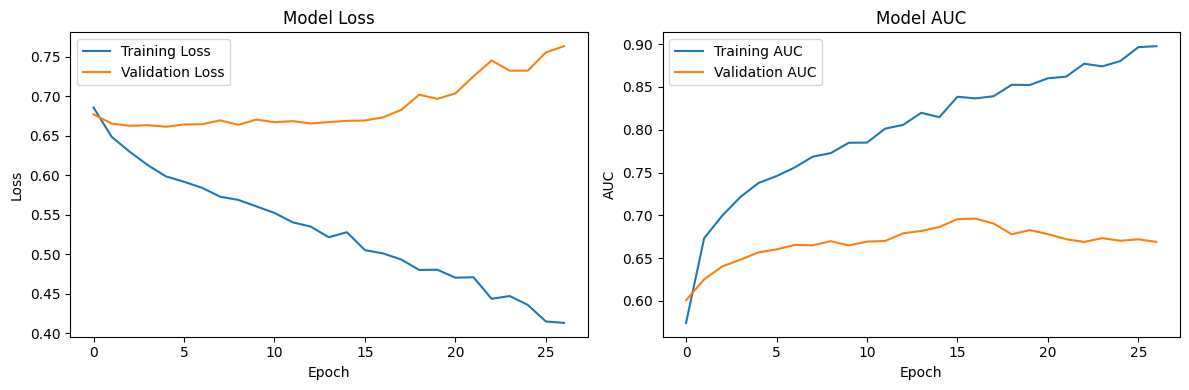

2025-01-17 14:38:22,864 - INFO - AUC, Logging: 0.7040983606557376


AUC: 0.7040983606557376
Loading split data for NoLabs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.5558 - loss: 0.6787 - val_auc: 0.6523 - val_loss: 0.6628
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.6932 - loss: 0.6279 - val_auc: 0.6638 - val_loss: 0.6487
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7135 - loss: 0.6146 - val_auc: 0.6732 - val_loss: 0.6404
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7304 - loss: 0.5988 - val_auc: 0.6829 - val_loss: 0.6358
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7370 - loss: 0.5909 - val_auc: 0.6900 - val_loss: 0.6321
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7633 - loss: 0.5721 - val_auc: 0.6884 - val_loss: 0.6354
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7632 - loss: 0.5619 - val_auc: 0.6891 - val_loss: 0.6354
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7702 - loss: 0.5570 - val_auc: 0.6882 - val_loss: 0.6363
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7829 - loss: 0.5442 - val_auc: 0.6874 - val_loss: 0.6410
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7702 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

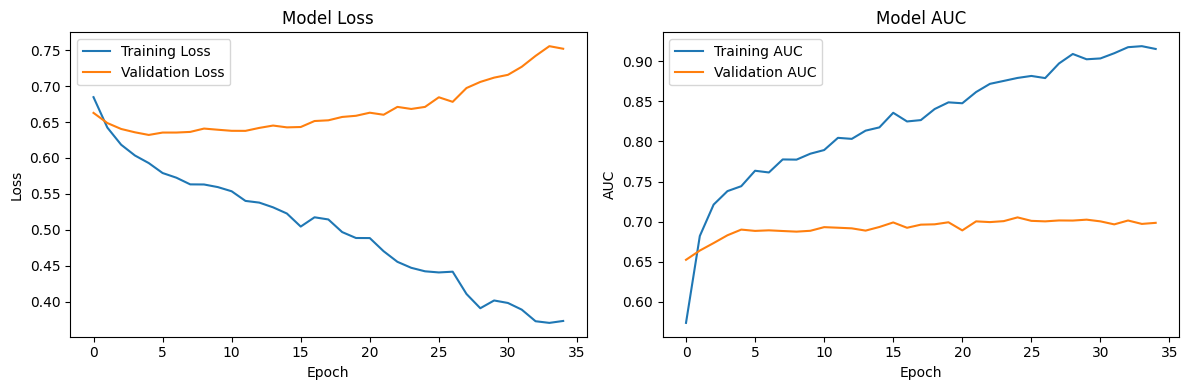

2025-01-17 14:40:31,643 - INFO - AUC, Logging: 0.6763433515482695


AUC: 0.6763433515482695
Loading split data for NoLabs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - auc: 0.5497 - loss: 0.6814

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.5502 - loss: 0.6816 - val_auc: 0.6572 - val_loss: 0.6608
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7032 - loss: 0.6330 - val_auc: 0.6676 - val_loss: 0.6467
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7267 - loss: 0.6113 - val_auc: 0.6770 - val_loss: 0.6365
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7478 - loss: 0.5892 - val_auc: 0.6774 - val_loss: 0.6305
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7356 - loss: 0.5946 - val_auc: 0.6982 - val_loss: 0.6199
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7745 - loss: 0.5697 - val_auc: 0.7175 - val_loss: 0.6128
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7916 - loss: 0.5536 - val_auc: 0.7178 - val_loss: 0.6114
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7954 - loss: 0.5474 - val_auc: 0.7122 - val_loss: 0.6134
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.8089 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

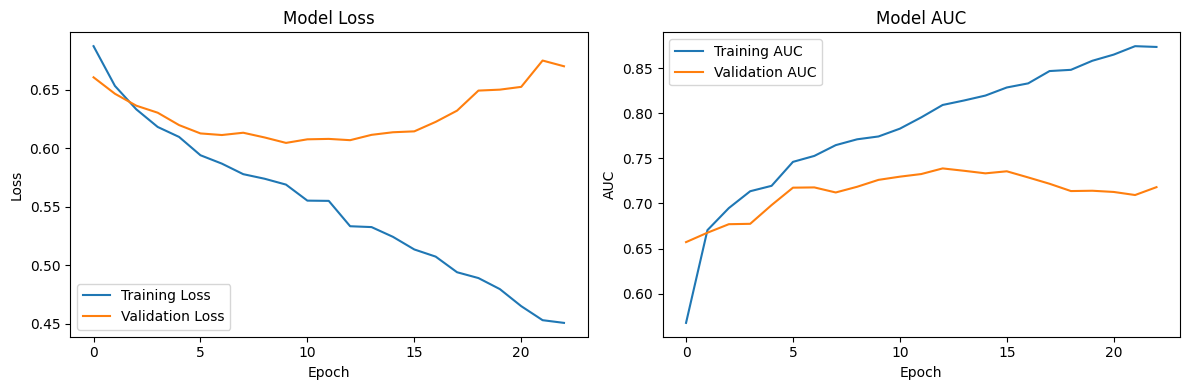

2025-01-17 14:41:55,257 - INFO - AUC, Logging: 0.7176704199291468


AUC: 0.7176704199291468
Loading split data for NoLabs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.4984 - loss: 0.7092

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.4993 - loss: 0.7090 - val_auc: 0.6375 - val_loss: 0.6713
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.6519 - loss: 0.6630 - val_auc: 0.6684 - val_loss: 0.6516
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7229 - loss: 0.6215 - val_auc: 0.6768 - val_loss: 0.6378
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7265 - loss: 0.6113 - val_auc: 0.6842 - val_loss: 0.6329
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - auc: 0.7340 - loss: 0.5960 - val_auc: 0.6915 - val_loss: 0.6323
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7432 - loss: 0.5871 - val_auc: 0.6952 - val_loss: 0.6341
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7429 - loss: 0.5854 - val_auc: 0.7032 - val_loss: 0.6366
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7603 - loss: 0.5775 - val_auc: 0.7044 - val_loss: 0.6288
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7876 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

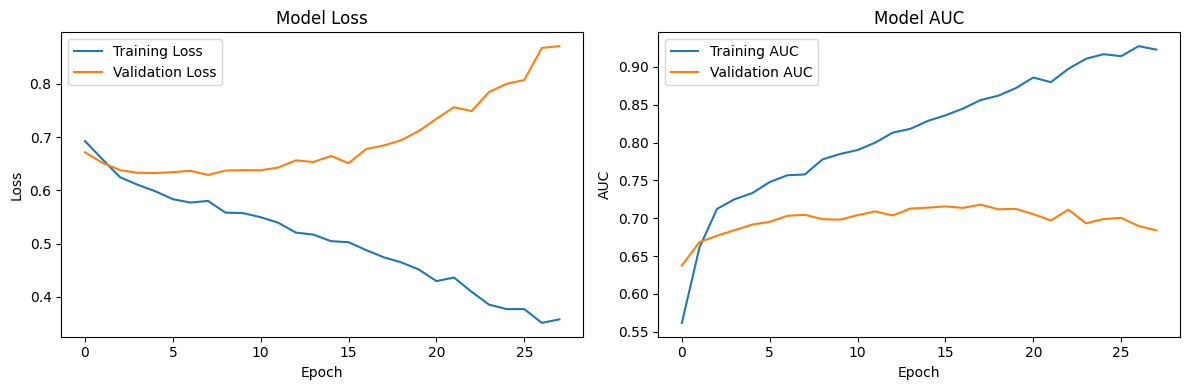

2025-01-17 14:43:34,741 - INFO - AUC, Logging: 0.7144353369763204


AUC: 0.7144353369763204
Loading split data for NoLabs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.5364 - loss: 0.6991

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5371 - loss: 0.6989 - val_auc: 0.6327 - val_loss: 0.6705
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6375 - loss: 0.6616 - val_auc: 0.6456 - val_loss: 0.6607
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7086 - loss: 0.6284 - val_auc: 0.6693 - val_loss: 0.6463
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6997 - loss: 0.6354 - val_auc: 0.6769 - val_loss: 0.6417
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7255 - loss: 0.6123 - val_auc: 0.6734 - val_loss: 0.6450
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.7264 - loss: 0.6100 - val_auc: 0.6678 - val_loss: 0.6507
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7403 - loss: 0.6015 - val_auc: 0.6683 - val_loss: 0.6528
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7507 - loss: 0.5955 - val_auc: 0.6657 - val_loss: 0.6530
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7622 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

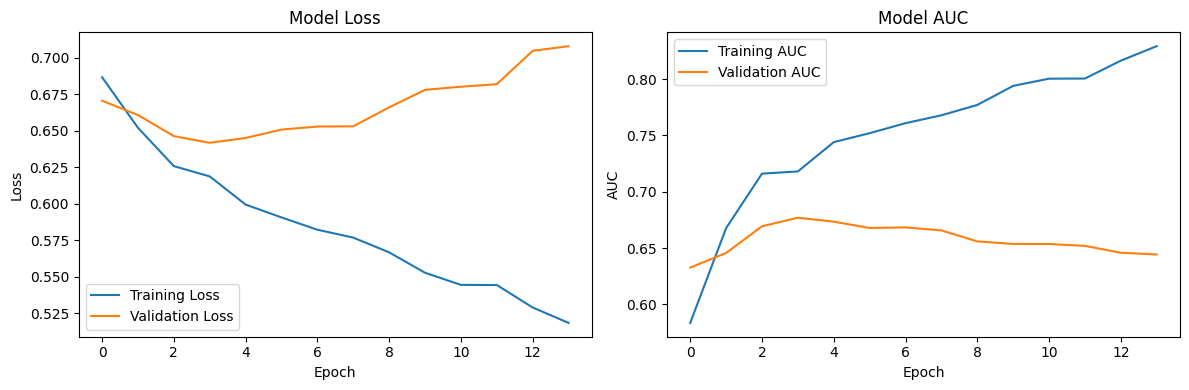

2025-01-17 14:44:27,410 - INFO - AUC, Logging: 0.7216302367941713


AUC: 0.7216302367941713
Loading split data for NoLabs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.5037 - loss: 0.7087

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.5045 - loss: 0.7085 - val_auc: 0.6227 - val_loss: 0.6758
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6592 - loss: 0.6592 - val_auc: 0.6531 - val_loss: 0.6578
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7183 - loss: 0.6211 - val_auc: 0.6765 - val_loss: 0.6358
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7239 - loss: 0.6169 - val_auc: 0.6879 - val_loss: 0.6276
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7405 - loss: 0.6028 - val_auc: 0.6988 - val_loss: 0.6216
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7561 - loss: 0.5904 - val_auc: 0.7082 - val_loss: 0.6149
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7459 - loss: 0.5911 - val_auc: 0.7010 - val_loss: 0.6202
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7627 - loss: 0.5889 - val_auc: 0.7114 - val_loss: 0.6191
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.7792 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

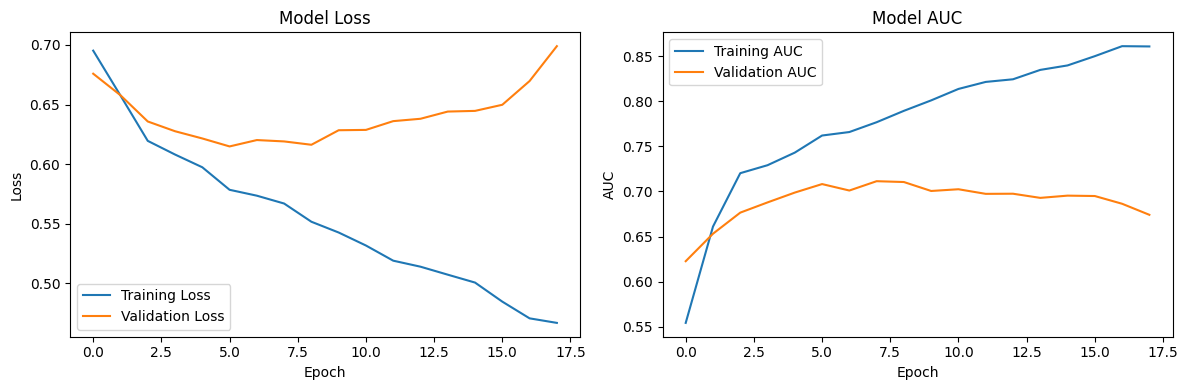

2025-01-17 14:45:34,801 - INFO - AUC, Logging: 0.71709927140255


AUC: 0.71709927140255
Loading split data for NoLabs, Fusion, rep 7 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.5221 - loss: 0.6997

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5228 - loss: 0.6995 - val_auc: 0.6492 - val_loss: 0.6666
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - auc: 0.6494 - loss: 0.6609 - val_auc: 0.6711 - val_loss: 0.6466
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7097 - loss: 0.6262 - val_auc: 0.6820 - val_loss: 0.6287
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7143 - loss: 0.6170 - val_auc: 0.6927 - val_loss: 0.6235
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7281 - loss: 0.5990 - val_auc: 0.6995 - val_loss: 0.6153
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7474 - loss: 0.5855 - val_auc: 0.7059 - val_loss: 0.6129
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7675 - loss: 0.5691 - val_auc: 0.7066 - val_loss: 0.6125
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7619 - loss: 0.5759 - val_auc: 0.7083 - val_loss: 0.6109
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7954 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

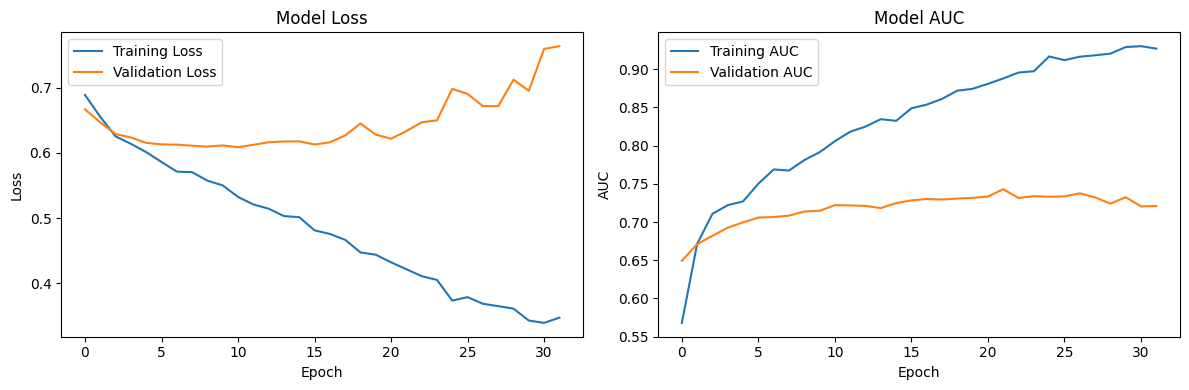

2025-01-17 14:47:32,204 - INFO - AUC, Logging: 0.6954690346083789


AUC: 0.6954690346083789
Loading split data for NoLabs, Fusion, rep 7 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - auc: 0.5085 - loss: 0.7055

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5091 - loss: 0.7054 - val_auc: 0.6894 - val_loss: 0.6624
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.6502 - loss: 0.6625 - val_auc: 0.7225 - val_loss: 0.6409
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7070 - loss: 0.6310 - val_auc: 0.7385 - val_loss: 0.6155
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7228 - loss: 0.6187 - val_auc: 0.7447 - val_loss: 0.6028
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7107 - loss: 0.6205 - val_auc: 0.7512 - val_loss: 0.5987
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7572 - loss: 0.5861 - val_auc: 0.7548 - val_loss: 0.5897
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7612 - loss: 0.5839 - val_auc: 0.7487 - val_loss: 0.5903
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7565 - loss: 0.5861 - val_auc: 0.7468 - val_loss: 0.5906
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7786 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

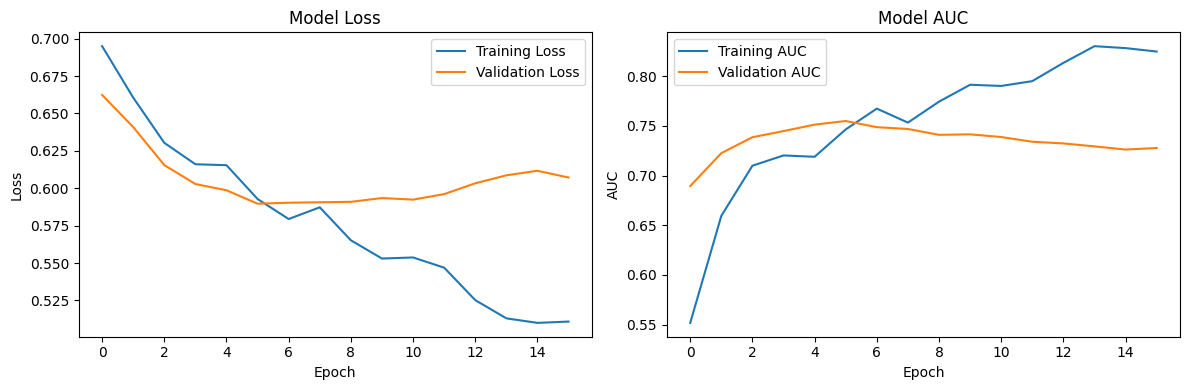

2025-01-17 14:48:30,500 - INFO - AUC, Logging: 0.7038156914953629


AUC: 0.7038156914953629
Loading split data for NoLabs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - auc: 0.5151 - loss: 0.6938

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.5160 - loss: 0.6938 - val_auc: 0.6274 - val_loss: 0.6785
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6343 - loss: 0.6693 - val_auc: 0.6578 - val_loss: 0.6625
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7042 - loss: 0.6373 - val_auc: 0.6691 - val_loss: 0.6516
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7119 - loss: 0.6216 - val_auc: 0.6745 - val_loss: 0.6446
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - auc: 0.7272 - loss: 0.6064 - val_auc: 0.6808 - val_loss: 0.6432
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7372 - loss: 0.5976 - val_auc: 0.6913 - val_loss: 0.6382
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7450 - loss: 0.5866 - val_auc: 0.6757 - val_loss: 0.6529
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7757 - loss: 0.5626 - val_auc: 0.6740 - val_loss: 0.6516
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7643 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

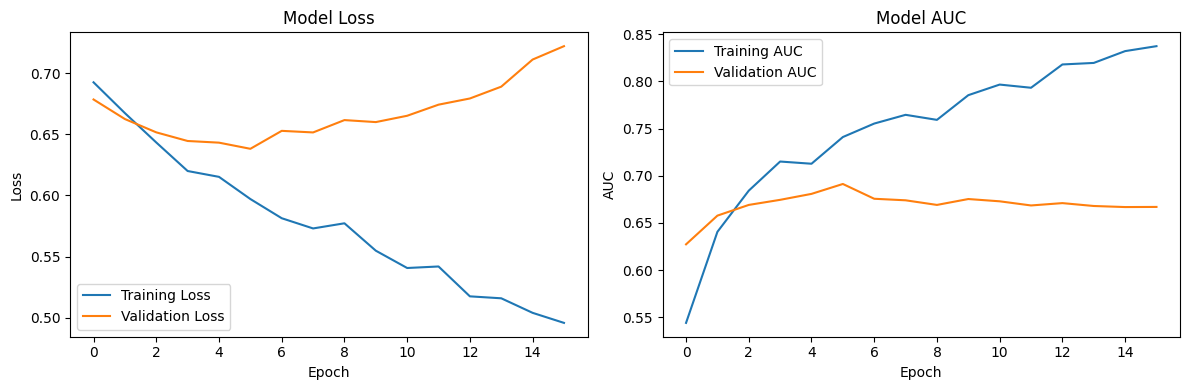

2025-01-17 14:49:28,130 - INFO - AUC, Logging: 0.725068306010929


AUC: 0.725068306010929
Loading split data for NoLabs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - auc: 0.5563 - loss: 0.6862 - val_auc: 0.6409 - val_loss: 0.6736
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.6624 - loss: 0.6594 - val_auc: 0.6874 - val_loss: 0.6497
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7339 - loss: 0.6231 - val_auc: 0.7238 - val_loss: 0.6248
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7252 - loss: 0.6140 - val_auc: 0.7306 - val_loss: 0.6118
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - auc: 0.7491 - loss: 0.5889 - val_auc: 0.7380 - val_loss: 0.6035
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7523 - loss: 0.5869 - val_auc: 0.7403 - val_loss: 0.5978
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7702 - loss: 0.5693 - val_auc: 0.7474 - val_loss: 0.5919
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7772 - loss: 0.5627 - val_auc: 0.7524 - val_loss: 0.5907
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7842 - loss: 0.5521 - val_auc: 0.7515 - val_loss: 0.5890
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.8032 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

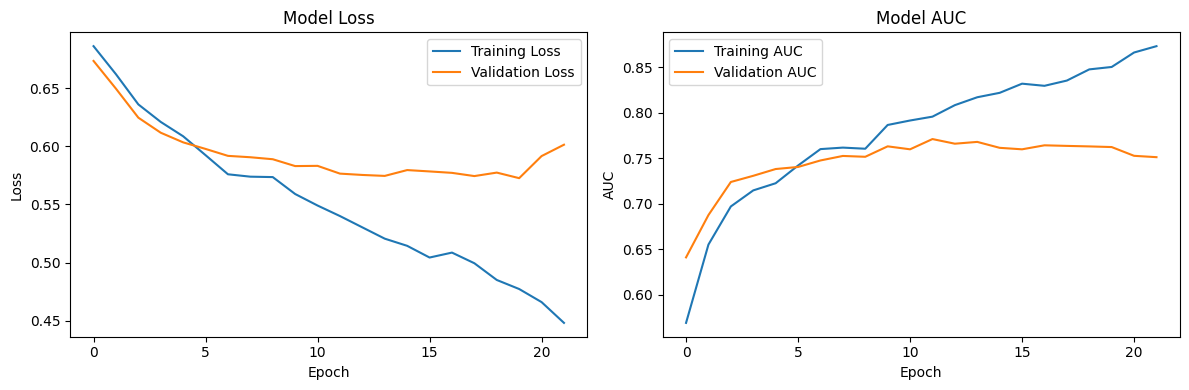

2025-01-17 14:50:52,201 - INFO - AUC, Logging: 0.6550774134790529


AUC: 0.6550774134790529
Loading split data for NoLabs, Fusion, rep 8 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - auc: 0.5611 - loss: 0.6865

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - auc: 0.5612 - loss: 0.6866 - val_auc: 0.6631 - val_loss: 0.6663
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - auc: 0.6672 - loss: 0.6577 - val_auc: 0.6837 - val_loss: 0.6485
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7269 - loss: 0.6221 - val_auc: 0.6918 - val_loss: 0.6349
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7349 - loss: 0.6069 - val_auc: 0.6957 - val_loss: 0.6295
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7598 - loss: 0.5861 - val_auc: 0.6891 - val_loss: 0.6329
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7517 - loss: 0.5844 - val_auc: 0.6963 - val_loss: 0.6385
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.7615 - loss: 0.5707 - val_auc: 0.6851 - val_loss: 0.6510
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7837 - loss: 0.5606 - val_auc: 0.6860 - val_loss: 0.6520
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7877 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

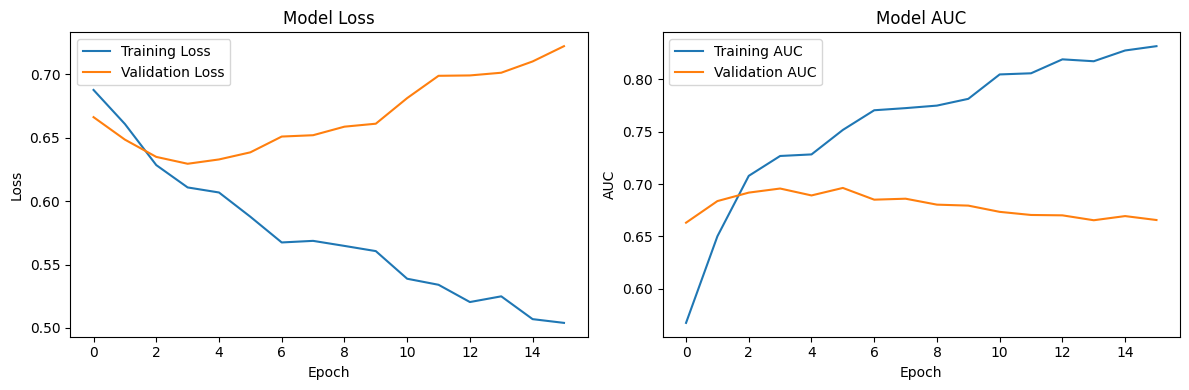

2025-01-17 14:52:00,593 - INFO - AUC, Logging: 0.6633652094717669


AUC: 0.6633652094717669
Loading split data for NoLabs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - auc: 0.5285 - loss: 0.6964

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.5290 - loss: 0.6963 - val_auc: 0.6798 - val_loss: 0.6661
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6324 - loss: 0.6696 - val_auc: 0.7228 - val_loss: 0.6443
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6803 - loss: 0.6472 - val_auc: 0.7265 - val_loss: 0.6288
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.6927 - loss: 0.6331 - val_auc: 0.7374 - val_loss: 0.6118
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7183 - loss: 0.6178 - val_auc: 0.7320 - val_loss: 0.6082
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7275 - loss: 0.6079 - val_auc: 0.7345 - val_loss: 0.6052
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7381 - loss: 0.5970 - val_auc: 0.7341 - val_loss: 0.6010
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7588 - loss: 0.5806 - val_auc: 0.7321 - val_loss: 0.6004
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.7526 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

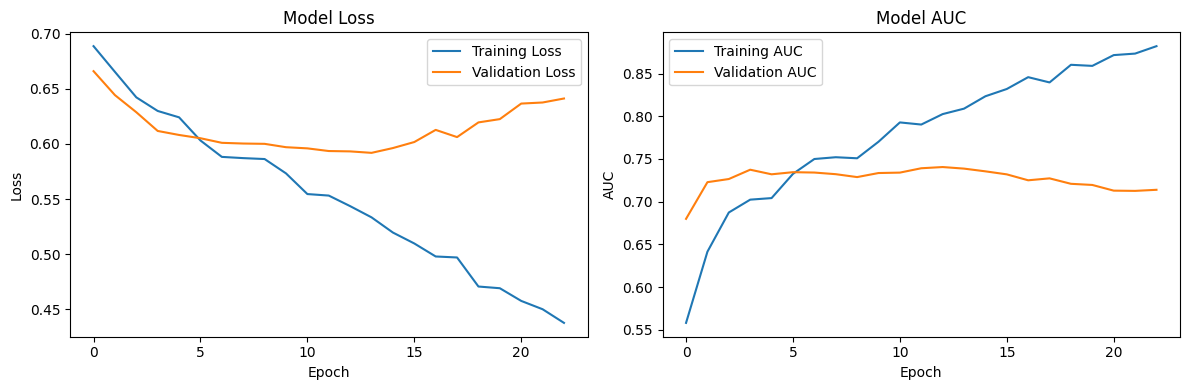

2025-01-17 14:53:33,452 - INFO - AUC, Logging: 0.717827868852459


AUC: 0.717827868852459
Loading split data for NoLabs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.5431 - loss: 0.7040 - val_auc: 0.6010 - val_loss: 0.6825
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.6502 - loss: 0.6740 - val_auc: 0.6448 - val_loss: 0.6683
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6742 - loss: 0.6599 - val_auc: 0.6592 - val_loss: 0.6562
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.6969 - loss: 0.6436 - val_auc: 0.6697 - val_loss: 0.6540
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.7047 - loss: 0.6305 - val_auc: 0.6718 - val_loss: 0.6592
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - auc: 0.7324 - loss: 0.6111 - val_auc: 0.6754 - val_loss: 0.6646
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7483 - loss: 0.5975 - val_auc: 0.6721 - val_loss: 0.6747
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7501 - loss: 0.5882 - val_auc: 0.6682 - val_loss: 0.6785
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7442 - loss: 0.5996 - val_auc: 0.6631 - val_loss: 0.6923
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7835 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

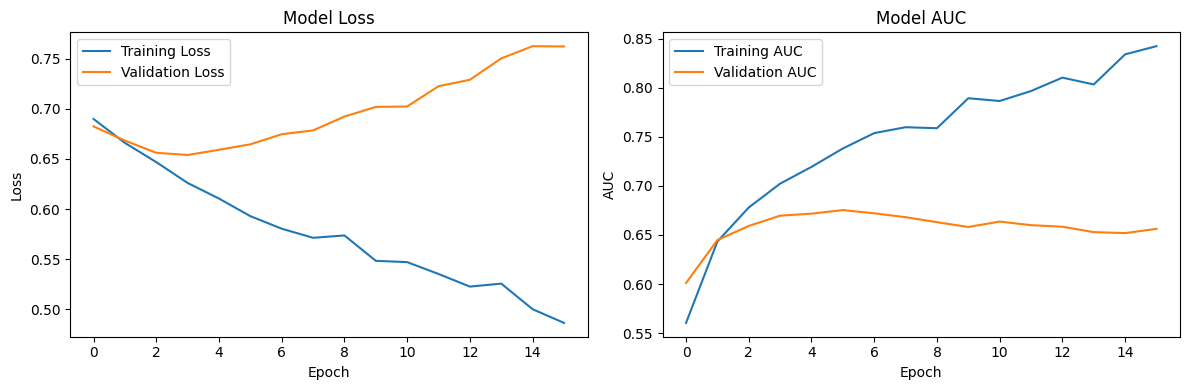

2025-01-17 14:54:37,536 - INFO - AUC, Logging: 0.7468917119841143


AUC: 0.7468917119841143
Loading split data for NoLabs, Fusion, rep 9 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - auc: 0.5031 - loss: 0.7013

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.5036 - loss: 0.7013 - val_auc: 0.6593 - val_loss: 0.6717
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6580 - loss: 0.6515 - val_auc: 0.6914 - val_loss: 0.6547
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.6991 - loss: 0.6293 - val_auc: 0.6947 - val_loss: 0.6454
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - auc: 0.7255 - loss: 0.6074 - val_auc: 0.6891 - val_loss: 0.6537
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - auc: 0.7306 - loss: 0.6001 - val_auc: 0.6871 - val_loss: 0.6644
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7508 - loss: 0.5802 - val_auc: 0.6850 - val_loss: 0.6796
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7755 - loss: 0.5573 - val_auc: 0.6891 - val_loss: 0.6858
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - auc: 0.7714 - loss: 0.5628 - val_auc: 0.6878 - val_loss: 0.6927
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - auc: 0.7825 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

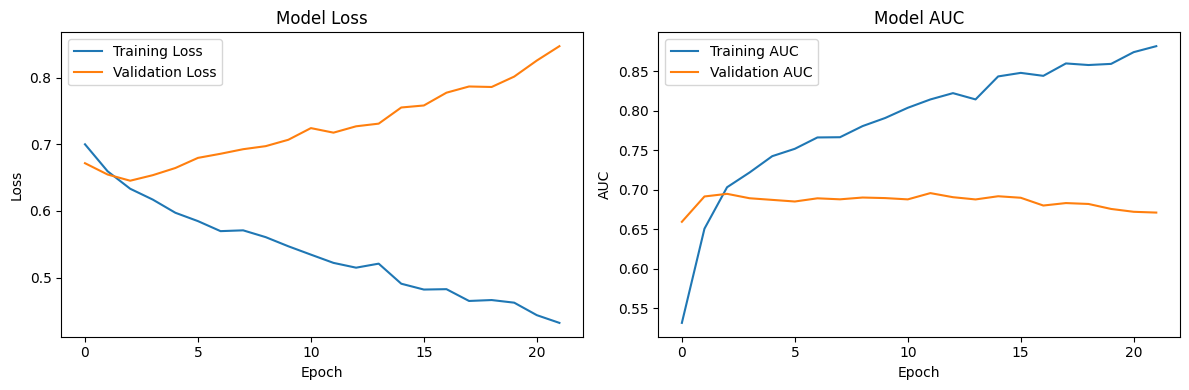

2025-01-17 14:56:12,525 - INFO - AUC, Logging: 0.695127504553734


AUC: 0.695127504553734
Loading split data for NoLabs, Fusion, rep 9 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - auc: 0.5132 - loss: 0.7010 - val_auc: 0.5952 - val_loss: 0.6830
Epoch 2/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.6567 - loss: 0.6519 - val_auc: 0.6507 - val_loss: 0.6636
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7147 - loss: 0.6237 - val_auc: 0.6696 - val_loss: 0.6472
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.7616 - loss: 0.5892 - val_auc: 0.6664 - val_loss: 0.6456
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7654 - loss: 0.5756 - val_auc: 0.6701 - val_loss: 0.6450
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - auc: 0.7831 - loss: 0.5591 - val_auc: 0.6735 - val_loss: 0.6418
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7932 - loss: 0.5433 - val_auc: 0.6787 - val_loss: 0.6425
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7861 - loss: 0.5446 - val_auc: 0.6782 - val_loss: 0.6535
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8101 - loss: 0.5218 - val_auc: 0.6712 - val_loss: 0.6633
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.8067 -

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

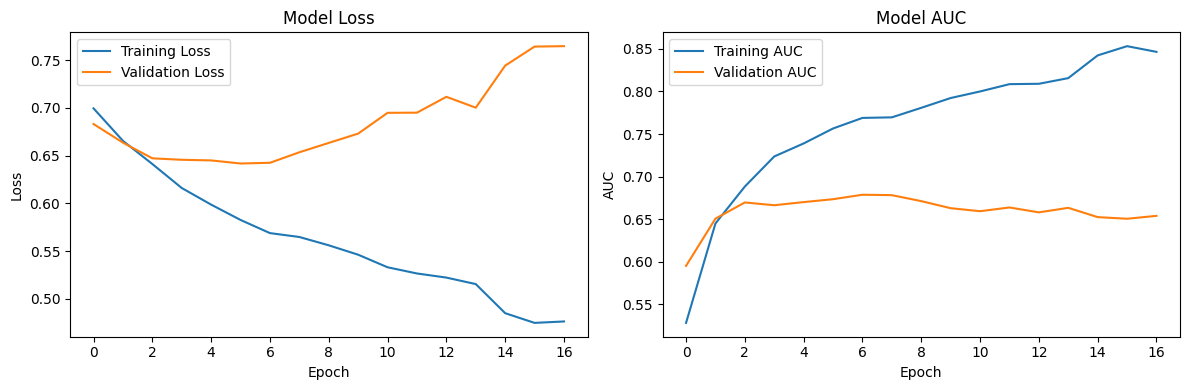

2025-01-17 14:57:18,108 - INFO - AUC, Logging: 0.7128415300546449


AUC: 0.7128415300546449
Loading split data for NoLabs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - auc: 0.4863 - loss: 0.7052

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.4866 - loss: 0.7052 - val_auc: 0.5431 - val_loss: 0.6903
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - auc: 0.6016 - loss: 0.6692 - val_auc: 0.6681 - val_loss: 0.6600
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.6418 - loss: 0.6518 - val_auc: 0.6988 - val_loss: 0.6371
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - auc: 0.7026 - loss: 0.6258 - val_auc: 0.7207 - val_loss: 0.6181
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - auc: 0.7036 - loss: 0.6185 - val_auc: 0.7322 - val_loss: 0.6056
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7393 - loss: 0.5946 - val_auc: 0.7367 - val_loss: 0.6031
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7383 - loss: 0.5908 - val_auc: 0.7345 - val_loss: 0.5965
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - auc: 0.7469 - loss: 0.5846 - val_auc: 0.7350 - val_loss: 0.5962
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7592 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

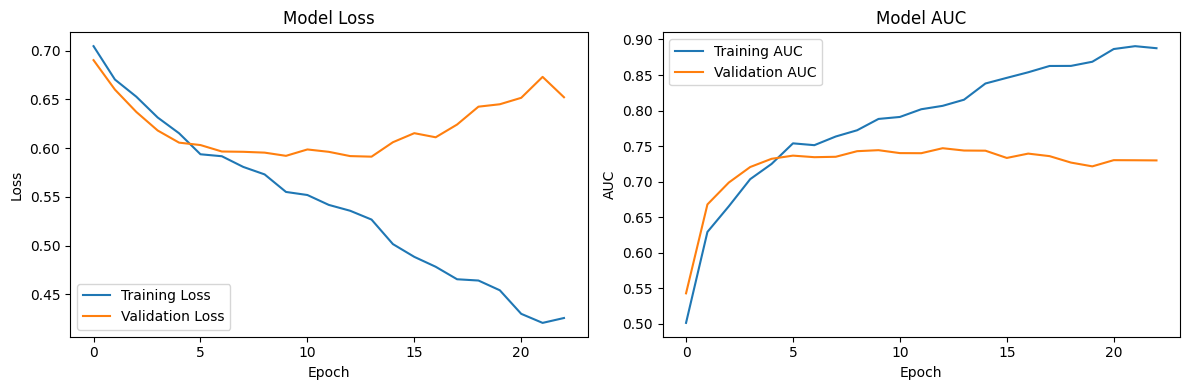

2025-01-17 14:58:44,429 - INFO - AUC, Logging: 0.7406648451730418


AUC: 0.7406648451730418
Loading split data for NoLabs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - auc: 0.4938 - loss: 0.7032

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - auc: 0.4942 - loss: 0.7032 - val_auc: 0.5993 - val_loss: 0.6792
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - auc: 0.5993 - loss: 0.6665 - val_auc: 0.6645 - val_loss: 0.6601
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.6852 - loss: 0.6374 - val_auc: 0.6725 - val_loss: 0.6502
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - auc: 0.7310 - loss: 0.6103 - val_auc: 0.6728 - val_loss: 0.6458
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - auc: 0.7483 - loss: 0.5919 - val_auc: 0.6704 - val_loss: 0.6535
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7531 - loss: 0.5816 - val_auc: 0.6758 - val_loss: 0.6544
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - auc: 0.7680 - loss: 0.5666 - val_auc: 0.6812 - val_loss: 0.6505
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - auc: 0.7598 - loss: 0.5723 - val_auc: 0.6864 - val_loss: 0.6491
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - auc: 0.7902 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

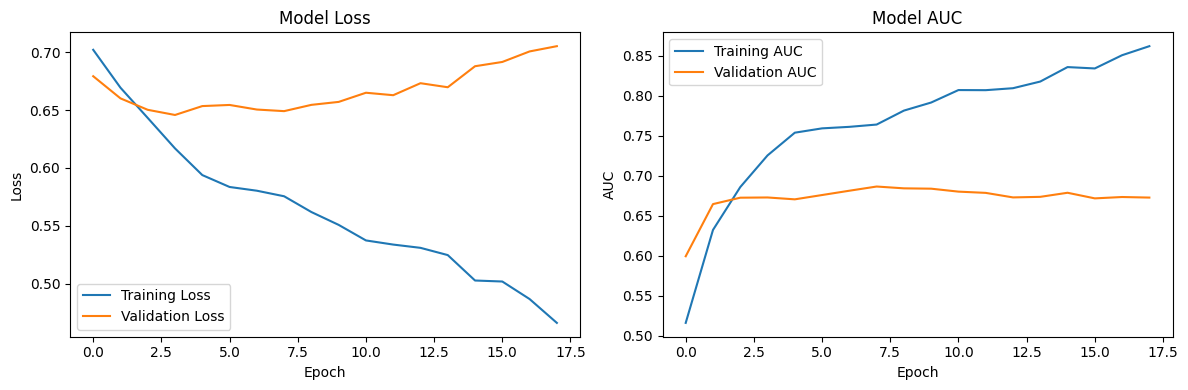

2025-01-17 15:00:23,439 - INFO - AUC, Logging: 0.7450364298724955


AUC: 0.7450364298724955
Loading split data for NoLabs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4
Epoch 1/100


/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of t

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - auc: 0.4801 - loss: 0.7097

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - auc: 0.4807 - loss: 0.7096 - val_auc: 0.6324 - val_loss: 0.6767
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - auc: 0.6402 - loss: 0.6563 - val_auc: 0.6922 - val_loss: 0.6524
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7031 - loss: 0.6279 - val_auc: 0.7125 - val_loss: 0.6319
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7206 - loss: 0.6074 - val_auc: 0.7077 - val_loss: 0.6247
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - auc: 0.7469 - loss: 0.5901 - val_auc: 0.7049 - val_loss: 0.6242
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - auc: 0.7881 - loss: 0.5531 - val_auc: 0.6923 - val_loss: 0.6296
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7824 - loss: 0.5529 - val_auc: 0.6902 - val_loss: 0.6296
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - auc: 0.7931 - loss: 0.5439 - val_auc: 0.6852 - val_loss: 0.6343
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - auc: 0.8026 - 

/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Model: "DeepNN_CLF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ h1 (Dense)                      │ (None, 40)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ h2 (Dense)                      │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,125 (47.37 KB)

 Trainable params: 4,041 (15.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,084 (31.58 KB)

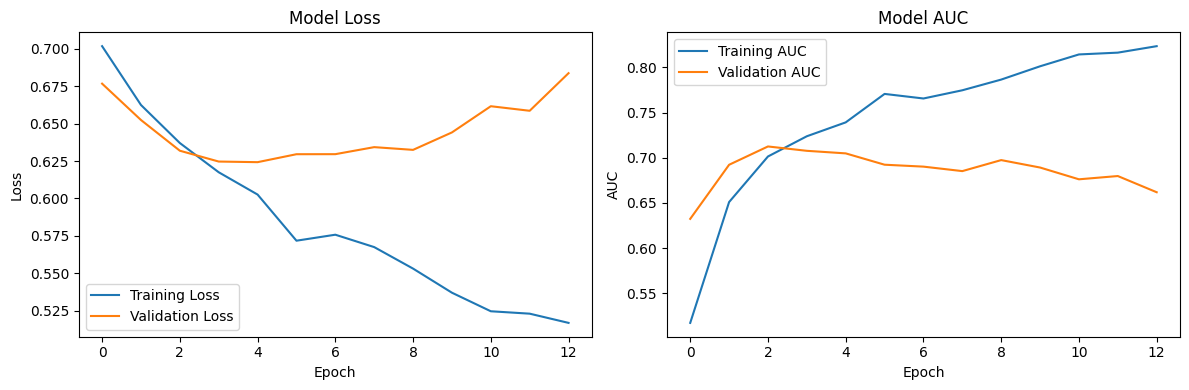

2025-01-17 15:01:14,186 - INFO - AUC, Logging: 0.669742988018142


AUC: 0.669742988018142


In [66]:
NN_start_time = time.time()
NN_results, NN_auc_results = NN_model_train_test(procedure_of_interest)
log_execution(csv_path, 'NN', NN_start_time)


#### NN Save

In [67]:
NN_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_NN_" + "auc_data.csv")
NN_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_NN_"+ "model_results.csv")

### Linear SVC

In [58]:
## SVC
def linear_svc_train_test(procedure):
    
    SVC_results_list = []
    SVC_auc_list = []
    SVC_shap_full_list = []
    SVC_shap_summary_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            LinSVC_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = LinSVC_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            SVC_model_fitted, y_pred, y_prob_vec, shap_values = Linear_SVC_model(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(SVC_results_list, SVC_auc_list, outcome, procedure, feature,
                            "LinearSVC", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            if Get_shaps:
                print("Collecting Shaps")
                collect_shap_results(SVC_shap_full_list, SVC_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure, feature, "LinearSVC",
                                    rep, i)
            else:
                print("Not Collecting Shaps")
            
            LinSVC_temp_results = pd.concat(SVC_results_list, ignore_index=True)
            LinSVC_temp_auc_results = pd.concat(SVC_auc_list, ignore_index=True)
            LinSVC_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_SVC_" + "auc_data.csv")
            LinSVC_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+ "model_results.csv")

            if Get_shaps:
                print("Saving temp shaps")
                LinSVC_temp_shap_long_results = pd.concat(SVC_shap_full_list, ignore_index=True)
                LinSVC_temp_shap_summary_results = pd.concat(SVC_shap_summary_list, ignore_index=True)
                LinSVC_temp_shap_long_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+"feature_importance_full.csv")
                LinSVC_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_SVC_"+"feature_importance.csv")
            else:
                print("Not saving temp shaps")
            
            
            

    SVC_results = pd.concat(SVC_results_list, ignore_index=True)
    SVC_auc_results = pd.concat(SVC_auc_list, ignore_index=True)
    if Get_shaps:
        print("Saving final shaps")
        SVC_shap_long_results = pd.concat(SVC_shap_full_list, ignore_index=True)
        SVC_shap_summary_results = pd.concat(SVC_shap_summary_list, ignore_index=True)
    else:
        print("NOT saving final shaps")
        SVC_shap_long_results = None
        SVC_shap_summary_results = None

    return SVC_results, SVC_auc_results, SVC_shap_long_results, SVC_shap_summary_results


#### LinSVC run

In [59]:
LinSVC_start_time = time.time()
LinSVC_results, LinSVC_auc_results, LinSVC_shap_long_results, LinSVC_shap_summary_results = linear_svc_train_test(procedure_of_interest)
log_execution(csv_path, 'LinSVC', LinSVC_start_time)

Loading split data for NoLabs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0


2025-01-17 12:30:58,474	INFO worker.py:1724 -- Started a local Ray instance.
2025-01-17 12:31:01,895	INFO tune.py:220 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.
2025-01-17 12:31:01,900	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(_Trainable pid=97591) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97591)   warnings.warn(


(_Trainable pid=97591) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97591)   warnings.warn(
(_Trainable pid=97591) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97591)   warnings.warn(
(_Trainable pid=97591) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97591)   warnings.warn(
(_Trainable pid=97591) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7484289617486339
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1


(_Trainable pid=97645) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97645)   warnings.warn(


(_Trainable pid=97645) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97645)   warnings.warn(
(_Trainable pid=97645) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97645)   warnings.warn(
(_Trainable pid=97645) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97645)   warnings.warn(
(_Trainable pid=97645) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7126138433515482
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2


(_Trainable pid=97671) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97671)   warnings.warn(


(_Trainable pid=97671) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97671)   warnings.warn(
(_Trainable pid=97671) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97671)   warnings.warn(
(_Trainable pid=97671) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97671)   warnings.warn(
(_Trainable pid=97671) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7217213114754099
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3


(_Trainable pid=97697) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97697)   warnings.warn(


(_Trainable pid=97697) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97697)   warnings.warn(
(_Trainable pid=97697) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97697)   warnings.warn(
(_Trainable pid=97697) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97697)   warnings.warn(
(_Trainable pid=97697) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7019581056466302
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4


(_Trainable pid=97719) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97719)   warnings.warn(


(_Trainable pid=97719) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97719)   warnings.warn(
(_Trainable pid=97719) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97719)   warnings.warn(
(_Trainable pid=97719) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97719)   warnings.warn(
(_Trainable pid=97719) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7110589615723086
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0


(_Trainable pid=97762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97762)   warnings.warn(


(_Trainable pid=97762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97762)   warnings.warn(
(_Trainable pid=97762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97762)   warnings.warn(
(_Trainable pid=97762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97762)   warnings.warn(
(_Trainable pid=97762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7147085610200363
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1


(_Trainable pid=97786) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97786)   warnings.warn(


(_Trainable pid=97786) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97786)   warnings.warn(
(_Trainable pid=97786) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97786)   warnings.warn(
(_Trainable pid=97786) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97786)   warnings.warn(
(_Trainable pid=97786) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7582650273224044
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2


(_Trainable pid=97803) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97803)   warnings.warn(


(_Trainable pid=97803) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97803)   warnings.warn(
(_Trainable pid=97803) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97803)   warnings.warn(
(_Trainable pid=97803) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97803)   warnings.warn(
(_Trainable pid=97803) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6862021857923498
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3


(_Trainable pid=97812) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97812)   warnings.warn(


(_Trainable pid=97812) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97812)   warnings.warn(
(_Trainable pid=97812) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97812)   warnings.warn(
(_Trainable pid=97812) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97812)   warnings.warn(
(_Trainable pid=97812) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7060336976320583
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4


(_Trainable pid=97825) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97825)   warnings.warn(


(_Trainable pid=97825) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97825)   warnings.warn(
(_Trainable pid=97825) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97825)   warnings.warn(
(_Trainable pid=97825) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97825)   warnings.warn(
(_Trainable pid=97825) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7361960421508676
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0


(_Trainable pid=97843) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97843)   warnings.warn(


(_Trainable pid=97843) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97843)   warnings.warn(
(_Trainable pid=97843) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97843)   warnings.warn(
(_Trainable pid=97843) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97843)   warnings.warn(
(_Trainable pid=97843) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7313752276867032
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1


(_Trainable pid=97943) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97943)   warnings.warn(


(_Trainable pid=97943) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97943)   warnings.warn(
(_Trainable pid=97943) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97943)   warnings.warn(
(_Trainable pid=97943) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=97943)   warnings.warn(
(_Trainable pid=97943) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6739298724954463
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2


(_Trainable pid=98056) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98056)   warnings.warn(


(_Trainable pid=98056) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98056)   warnings.warn(
(_Trainable pid=98056) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98056)   warnings.warn(
(_Trainable pid=98056) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98056)   warnings.warn(
(_Trainable pid=98056) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7203779599271403
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3


(_Trainable pid=98378) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98378)   warnings.warn(


(_Trainable pid=98378) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98378)   warnings.warn(
(_Trainable pid=98378) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98378)   warnings.warn(
(_Trainable pid=98378) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98378)   warnings.warn(
(_Trainable pid=98378) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7345400728597451
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4


(_Trainable pid=98554) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98554)   warnings.warn(


(_Trainable pid=98554) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98554)   warnings.warn(
(_Trainable pid=98554) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98554)   warnings.warn(
(_Trainable pid=98554) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98554)   warnings.warn(
(_Trainable pid=98554) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7199043256538123
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0


(_Trainable pid=98630) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98630)   warnings.warn(


(_Trainable pid=98630) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98630)   warnings.warn(
(_Trainable pid=98630) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98630)   warnings.warn(
(_Trainable pid=98630) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98630)   warnings.warn(
(_Trainable pid=98630) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7114298724954462
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1


(_Trainable pid=98666) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98666)   warnings.warn(


(_Trainable pid=98666) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98666)   warnings.warn(
(_Trainable pid=98666) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98666)   warnings.warn(
(_Trainable pid=98666) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98666)   warnings.warn(
(_Trainable pid=98666) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7317395264116575
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 3 and fold 2


2025-01-17 12:35:11,643	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2


(_Trainable pid=98772) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98772)   warnings.warn(


(_Trainable pid=98772) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98772)   warnings.warn(
(_Trainable pid=98772) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98772)   warnings.warn(
(_Trainable pid=98772) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98772)   warnings.warn(
(_Trainable pid=98772) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7255236794171218
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3


(_Trainable pid=98813) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98813)   warnings.warn(


(_Trainable pid=98813) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98813)   warnings.warn(
(_Trainable pid=98813) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98813)   warnings.warn(
(_Trainable pid=98813) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98813)   warnings.warn(
(_Trainable pid=98813) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7342668488160291
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4


(_Trainable pid=98836) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98836)   warnings.warn(


(_Trainable pid=98836) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98836)   warnings.warn(
(_Trainable pid=98836) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98836)   warnings.warn(
(_Trainable pid=98836) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98836)   warnings.warn(
(_Trainable pid=98836) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7044926326240495
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0


(_Trainable pid=98846) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98846)   warnings.warn(


(_Trainable pid=98846) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98846)   warnings.warn(
(_Trainable pid=98846) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98846)   warnings.warn(
(_Trainable pid=98846) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98846)   warnings.warn(
(_Trainable pid=98846) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7237932604735883
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1


(_Trainable pid=98874) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98874)   warnings.warn(


(_Trainable pid=98874) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98874)   warnings.warn(
(_Trainable pid=98874) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98874)   warnings.warn(
(_Trainable pid=98874) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98874)   warnings.warn(
(_Trainable pid=98874) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7512295081967213
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2


(_Trainable pid=98884) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98884)   warnings.warn(


(_Trainable pid=98884) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98884)   warnings.warn(
(_Trainable pid=98884) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98884)   warnings.warn(
(_Trainable pid=98884) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98884)   warnings.warn(
(_Trainable pid=98884) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7098816029143898
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3


(_Trainable pid=98894) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98894)   warnings.warn(


(_Trainable pid=98894) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98894)   warnings.warn(
(_Trainable pid=98894) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98894)   warnings.warn(
(_Trainable pid=98894) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98894)   warnings.warn(
(_Trainable pid=98894) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6879553734061932
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 4 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4


(_Trainable pid=98905) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98905)   warnings.warn(


(_Trainable pid=98905) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98905)   warnings.warn(
(_Trainable pid=98905) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98905)   warnings.warn(
(_Trainable pid=98905) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98905)   warnings.warn(
(_Trainable pid=98905) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7139021143127919
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0


(_Trainable pid=98945) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98945)   warnings.warn(


(_Trainable pid=98945) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98945)   warnings.warn(
(_Trainable pid=98945) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98945)   warnings.warn(
(_Trainable pid=98945) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98945)   warnings.warn(
(_Trainable pid=98945) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7191939890710383
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1


(_Trainable pid=98958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98958)   warnings.warn(


(_Trainable pid=98958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98958)   warnings.warn(
(_Trainable pid=98958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98958)   warnings.warn(
(_Trainable pid=98958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98958)   warnings.warn(
(_Trainable pid=98958) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7239071038251366
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2


(_Trainable pid=98991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98991)   warnings.warn(


(_Trainable pid=98991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98991)   warnings.warn(
(_Trainable pid=98991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98991)   warnings.warn(
(_Trainable pid=98991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=98991)   warnings.warn(
(_Trainable pid=98991) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7376138433515482
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 5 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3


(_Trainable pid=99021) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99021)   warnings.warn(


(_Trainable pid=99021) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99021)   warnings.warn(
(_Trainable pid=99021) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99021)   warnings.warn(
(_Trainable pid=99021) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99021)   warnings.warn(
(_Trainable pid=99021) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7123406193078323
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4


(_Trainable pid=99065) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99065)   warnings.warn(


(_Trainable pid=99065) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99065)   warnings.warn(
(_Trainable pid=99065) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99065)   warnings.warn(
(_Trainable pid=99065) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99065)   warnings.warn(
(_Trainable pid=99065) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.695782656768283
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0


(_Trainable pid=99076) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99076)   warnings.warn(


(_Trainable pid=99076) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99076)   warnings.warn(
(_Trainable pid=99076) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99076)   warnings.warn(
(_Trainable pid=99076) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99076)   warnings.warn(
(_Trainable pid=99076) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7352003642987249
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1


(_Trainable pid=99093) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99093)   warnings.warn(


(_Trainable pid=99093) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99093)   warnings.warn(
(_Trainable pid=99093) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99093)   warnings.warn(
(_Trainable pid=99093) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99093)   warnings.warn(
(_Trainable pid=99093) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6967668488160291
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 6 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2


(_Trainable pid=99109) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99109)   warnings.warn(


(_Trainable pid=99109) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99109)   warnings.warn(
(_Trainable pid=99109) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99109)   warnings.warn(
(_Trainable pid=99109) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99109)   warnings.warn(
(_Trainable pid=99109) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7164617486338798
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3


(_Trainable pid=99129) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99129)   warnings.warn(


(_Trainable pid=99129) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99129)   warnings.warn(
(_Trainable pid=99129) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99129)   warnings.warn(
(_Trainable pid=99129) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99129)   warnings.warn(
(_Trainable pid=99129) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6710154826958106
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4


(_Trainable pid=99160) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99160)   warnings.warn(


(_Trainable pid=99160) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99160)   warnings.warn(
(_Trainable pid=99160) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99160)   warnings.warn(
(_Trainable pid=99160) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99160)   warnings.warn(
(_Trainable pid=99160) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7476137825213801
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0


(_Trainable pid=99186) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99186)   warnings.warn(


(_Trainable pid=99186) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99186)   warnings.warn(
(_Trainable pid=99186) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99186)   warnings.warn(
(_Trainable pid=99186) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99186)   warnings.warn(
(_Trainable pid=99186) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7218123861566483
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1


(_Trainable pid=99351) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99351)   warnings.warn(


(_Trainable pid=99351) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99351)   warnings.warn(
(_Trainable pid=99351) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99351)   warnings.warn(
(_Trainable pid=99351) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99351)   warnings.warn(
(_Trainable pid=99351) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7419626593806923
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2


(_Trainable pid=99380) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99380)   warnings.warn(


(_Trainable pid=99380) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99380)   warnings.warn(
(_Trainable pid=99380) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99380)   warnings.warn(
(_Trainable pid=99380) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99380)   warnings.warn(
(_Trainable pid=99380) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6937613843351548
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 7 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3


(_Trainable pid=99409) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99409)   warnings.warn(


(_Trainable pid=99409) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99409)   warnings.warn(
(_Trainable pid=99409) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99409)   warnings.warn(
(_Trainable pid=99409) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99409)   warnings.warn(
(_Trainable pid=99409) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7353597449908925
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 7 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4


(_Trainable pid=99434) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99434)   warnings.warn(


(_Trainable pid=99434) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99434)   warnings.warn(
(_Trainable pid=99434) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99434)   warnings.warn(
(_Trainable pid=99434) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99434)   warnings.warn(
(_Trainable pid=99434) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7321569600830381
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0


(_Trainable pid=99454) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99454)   warnings.warn(


(_Trainable pid=99454) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99454)   warnings.warn(
(_Trainable pid=99454) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99454)   warnings.warn(
(_Trainable pid=99454) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99454)   warnings.warn(
(_Trainable pid=99454) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7242486338797813
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1


(_Trainable pid=99481) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99481)   warnings.warn(


(_Trainable pid=99481) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99481)   warnings.warn(
(_Trainable pid=99481) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99481)   warnings.warn(
(_Trainable pid=99481) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99481)   warnings.warn(
(_Trainable pid=99481) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6559653916211293
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 8 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2


(_Trainable pid=99502) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99502)   warnings.warn(


(_Trainable pid=99502) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99502)   warnings.warn(
(_Trainable pid=99502) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99502)   warnings.warn(
(_Trainable pid=99502) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99502)   warnings.warn(
(_Trainable pid=99502) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6965846994535518
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3


(_Trainable pid=99528) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99528)   warnings.warn(


(_Trainable pid=99528) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99528)   warnings.warn(
(_Trainable pid=99528) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99528)   warnings.warn(
(_Trainable pid=99528) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99528)   warnings.warn(
(_Trainable pid=99528) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7349499089253188
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4


(raylet) [2025-01-17 12:42:25,970 E 97566 1530927] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-17_12-30-54_633697_97523 is over 95% full, available space: 24594165760; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=99579) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99579)   warnings.warn(


(_Trainable pid=99579) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99579)   warnings.warn(
(_Trainable pid=99579) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99579)   warnings.warn(
(_Trainable pid=99579) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99579)   warnings.warn(
(_Trainable pid=99579) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7589186993704446
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 9 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0


(_Trainable pid=99615) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99615)   warnings.warn(


(_Trainable pid=99615) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99615)   warnings.warn(
(_Trainable pid=99615) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99615)   warnings.warn(
(_Trainable pid=99615) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99615)   warnings.warn(
(_Trainable pid=99615) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.707559198542805
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 9 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1


(raylet) [2025-01-17 12:42:56,131 E 97566 1530927] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-17_12-30-54_633697_97523 is over 95% full, available space: 24615026688; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=99636) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99636)   warnings.warn(


(_Trainable pid=99636) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99636)   warnings.warn(
(_Trainable pid=99636) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99636)   warnings.warn(
(_Trainable pid=99636) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99636)   warnings.warn(
(_Trainable pid=99636) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7190346083788707
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2


(_Trainable pid=99668) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99668)   warnings.warn(


(_Trainable pid=99668) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99668)   warnings.warn(
(_Trainable pid=99668) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99668)   warnings.warn(
(_Trainable pid=99668) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99668)   warnings.warn(
(_Trainable pid=99668) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.7470856102003642
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3


(_Trainable pid=99728) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99728)   warnings.warn(


(_Trainable pid=99728) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99728)   warnings.warn(
(_Trainable pid=99728) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99728)   warnings.warn(
(_Trainable pid=99728) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99728)   warnings.warn(
(_Trainable pid=99728) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.740459927140255
Not Collecting Shaps
Not saving temp shaps
Loading split data for NoLabs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4


(raylet) [2025-01-17 12:43:40,544 E 97566 1530927] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2025-01-17_12-30-54_633697_97523 is over 95% full, available space: 24067051520; capacity: 499963174912. Object creation will fail if spilling is required.
(_Trainable pid=99762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99762)   warnings.warn(


(_Trainable pid=99762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99762)   warnings.warn(
(_Trainable pid=99762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99762)   warnings.warn(
(_Trainable pid=99762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99762)   warnings.warn(
(_Trainable pid=99762) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

NO SHAPS FOR YOU
AUC: 0.6880655279012569
Not Collecting Shaps
Not saving temp shaps
NOT saving final shaps


#### LinSVC Save

In [60]:
LinSVC_auc_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_" + "auc_data.csv")
LinSVC_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+ "model_results.csv")


In [61]:
if Get_shaps:
    print("Saving shap to csv")
    LinSVC_shap_summary_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+"feature_importance.csv")
    LinSVC_shap_long_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVC_"+"feature_importance_full.csv")
else:
    print("NOT saving shap to csv")

NOT saving shap to csv


### LinearSVC with Kernels


In [62]:
# Lin SVC w Kernels
#TODO: Fix Shap results collection with Nystroem
def LinSVC_Kernel_model_train_test(procedure):
    SVCKern_results_list = []
    SVCKern_auc_list = []
    SVCKern_shap_full_list = []
    SVCKern_shap_summary_list = []
    SVCKern_kernel_list = []

    for rep in repetitions:
        preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
        for i, (train_index, test_index) in enumerate(skf.split(df_preds, y)):
            # Create all the different train_test splits

            LinSVCKernel_split_data = load_split_data(rep, i)
            x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
            x_test_features_long, n_features, x_cols, x_train_std, x_test_std = LinSVCKernel_split_data

            print(f"Procedure: {procedure}")
            print(f"Feature: {feature}")
            print(f"Outcome: {outcome}")
            print(f"Rep: {rep}")
            print(f"TrainTest I: {i}")

            SVC_model_fitted, y_pred, y_prob_vec, shap_values, best_kernel = SVC_model_with_kernels(outcome, preprocessor, x_train, y_train,
                                                                            x_test, x_train_std, x_test_std, rep)
            
            collect_results(SVCKern_results_list, SVCKern_auc_list, outcome, procedure_of_interest, feature,
                            "LinSVC_Kernel", rep, i, n, label_n, y_test, y_prob_vec, y_pred)
            
            kernel_row = pd.DataFrame(
                {
                    "Procedure": [procedure],
                    "Outcome": [outcome],
                    "Features": [feature],
                    "Model": ["LinSVC_Kernel"],
                    "Rep": [rep],
                    "Fold": [i],
                    "Best_Kernel": [best_kernel]
                }
            )

            SVCKern_kernel_list.append(kernel_row)


            
            LinSVCKern_temp_results = pd.concat(SVCKern_results_list, ignore_index=True)
            LinSVCKern_temp_auc_results = pd.concat(SVCKern_auc_list, ignore_index=True)
            #RF_shap_full_results = pd.concat(RF_shap_full_list, ignore_index=True)
            #RF_temp_shap_summary_results = pd.concat(RF_shap_summary_list, ignore_index=True)
            
            LinSVCKern_temp_auc_results.to_csv("TEMP_" + procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKern_" + "auc_data.csv")
            LinSVCKern_temp_results.to_csv("TEMP_" +procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKern_"+ "model_results.csv")
            #RF_temp_shap_summary_results.to_csv("TEMP_" +procedure_of_interest+"_RF_"+"feature_importance.csv")
            
            
            '''
            collect_shap_results(SVCKern_shap_full_list, SVCKern_shap_summary_list, shap_values, 
                                    y_test, x_cols, x_test_features_long, outcome, procedure_of_interest, feature, "LinSVC_Kernel",
                                    rep, i)
            '''
            
            

    LinSVC_Kernel_results = pd.concat(SVCKern_results_list, ignore_index=True)
    LinSVC_Kernel_auc = pd.concat(SVCKern_auc_list, ignore_index=True)
    LinSVC_Kernel_kernels = pd.concat(SVCKern_kernel_list, ignore_index=True)
    #LinSVC_Kernel_shap_full = pd.concat(SVCKern_shap_full_list, ignore_index=True)
    #LinSVC_Kernel_shap_summary = pd.concat(SVCKern_shap_summary_list, ignore_index=True)

    return LinSVC_Kernel_results, LinSVC_Kernel_auc, LinSVC_Kernel_kernels

#### LinSVC Kernel Run

In [63]:
#LinSVC w/ Kernel no shap implementation right now TODO
import time
LinSVC_Kernel_start_time = time.time()
LinSVC_Kernel_results, LinSVC_Kernel_auc, LinSVC_Kernel_kernels = LinSVC_Kernel_model_train_test(procedure_of_interest)
log_execution(csv_path, "LinSVC_Kernel", LinSVC_Kernel_start_time)

2025-01-17 12:45:16,087	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Loading split data for NoLabs, Fusion, rep 0 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 0


(_Trainable pid=99948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99948)   warnings.warn(
(_Trainable pid=99948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99948)   warnings.warn(
(_Trainable pid=99948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
(_Trainable pid=99948)   warnings.warn(
(_Trainable pid=99948) /opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecate

2025-01-17 12:45:42,433	INFO tune.py:1042 -- Total run time: 26.35 seconds (21.50 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:45:42,775 - INFO - AUC, Logging: 0.7665983606557377
2025-01-17 12:45:42,871	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(177, 79)
NO SHAPS FOR YOU
AUC: 0.7665983606557377
Loading split data for NoLabs, Fusion, rep 0 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 1


2025-01-17 12:46:05,448	INFO tune.py:1042 -- Total run time: 22.58 seconds (20.43 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:46:05,618 - INFO - AUC, Logging: 0.7261612021857923
2025-01-17 12:46:05,665	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(177, 79)
NO SHAPS FOR YOU
AUC: 0.7261612021857923
Loading split data for NoLabs, Fusion, rep 0 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 2


2025-01-17 12:46:25,886	INFO tune.py:1042 -- Total run time: 20.22 seconds (15.90 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:46:26,062 - INFO - AUC, Logging: 0.734540072859745
2025-01-17 12:46:26,115	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(177, 79)
NO SHAPS FOR YOU
AUC: 0.734540072859745
Loading split data for NoLabs, Fusion, rep 0 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 3


2025-01-17 12:46:47,760	INFO tune.py:1042 -- Total run time: 21.65 seconds (17.51 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:46:47,932 - INFO - AUC, Logging: 0.696516393442623
2025-01-17 12:46:47,999	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(177, 79)
NO SHAPS FOR YOU
AUC: 0.696516393442623
Loading split data for NoLabs, Fusion, rep 0 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 0
TrainTest I: 4


2025-01-17 12:47:09,962	INFO tune.py:1042 -- Total run time: 21.96 seconds (17.72 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:47:10,144 - INFO - AUC, Logging: 0.7222059254913464
2025-01-17 12:47:10,220	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(177, 79)
NO SHAPS FOR YOU
AUC: 0.7222059254913464
Loading split data for NoLabs, Fusion, rep 1 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 0


2025-01-17 12:47:34,243	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-17 12:47:50,601	INFO tune.py:1042 -- Total run time: 40.38 seconds (40.36 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:47:50,775 - INFO - AUC, Logging: 0.7174180327868853
2025-01-17 12:47:50,844	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/369

Best kernel: rbf
<class 'numpy.ndarray'>
(192, 79)
NO SHAPS FOR YOU
AUC: 0.7174180327868853
Loading split data for NoLabs, Fusion, rep 1 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 1


2025-01-17 12:48:29,775	INFO tune.py:1042 -- Total run time: 38.93 seconds (38.91 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:48:29,955 - INFO - AUC, Logging: 0.7822176684881602
2025-01-17 12:48:30,020	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(192, 79)
NO SHAPS FOR YOU
AUC: 0.7822176684881602
Loading split data for NoLabs, Fusion, rep 1 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 2


2025-01-17 12:49:14,853	INFO tune.py:1042 -- Total run time: 44.83 seconds (44.81 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:49:14,974 - INFO - AUC, Logging: 0.68816029143898
2025-01-17 12:49:15,040	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(61, 79)
NO SHAPS FOR YOU
AUC: 0.68816029143898
Loading split data for NoLabs, Fusion, rep 1 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 3


2025-01-17 12:50:03,308	INFO tune.py:1042 -- Total run time: 48.27 seconds (48.19 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:50:03,503 - INFO - AUC, Logging: 0.7114298724954462
2025-01-17 12:50:03,586	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(192, 79)
NO SHAPS FOR YOU
AUC: 0.7114298724954462
Loading split data for NoLabs, Fusion, rep 1 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 1
TrainTest I: 4


2025-01-17 12:50:51,153	INFO tune.py:1042 -- Total run time: 47.57 seconds (47.54 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:50:51,353 - INFO - AUC, Logging: 0.7556919466570391
2025-01-17 12:50:51,430	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(192, 79)
NO SHAPS FOR YOU
AUC: 0.7556919466570391
Loading split data for NoLabs, Fusion, rep 2 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 0


2025-01-17 12:51:04,993	INFO tune.py:1042 -- Total run time: 13.56 seconds (12.23 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:51:05,187 - INFO - AUC, Logging: 0.7380692167577415
2025-01-17 12:51:05,256	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(190, 79)
NO SHAPS FOR YOU
AUC: 0.7380692167577415
Loading split data for NoLabs, Fusion, rep 2 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 1


2025-01-17 12:51:19,006	INFO tune.py:1042 -- Total run time: 13.75 seconds (12.16 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:51:19,215 - INFO - AUC, Logging: 0.6816256830601092
2025-01-17 12:51:19,293	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(190, 79)
NO SHAPS FOR YOU
AUC: 0.6816256830601092
Loading split data for NoLabs, Fusion, rep 2 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 2


2025-01-17 12:51:33,571	INFO tune.py:1042 -- Total run time: 14.28 seconds (12.36 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:51:33,782 - INFO - AUC, Logging: 0.7239754098360656


Best kernel: poly
<class 'numpy.ndarray'>
(190, 79)
NO SHAPS FOR YOU
AUC: 0.7239754098360656
Loading split data for NoLabs, Fusion, rep 2 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 3


2025-01-17 12:51:33,933	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-17 12:51:48,848	INFO tune.py:1042 -- Total run time: 14.92 seconds (13.18 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:51:49,020 - INFO - AUC, Logging: 0.744216757741348
2025-01-17 12:51:49,105	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(133, 79)
NO SHAPS FOR YOU
AUC: 0.744216757741348
Loading split data for NoLabs, Fusion, rep 2 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 2
TrainTest I: 4


2025-01-17 12:52:06,408	INFO tune.py:1042 -- Total run time: 17.30 seconds (15.70 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:52:06,567 - INFO - AUC, Logging: 0.7253649840918834
2025-01-17 12:52:06,658	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: sigmoid
<class 'numpy.ndarray'>
(65, 79)
NO SHAPS FOR YOU
AUC: 0.7253649840918834
Loading split data for NoLabs, Fusion, rep 3 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 0


2025-01-17 12:52:20,427	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-17 12:52:21,927	INFO tune.py:1042 -- Total run time: 15.27 seconds (14.42 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:52:22,072 - INFO - AUC, Logging: 0.6996812386156648
2025-01-17 12:52:22,158	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/369

Best kernel: poly
<class 'numpy.ndarray'>
(95, 79)
NO SHAPS FOR YOU
AUC: 0.6996812386156648
Loading split data for NoLabs, Fusion, rep 3 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 1


2025-01-17 12:52:40,902	INFO tune.py:1042 -- Total run time: 18.74 seconds (15.09 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:52:41,054 - INFO - AUC, Logging: 0.7435336976320582
2025-01-17 12:52:41,143	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(95, 79)
NO SHAPS FOR YOU
AUC: 0.7435336976320582
Loading split data for NoLabs, Fusion, rep 3 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 2


2025-01-17 12:52:54,936	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-17 12:52:55,911	INFO tune.py:1042 -- Total run time: 14.77 seconds (14.35 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:52:56,106 - INFO - AUC, Logging: 0.7188979963570128
2025-01-17 12:52:56,195	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/369

Best kernel: rbf
<class 'numpy.ndarray'>
(188, 79)
NO SHAPS FOR YOU
AUC: 0.7188979963570128
Loading split data for NoLabs, Fusion, rep 3 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 3


2025-01-17 12:53:13,940	INFO tune.py:1042 -- Total run time: 17.75 seconds (14.25 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:53:14,152 - INFO - AUC, Logging: 0.733356102003643
2025-01-17 12:53:14,282	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(188, 79)
NO SHAPS FOR YOU
AUC: 0.733356102003643
Loading split data for NoLabs, Fusion, rep 3 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 3
TrainTest I: 4


2025-01-17 12:53:32,237	INFO tune.py:1042 -- Total run time: 17.95 seconds (14.64 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:53:32,404 - INFO - AUC, Logging: 0.7411151476859896
2025-01-17 12:53:32,504	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(188, 79)
NO SHAPS FOR YOU
AUC: 0.7411151476859896
Loading split data for NoLabs, Fusion, rep 4 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 0


2025-01-17 12:54:11,970	INFO tune.py:1042 -- Total run time: 39.47 seconds (39.44 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:54:12,129 - INFO - AUC, Logging: 0.7297814207650274
2025-01-17 12:54:12,230	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(144, 79)
NO SHAPS FOR YOU
AUC: 0.7297814207650274
Loading split data for NoLabs, Fusion, rep 4 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 1


2025-01-17 12:54:49,678	INFO tune.py:1042 -- Total run time: 37.45 seconds (37.42 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:54:49,810 - INFO - AUC, Logging: 0.759016393442623
2025-01-17 12:54:49,901	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(144, 79)
NO SHAPS FOR YOU
AUC: 0.759016393442623
Loading split data for NoLabs, Fusion, rep 4 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 2


2025-01-17 12:55:52,158	INFO tune.py:1042 -- Total run time: 62.26 seconds (62.23 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:55:52,396 - INFO - AUC, Logging: 0.7259790528233151


Best kernel: rbf
<class 'numpy.ndarray'>
(144, 79)
NO SHAPS FOR YOU
AUC: 0.7259790528233151
Loading split data for NoLabs, Fusion, rep 4 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 3


2025-01-17 12:55:52,509	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-17 12:56:51,870	INFO tune.py:1042 -- Total run time: 59.36 seconds (59.33 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:56:52,029 - INFO - AUC, Logging: 0.7069899817850637
2025-01-17 12:56:52,128	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(144, 79)
NO SHAPS FOR YOU
AUC: 0.7069899817850637
Loading split data for NoLabs, Fusion, rep 4 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 4
TrainTest I: 4


2025-01-17 12:57:44,409	INFO tune.py:1042 -- Total run time: 52.28 seconds (52.26 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:57:44,569 - INFO - AUC, Logging: 0.7269670780964416
2025-01-17 12:57:44,691	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(144, 79)
NO SHAPS FOR YOU
AUC: 0.7269670780964416
Loading split data for NoLabs, Fusion, rep 5 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 0


2025-01-17 12:58:27,163	INFO tune.py:1042 -- Total run time: 42.47 seconds (42.44 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:58:27,371 - INFO - AUC, Logging: 0.7272085610200365
2025-01-17 12:58:27,489	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(180, 79)
NO SHAPS FOR YOU
AUC: 0.7272085610200365
Loading split data for NoLabs, Fusion, rep 5 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 1


2025-01-17 12:59:07,505	INFO tune.py:1042 -- Total run time: 40.02 seconds (39.99 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:59:07,707 - INFO - AUC, Logging: 0.7415983606557377
2025-01-17 12:59:07,823	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(180, 79)
NO SHAPS FOR YOU
AUC: 0.7415983606557377
Loading split data for NoLabs, Fusion, rep 5 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 2


2025-01-17 12:59:52,919	INFO tune.py:1042 -- Total run time: 45.10 seconds (45.07 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 12:59:53,105 - INFO - AUC, Logging: 0.7430100182149362
2025-01-17 12:59:53,222	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(180, 79)
NO SHAPS FOR YOU
AUC: 0.7430100182149362
Loading split data for NoLabs, Fusion, rep 5 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 3


2025-01-17 13:00:34,393	INFO tune.py:1042 -- Total run time: 41.17 seconds (41.14 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:00:34,602 - INFO - AUC, Logging: 0.70459927140255


Best kernel: poly
<class 'numpy.ndarray'>
(180, 79)
NO SHAPS FOR YOU
AUC: 0.70459927140255
Loading split data for NoLabs, Fusion, rep 5 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 5
TrainTest I: 4


2025-01-17 13:00:34,745	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-17 13:01:17,594	INFO tune.py:1042 -- Total run time: 42.85 seconds (42.82 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:01:17,787 - INFO - AUC, Logging: 0.7213259020240539
2025-01-17 13:01:17,903	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(180, 79)
NO SHAPS FOR YOU
AUC: 0.7213259020240539
Loading split data for NoLabs, Fusion, rep 6 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 0


2025-01-17 13:01:34,381	INFO tune.py:1042 -- Total run time: 16.48 seconds (15.10 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:01:34,539 - INFO - AUC, Logging: 0.7616347905282331
2025-01-17 13:01:34,666	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(84, 79)
NO SHAPS FOR YOU
AUC: 0.7616347905282331
Loading split data for NoLabs, Fusion, rep 6 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 1


2025-01-17 13:01:51,561	INFO tune.py:1042 -- Total run time: 16.89 seconds (15.48 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:01:51,754 - INFO - AUC, Logging: 0.6837431693989071


Best kernel: rbf
<class 'numpy.ndarray'>
(161, 79)
NO SHAPS FOR YOU
AUC: 0.6837431693989071
Loading split data for NoLabs, Fusion, rep 6 and fold 2


2025-01-17 13:01:51,910	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 2


2025-01-17 13:02:08,657	INFO tune.py:1042 -- Total run time: 16.75 seconds (15.25 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:02:08,832 - INFO - AUC, Logging: 0.761316029143898
2025-01-17 13:02:08,963	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(161, 79)
NO SHAPS FOR YOU
AUC: 0.761316029143898
Loading split data for NoLabs, Fusion, rep 6 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 3


2025-01-17 13:02:24,486	INFO tune.py:1042 -- Total run time: 15.52 seconds (14.22 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:02:24,638 - INFO - AUC, Logging: 0.6624544626593806
2025-01-17 13:02:24,773	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(84, 79)
NO SHAPS FOR YOU
AUC: 0.6624544626593806
Loading split data for NoLabs, Fusion, rep 6 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 6
TrainTest I: 4


2025-01-17 13:02:41,336	INFO tune.py:1042 -- Total run time: 16.56 seconds (15.30 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:02:41,546 - INFO - AUC, Logging: 0.7731344630728614


Best kernel: rbf
<class 'numpy.ndarray'>
(161, 79)
NO SHAPS FOR YOU
AUC: 0.7731344630728614
Loading split data for NoLabs, Fusion, rep 7 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 0


2025-01-17 13:02:41,689	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


2025-01-17 13:03:46,246	INFO tune.py:1042 -- Total run time: 64.56 seconds (64.54 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:03:46,441 - INFO - AUC, Logging: 0.728415300546448
2025-01-17 13:03:46,577	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(112, 79)
NO SHAPS FOR YOU
AUC: 0.728415300546448
Loading split data for NoLabs, Fusion, rep 7 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 1


2025-01-17 13:04:36,373	INFO tune.py:1042 -- Total run time: 49.80 seconds (49.77 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:04:36,544 - INFO - AUC, Logging: 0.7448315118397085
2025-01-17 13:04:36,673	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(112, 79)
NO SHAPS FOR YOU
AUC: 0.7448315118397085
Loading split data for NoLabs, Fusion, rep 7 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 2


2025-01-17 13:05:33,936	INFO tune.py:1042 -- Total run time: 57.26 seconds (57.24 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:05:34,133 - INFO - AUC, Logging: 0.6952413479052824


Best kernel: poly
<class 'numpy.ndarray'>
(112, 79)
NO SHAPS FOR YOU
AUC: 0.6952413479052824
Loading split data for NoLabs, Fusion, rep 7 and fold 3


2025-01-17 13:05:34,292	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 3


2025-01-17 13:06:41,923	INFO tune.py:1042 -- Total run time: 67.63 seconds (67.59 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:06:42,107 - INFO - AUC, Logging: 0.7407103825136612


Best kernel: poly
<class 'numpy.ndarray'>
(112, 79)
NO SHAPS FOR YOU
AUC: 0.7407103825136612
Loading split data for NoLabs, Fusion, rep 7 and fold 4


2025-01-17 13:06:42,304	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 7
TrainTest I: 4


2025-01-17 13:07:32,882	INFO tune.py:1042 -- Total run time: 50.58 seconds (50.56 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:07:33,067 - INFO - AUC, Logging: 0.7353385833878647
2025-01-17 13:07:33,215	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(112, 79)
NO SHAPS FOR YOU
AUC: 0.7353385833878647
Loading split data for NoLabs, Fusion, rep 8 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 0


2025-01-17 13:07:57,503	INFO tune.py:1042 -- Total run time: 24.29 seconds (24.26 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:07:57,665 - INFO - AUC, Logging: 0.7510928961748634
2025-01-17 13:07:57,805	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(195, 79)
NO SHAPS FOR YOU
AUC: 0.7510928961748634
Loading split data for NoLabs, Fusion, rep 8 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 1


2025-01-17 13:08:25,360	INFO tune.py:1042 -- Total run time: 27.55 seconds (27.53 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:08:25,476 - INFO - AUC, Logging: 0.6698770491803279
2025-01-17 13:08:25,602	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(85, 79)
NO SHAPS FOR YOU
AUC: 0.6698770491803279
Loading split data for NoLabs, Fusion, rep 8 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 2


2025-01-17 13:08:49,455	INFO tune.py:1042 -- Total run time: 23.85 seconds (23.83 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:08:49,617 - INFO - AUC, Logging: 0.6972449908925319
2025-01-17 13:08:49,755	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(195, 79)
NO SHAPS FOR YOU
AUC: 0.6972449908925319
Loading split data for NoLabs, Fusion, rep 8 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 3


2025-01-17 13:09:10,796	INFO tune.py:1042 -- Total run time: 21.04 seconds (21.01 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:09:10,961 - INFO - AUC, Logging: 0.7375
2025-01-17 13:09:11,106	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(195, 79)
NO SHAPS FOR YOU
AUC: 0.7375
Loading split data for NoLabs, Fusion, rep 8 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 8
TrainTest I: 4


2025-01-17 13:09:32,962	INFO tune.py:1042 -- Total run time: 21.86 seconds (21.60 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:09:33,116 - INFO - AUC, Logging: 0.7691856398221901
2025-01-17 13:09:33,248	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: poly
<class 'numpy.ndarray'>
(195, 79)
NO SHAPS FOR YOU
AUC: 0.7691856398221901
Loading split data for NoLabs, Fusion, rep 9 and fold 0
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 0


2025-01-17 13:10:02,149	INFO tune.py:1042 -- Total run time: 28.90 seconds (28.87 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:10:02,295 - INFO - AUC, Logging: 0.7194216757741347
2025-01-17 13:10:02,436	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(147, 79)
NO SHAPS FOR YOU
AUC: 0.7194216757741347
Loading split data for NoLabs, Fusion, rep 9 and fold 1
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 1


2025-01-17 13:10:33,023	INFO tune.py:1042 -- Total run time: 30.59 seconds (30.57 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:10:33,178 - INFO - AUC, Logging: 0.7082877959927141
2025-01-17 13:10:33,321	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(147, 79)
NO SHAPS FOR YOU
AUC: 0.7082877959927141
Loading split data for NoLabs, Fusion, rep 9 and fold 2
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 2


2025-01-17 13:10:51,894	ERROR worker.py:405 -- Unhandled error (suppress with 'RAY_IGNORE_UNHANDLED_ERRORS=1'): The worker died unexpectedly while executing this task. Check python-core-worker-*.log files for more information.
2025-01-17 13:11:03,150	INFO tune.py:1042 -- Total run time: 29.83 seconds (29.80 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:11:03,337 - INFO - AUC, Logging: 0.7573315118397086
2025-01-17 13:11:03,477	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/369

Best kernel: rbf
<class 'numpy.ndarray'>
(147, 79)
NO SHAPS FOR YOU
AUC: 0.7573315118397086
Loading split data for NoLabs, Fusion, rep 9 and fold 3
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 3


2025-01-17 13:11:30,113	INFO tune.py:1042 -- Total run time: 26.64 seconds (26.61 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:11:30,252 - INFO - AUC, Logging: 0.7484517304189434
2025-01-17 13:11:30,389	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Best kernel: rbf
<class 'numpy.ndarray'>
(147, 79)
NO SHAPS FOR YOU
AUC: 0.7484517304189434
Loading split data for NoLabs, Fusion, rep 9 and fold 4
Procedure: Fusion
Feature: Health_Util_Features
Outcome: High_Health_Utilizer
Rep: 9
TrainTest I: 4


2025-01-17 13:11:56,291	INFO tune.py:1042 -- Total run time: 25.90 seconds (25.87 seconds for the tuning loop).
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/myConda/lib/python3.11/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but Nystroem was fitted without feature names
  warnings.warn(
2025-01-17 13:11:56,445 - INFO - AUC, Logging: 0.7157524200645351


Best kernel: rbf
<class 'numpy.ndarray'>
(147, 79)
NO SHAPS FOR YOU
AUC: 0.7157524200645351


#### LinSVC Kernel Save

In [64]:
LinSVC_Kernel_auc.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_" + "auc_data.csv")
LinSVC_Kernel_results.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_"+ "model_results.csv")
LinSVC_Kernel_kernels.to_csv(procedure_of_interest+"_" + pickle_folder_name +"_LinSVCKernel_"+ "kernelstested.csv")


## Shap Stuff for full dataset

### RF full dataset

#### Functions

In [202]:
def imputeData_FullDataset(x_train, y_train, rep, impute_number):
    # Combine x_train and y_train for imputation
    x_train = x_train.reset_index(drop=True)

    train_data = x_train.copy()
    train_data['target'] = y_train

    # Create and fit the imputation kernel
    
    kernel = mf.ImputationKernel(
        train_data,
        random_state=rep,
        variable_schema = NaNColumn_list
    )
    
    # Use sklearn pipeline method (as in examples)
    pipe = Pipeline([('impute', kernel)])
    
    # Perform imputation
    #kernel.mice(impute_number, verbose=True)  # Run 5 iterations, adjust as needed
    
    # Get the imputed training data
    #imputed_train = kernel.complete_data()

    imputed_train = pipe.fit_transform(train_data, impute__iterations = impute_number,
                                       impute__verbose=True)
    
    #imputed_train = post_imputation_cleanup(imputed_train)

    assert not np.any(np.isnan(imputed_train))

    # Separate features and target
    x_train_imputed = imputed_train.drop('target', axis=1)
    y_train_imputed = imputed_train['target']
    
    return x_train_imputed, y_train_imputed


In [203]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameConverter(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features, original_dtypes=None):
        self.numeric_features = numeric_features
        self.original_dtypes = original_dtypes #actually all Int64
        
    def fit(self, X, y=None):
        # We don't want to get dtypes from X here since it's already transformed
        # Instead, we'll pass in the original dtypes when creating the transformer
        return self
        
    def transform(self, X):
        df = pd.DataFrame(X, columns=self.original_dtypes.index)
        
        # Restore original dtypes for non-numeric columns
        non_numeric_cols = [col for col in df.columns if col not in self.numeric_features]
        for col in non_numeric_cols:
            # Force the conversion using round() for integers
            df[col] = df[col].round()
            df[col] = df[col].astype('Int64')
            
        return df

In [204]:
# Get code ready for imputation
# Create standardized datasets
def preImpute_Full(input_X, input_y, rep, preprocessor, impute_number):
    '''
    input_X: X_data (df_preds)
    input_y: y_data (outcomes, no need to impute)

    Outputs:
    x_train: imputed X_data (df_preds)
    y_train: y_data (outcomes, no need to impute)
    x_train_features_long: long form of imputed X_data (each feature each patient)
    n_features: number of features
    x_cols: list of features
    x_train_std: standardized imputed X_data (df_preds)
    
    '''



    X_train = input_X.copy()
    y_train = input_y.copy()    
    


    # remove the identifier columns and save them separately
    x_train = X_train.drop(columns = ["ir_id", "surgery_start_datetime"])
    x_train_id_cols = X_train[["ir_id", "surgery_start_datetime"]]
    x_train_id_cols = x_train_id_cols.reset_index(drop=True)
    y_train = y_train.copy()
    
    print(f"Shape of X_train: {x_train.shape}")
    #IMPUTED VALUES
    x_train, y_train = imputeData_FullDataset(x_train, y_train, rep, impute_number)
    
    print(f'Shape of imputed x_train: {x_train.shape}')
    x_train_std = preprocessor.fit_transform(x_train)
    '''
    testingConverter = DataFrameConverter(
                            numeric_features=numeric_features, 
                            original_dtypes=x_train.dtypes
                        )
    x_train_std = testingConverter.fit_transform(x_train_std)
    '''
    x_train_std = save_dtypes(x_train_std, x_train, preprocessor)
    # Keep a version that has those values as index columns 

    x_train_features = x_train.copy() #use imputed data 
    # Add back the identifier columns
    x_train_features = pd.concat([x_train_id_cols, x_train_features], axis=1)

    x_train_features["Patient_ID"]=  np.arange(len(x_train_features))

    x_train_features_long = pd.melt(x_train_features, id_vars = ["ir_id", "Patient_ID", "surgery_start_datetime"], var_name = "Feature_Name", value_name = "Feature_Actual_Value" )
    
    x_train_features_long['Feature_Actual_Value'] = pd.to_numeric(x_train_features_long['Feature_Actual_Value'])

    x_cols = x_train.columns

    n_features = len(x_cols)
    print(f'Number of Features: {n_features}')

    
    return x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std

In [205]:
def RF_full_dataset_model(outcome, preprocessor, x_train, y_train, x_train_std, rep, n_features_in):
    '''
    Actual RF model
    Inputs: outcome (str): name of the outcome variable
            preprocessor (sklearn.preprocessing): standardizing preprocessor object
            x_train (pd.DataFrame): full X data
            y_train (pd.Series): full y data
            x_train_std (np.array): standardized X data
            rep (int): random state for reproducibility

    Outputs: 
             cv_model : fitted model object
             y_pred : predicted class for test data
             y_prob_vec : predicted probability for test data
    '''
    print(f"Size of X is: {x_train.shape}")
    print(f"Size of y is: {y_train.shape}")

    if outcome in binary_outcomes:
        original_dtypes = x_train.dtypes
        pipe = Pipeline([('processing', preprocessor), 
                         #('dtype_converter', DataFrameConverter(numeric_features=numeric_features, original_dtypes=original_dtypes)),
                            ('estimator', BalancedRandomForestClassifier(random_state = rep,
                                                                         sampling_strategy='all',
                                                                         replacement=True,
                                                                         bootstrap=False
                                                                         ))]) 

        model_params = {
            'estimator__n_estimators': hp.uniformint('estimator__n_estimators', 50, 250),
            'estimator__max_features': hp.uniformint('estimator__max_features', 2, n_features_in),
            'estimator__max_depth': hp.uniformint('estimator__max_depth', 1, 25),
            'estimator__min_samples_split': hp.uniformint('estimator__min_samples_split', 2, 10),
            'estimator__min_samples_leaf': hp.uniformint('estimator__min_samples_leaf', 1, 5),
        }

        cv_model = TuneSearchCV(pipe,
                                param_distributions = model_params, n_trials = tunesearch_iterations,
                                scoring='roc_auc', # AUC is most important metric
                                refit=True, cv=5, n_jobs = 7,
                                random_state = rep,
                                search_optimization = "hyperopt",
                                verbose = 2)

        cv_model.fit(x_train, y_train)


        y_pred = cv_model.predict(x_train) # generate prediction (0 or 1) on input dataset
        y_prob = cv_model.predict_proba(x_train) # generate prediction probability ([0,1])
        y_prob_vec = y_prob[:,1]
    
    elif outcome in continuous_outcomes:

        print("In Progress")

    

    return cv_model, y_pred, y_prob_vec


In [206]:
def booltoInt(df):
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Get all boolean columns
    bool_columns = df.select_dtypes(include=['bool']).columns
    if len(bool_columns) > 0:
        print("Converting the following columns from boolean to int64:")
        for col in bool_columns:
            print(f"- {col}")
            df[col] = df[col].astype('Int64')
    else:
        print("No boolean columns found to convert")
    
    return df

#### The Code

##### Setup model

In [ ]:
# ACTUAL CODE
# Get all columns with NA values
# Get X and y and impute (copy code from train test)
import pickle
label_vec = {
    "ir_id": "Patient ID",
    "surgery_start_datetime": "Surgery Start Time",
    "age_at_procedure": "Age at Procedure",
    "gender_female": "Gender: Female",
    "BMI": "Body Mass Index (BMI)",
    "elix_aids_hiv": "Elix: AIDS/HIV",
    "elix_lymphoma": "Elix: Lymphoma",
    "elix_paralysis": "Elix: Paralysis",
    "elix_psychoses": "Elix: Psychoses",
    "elix_depression": "Elix: Depression",
    "elix_drug_abuse": "Elix: Drug Abuse",
    "elix_weight_loss": "Elix: Weight Loss",
    "elix_coagulopathy": "Elix: Coagulopathy",
    "elix_alcohol_abuse": "Elix: Alcohol Abuse",
    "elix_liver_disease": "Elix: Liver Disease",
    "elix_renal_failure": "Elix: Renal Failure",
    "elix_hypothyroidism": "Elix: Hypothyroidism",
    "elix_valvular_disease": "Elix: Valvular Disease",
    "elix_blood_loss_anemia": "Elix: Blood Loss Anemia",
    "elix_deficiency_anemia": "Elix: Deficiency Anemia",
    "elix_metastatic_cancer": "Elix: Metastatic Cancer",
    "elix_cardiac_arrhythmia": "Elix: Cardiac Arrhythmia",
    "elix_rheumatoid_arhritis": "Elix: Rheumatoid Arthritis",
    "elix_diabetes_complicated": "Elix: Complicated Diabetes",
    "elix_diabetes_uncomplicated": "Elix: Uncomplicated Diabetes",
    "elix_congestive_heart_failure": "Elix: Congestive Heart Failure",
    "elix_hypertension_complicated": "Elix: Complicated Hypertension",
    "elix_chronic_pulmonary_disease": "Elix: Chronic Pulmonary Disease",
    "elix_solid_tumor_wo_metastasis": "Elix: Solid Tumor (Without Metastasis)",
    "elix_hypertension_uncomplicated": "Elix: Uncomplicated Hypertension",
    "elix_other_neurological_disorder": "Elix: Other Neurological Disorder",
    "elix_peripheral vascular_disorder": "Elix: Peripheral Vascular Disorder",
    "elix_pulmonary_circulation_disorder": "Elix: Pulmonary Circulation Disorder",
    "elix_fluid_and_electrolyte_disorders": "Elix: Fluid and Electrolyte Disorders",
    "elix_peptic_ulcer_disease_excluding_bleeding": "Elix: Peptic Ulcer Disease (Excluding Bleeding)",
    "validation_cur_tobacco": "Current Tobacco Use Validation",
    "validation_fmr_tobacco": "Former Tobacco Use Validation",
    "shx_cervical_fusion": "History of Cervical Fusion",
    "shx_cervical_surgery": "History of Cervical Surgery",
    "shx_thoracolumbar_fusion": "History of Thoracolumbar Fusion",
    "shx_thoracolumbar_surgery": "History of Thoracolumbar Surgery",
    "shx_unspecified_spine_fusion": "History of Unspecified Spine Fusion",
    "shx_unspecified_spine_surgery": "History of Unspecified Spine Surgery",
    "lumbar_stenosis": "Lumbar Stenosis",
    "lumbar_spondy": "Lumbar Spondylolisthesis",
    "lumbar_disc_disorders": "Lumbar Disc Disorders",
    "cervical_disc_diorders": "Cervical Disc Disorders",
    "cervical_stenosis": "Cervical Stenosis",
    "cervical_spondy": "Cervical Spondylolisthesis",
    "cervical_disc_herniation": "Cervical Disc Herniation",
    "lumbar_disc_herniation": "Lumbar Disc Herniation",
    "preop_med_90days_ace_inhibitor": "Preoperative ACE Inhibitor Use (90 Days)",
    "preop_med_90days_arb": "Preoperative ARB Use (90 Days)",
    "preop_med_90days_antidepressant": "Preoperative Antidepressant Use (90 Days)",
    "preop_med_90days_beta_2_agonist": "Preoperative Beta-2 Agonist Use (90 Days)",
    "preop_med_90days_beta_blocker": "Preoperative Beta Blocker Use (90 Days)",
    "preop_med_90days_benzodiazepine": "Preoperative Benzodiazepine Use (90 Days)",
    "preop_med_90days_immunosuppresant": "Preoperative Immunosuppressant Use (90 Days)",
    "preop_med_90days_nsaid": "Preoperative NSAID Use (90 Days)",
    "preop_med_90days_opioid": "Preoperative Opioid Use (90 Days)",
    "preop_med_90days_anti_psychotic": "Preoperative Antipsychotic Use (90 Days)",
    "preop_med_90days_neuromodulator": "Preoperative Neuromodulator Use (90 Days)",
    "preop_med_90days_biphosphonate": "Preoperative Biphosphonate Use (90 Days)",
    "preop_med_90days_loop_diuretic": "Preoperative Loop Diuretic Use (90 Days)",
    "preop_med_90days_thiazide_diuretic": "Preoperative Thiazide Diuretic Use (90 Days)",
    "preop_med_90days_cinacalcet": "Preoperative Cinacalcet Use (90 Days)",
    "preop_med_90days_insulin": "Preoperative Insulin Use (90 Days)",
    "preop_med_90days_oral_diabetes": "Preoperative Oral Diabetes Medication Use (90 Days)",
    "preop_med_90days_calcium_supplement": "Preoperative Calcium Supplement Use (90 Days)",
    "preop_med_90days_vit_d_supplement": "Preoperative Vitamin D Supplement Use (90 Days)",
    "OR_duration_hours": "OR Duration (Hours)",
    "anesthesia_duration_hours": "Anesthesia Duration (Hours)",
    "OR_length_minutes": "OR Duration (Minutes)",
    "cpt_multilevel": "Multilevel Procedure",
    "cpt_instrumentation": "Instrumentation",
    "cohort_query_microdisc": "Microdiscectomy",
    "anesthesia_type_General": "Anesthesia Type: General",
    "procedure_setting_Inpatient": "Procedure Setting: Inpatient",
    "cpt_anterior_approach": "Anterior Approach",
    "cpt_lateral_approach": "Lateral Approach",
    "cpt_posterior_approach": "Posterior Approach",
    "ltc_postlaminectomy_syndrome": "Outcome: Post-Laminectomy Syndrome",
    "1_year_ltc_postlaminectomy_syndrome": "Outcome: 1-year Post-Laminectomy Syndrome",
    "spine_preop_pseudoarthrosis_post_fusion": "Preoperative Pseudoarthrosis Post-Fusion",
    "spine_preop_post_laminectomy_syndrome": "Preoperative Post-Laminectomy Syndrome"

}

reptouse = 0


os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed', exist_ok=True)
print(f'Imputing full dataset for {FullDataset_model}, with {procedure_of_interest}')

#Set preprocessor
preprocessor_RF, skf = scaleAnd_skf(numeric_features, outcome, reptouse, fulldataset=True)
print(f"The number of columns with missing data: {NaNColumn_list}")

trainingdata = preImpute_Full(df_preds, y, reptouse, preprocessor_RF,
                                        impute_iterations)
x_train_bools, y_train, x_train_features_long, n_features, x_cols, x_train_std = trainingdata

x_train = booltoInt(x_train_bools)

trainingdata = x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std

print(f"XShape {x_train.shape}")
print(f"This is the {pickle_folder_name} dataset")
print(f"Procedure: {procedure_of_interest}")
print(f"Feature: {feature}")
print(f"Outcome: {outcome}")
print(f"Rep seed: {reptouse}")
print(f"Type of shap collection: {feature_perturbation_version}")

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/trainingdata.pkl', 'wb') as f:
    pickle.dump(trainingdata, f)


##### Train Model (pickled)

In [ ]:
# TRAIN THE ACTUAL MODEL


full_RF_start_time = time.time()
csv_path_full = f"{procedure_of_interest}_Full_RF_execution_{date}.csv"

ModelRF_pickle = RF_full_dataset_model(outcome, preprocessor_RF, x_train, y_train,
                      x_train_std, reptouse, n_features)

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'wb') as f:
    pickle.dump(ModelRF_pickle, f)

log_execution(csv_path_full, "RF_full_model", full_RF_start_time)

#Pickle the model

##### Save model results

In [ ]:
# Collect full model results (tested on training dataset)
import pandas as pd
RF_Full_results_list = []
RF_Full_auc_list = []
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)


#unpickle
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled

#collect results
collect_results(RF_Full_results_list,  RF_Full_auc_list, outcome, procedure_of_interest, 
                feature, "RF_Full_dataset", reptouse, 0, n, label_n, y_train, y_prob_vec,
                y_pred)
RF_full_results = pd.concat(RF_Full_results_list, ignore_index=True)
RF_full_auc_results = pd.concat(RF_Full_auc_list, ignore_index=True)

#Save these results as csvs
RF_full_auc_results.to_csv(FullDataset_model + "_" + procedure_of_interest + "_FullModel_Imputed/" + procedure_of_interest+"_FULL_" + pickle_folder_name +"_RF_" + "auc_data.csv")
RF_full_results.to_csv(FullDataset_model + "_" + procedure_of_interest + "_FullModel_Imputed/" +procedure_of_interest+"_FULL_" + pickle_folder_name +"_RF_"+ "model_results.csv")




In [ ]:
x_train_std.shape

##### Get shaps (pickled)

In [ ]:
# GET THE SHAPS!
#THIS IS PICKLED
Get_shaps = True
csv_path_full = f"{procedure_of_interest}_Full_RF_execution_{date}.csv"
print(f"Get shaps using {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl")
print(f"Feature perturbation version used is: {feature_perturbation_version}")
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)


#unpickle
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled

RF_shap_full_starttime = time.time()
if Get_shaps:
    print("GET SHAPS")
    if feature_perturbation_version == "interventional":
        explainer = shap.TreeExplainer(RF_cvmodel.best_estimator_.named_steps['estimator'], data=x_train_std, feature_perturbation= "interventional",
                                        model_output = "probability")
    elif feature_perturbation_version == "tree_path_dependent":
        explainer = shap.TreeExplainer(RF_cvmodel.best_estimator_.named_steps['estimator'], feature_perturbation= "tree_path_dependent",
                                        model_output = "raw")
    print("Getting shap values")
    shap_values_3d = explainer.shap_values(x_train_std)
    print(shap_values_3d.shape)
    shap_values = shap_values_3d[:, :, 1]
    print(shap_values.shape)
    print("done getting shap values")
    #shap_values_explainer = explainer(x_train_std)
    with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'wb') as f:
        pickle.dump([shap_values, shap_values_3d, explainer], f)

    log_execution(csv_path_full, "RF_shap_full", RF_shap_full_starttime)
    
else:
    shap_values = None
    print("NO SHAPS FOR YOU")
Get_shaps = False

#### Vizualizations

##### Bar plot top 10

In [ ]:
#Column Mapping

# Do Shap bar plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec) # make column names look nice

print(full_dataset_shaps.shape)
#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns] #make sure x_train display has columns in same order as std, passed into shap
x_train_display = x_train_display.rename(columns=label_vec) #make column names look nice

# Create figure and plot
plt.figure()
shap.summary_plot(full_dataset_shaps, x_train_display, plot_type="bar", max_display=10, show=False, show_values_in_legend=True)
# Change x-axis label
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
plt.gca().set_xlabel('mean(|SHAP value|)')
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_bar_plot_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Beeswarm top 10

In [ ]:
# Do Beeswarm plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)


# Create figure and plot
plt.figure()
shap_plot = shap.summary_plot(full_dataset_shaps, x_train_display, max_display=10, show = False)
# Change x-axis label
ax = plt.gca()

for artist in ax.collections:
    artist._sizes = [0.5]  # or try an even smaller number like 0.5
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_beeswarm_plot_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Barplot all

In [ ]:

# Do Shap bar plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)


#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)

# Create figure and plot
plt.figure()
shap.summary_plot(full_dataset_shaps, x_train_display, plot_type="bar", max_display=200, show=False, show_values_in_legend=True)
# Change x-axis label
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
plt.gca().set_xlabel('mean(|SHAP value|)')
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_bar_plot_all_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Beeswarm all

In [ ]:
# Do Beeswarm plot
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display = x_train_display.rename(columns=label_vec)


# Create figure and plot
plt.figure()
shap_plot = shap.summary_plot(full_dataset_shaps, x_train_display, max_display=200, show = False)
# Change x-axis label
ax = plt.gca()

for artist in ax.collections:
    artist._sizes = [0.5]  # or try an even smaller number like 0.5
# Adjust subplot parameters
plt.subplots_adjust(left=.1, right=.6)
# Save the plot
plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_beeswarm_plot_all_{feature_perturbation_version}.png', 
            bbox_inches='tight', 
            dpi=300)
plt.close()

##### Shap interaction values

In [ ]:
print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)

#get shap interaction values (TAKES TIME)

shap_interactions = shap_explainer.shap_interaction_values(x_train_std)

#pickle them
print("Pickling shap interaction values")
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_interaction_values_{feature_perturbation_version}.pkl', 'wb') as f:
        pickle.dump(shap_interactions, f)

##### Dependence charts

In [ ]:
#Setup for all charts

print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)
x_train_std_display = x_train_std.copy()
x_train_std_display = x_train_std_display.rename(columns=label_vec)

feature_importance = np.abs(full_dataset_shaps).mean(0)
feature_names = x_train_std_display.columns  # or X_train.columns depending on what you're using
top_10_idx = np.argsort(feature_importance)[-10:]  # Get indices of top 10 features
top_10_features = feature_names[top_10_idx]
top_10_columnNames = x_train_std.columns[top_10_idx]
print(top_10_features)
#print(top_10_columnNames)

#Using column order of x_train_std
#reorder columns of x_train
x_train_display = x_train.copy()
x_train_display = x_train_display[x_train_std.columns]
x_train_display_with_features = x_train_display.rename(columns=label_vec)


###### Top 10

In [ ]:

os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence', exist_ok=True)

for i in range(len(top_10_features)):
        column_label = top_10_columnNames[i]
        column_to_plot = top_10_features[i]
        if len(x_train_display_with_features[column_to_plot].unique()) < 5:
                jitter = 0.2
                dotsize = 4
                print(f"Jittering for {column_to_plot}")
        else: 
                jitter = 0
                dotsize = 8
        print(column_to_plot)
        print(x_train_display_with_features[column_to_plot].dtype)
        plt.figure()
        shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False, x_jitter=jitter)
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)        
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                                bbox_inches='tight', dpi=300)

In [ ]:
# Top 10 nocolor
os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence_noColor', exist_ok=True)

for i in range(len(top_10_features)):
        column_label = top_10_columnNames[i]
        column_to_plot = top_10_features[i]
        if len(x_train_display_with_features[column_to_plot].unique()) < 5:
                jitter = 0.2
                dotsize = 4
                print(f"Jittering for {column_to_plot}")
        else: 
                jitter = 0
                dotsize = 8
        print(column_to_plot)
        print(x_train_display_with_features[column_to_plot].dtype)
        plt.figure()
        shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False, x_jitter=jitter, interaction_index=None)
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)        
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/top10dependence_noColor/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                                bbox_inches='tight', dpi=300)

###### Numerical Ones

In [ ]:


columns_to_plot = ["Age at Procedure", "Body Mass Index (BMI)", "OR Duration (Minutes)"]
column_labels = ["age", "bmi", "ORdur"]

for i in range(len(columns_to_plot)):
    column_label = column_labels[i]
    column_to_plot = columns_to_plot[i]
    plt.figure()
    shap.dependence_plot(column_to_plot, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=8, show=False)
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_dependence_{column_label}_{feature_perturbation_version}.png', 
                bbox_inches='tight', 
                dpi=300)



###### Additional Specific Ones

In [ ]:
# Fusion Beta Blocker, color cardiac
if procedure_of_interest == "Fusion":

    #make directory for these
    os.makedirs(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta', exist_ok=True)
    cardiac_comorbidities = {"Elix: Cardiac Arrhythmia": "arrythmia", 
                            "Elix: Congestive Heart Failure": "CHF", 
                            "Elix: Valvular Disease": "Valvular_Disease",
                            "Elix: Complicated Hypertension": "HTN_Compl", 
                            "Elix: Uncomplicated Hypertension": "HTN_Uncompl"
    }
    jitter = 0.2
    dotsize = 4

    for (key, value) in cardiac_comorbidities.items():
        plt.figure()
        shap.dependence_plot(key, full_dataset_shaps, x_train_display_with_features, alpha = 0.5, dot_size=dotsize, show=False,
                            interaction_index = "Preoperative Beta Blocker Use (90 Days)", x_jitter = jitter)
        # Add horizontal dotted line at y=0
        plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
        plt.savefig(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta/shap_dependence_{value}_{feature_perturbation_version}.png', 
                    bbox_inches='tight', 
                    dpi=300)

In [ ]:
cardiac_comorbidities = ["elix_cardiac_arrhythmia", "elix_congestive_heart_failure", "elix_valvular_disease", "elix_hypertension_complicated", "elix_hypertension_uncomplicated"]
x_train_cardiac = x_train.copy()
x_train_cardiac['cardiac_comorbidities'] = x_train_cardiac[cardiac_comorbidities].any(axis=1).astype("Int64")

# Create the contingency table with descriptive labels
beta_blocker_cardiac_contingency = pd.crosstab(
    x_train_cardiac['cardiac_comorbidities'], 
    x_train_cardiac["preop_med_90days_beta_blocker"],
    margins=True,  # This adds row and column totals
    margins_name='Total'
)

# Rename the index and columns for clarity
beta_blocker_cardiac_contingency.index = ['No Cardiac Disease', 'Has Cardiac Disease', 'Total']
beta_blocker_cardiac_contingency.columns = ['No Beta Blocker', 'On Beta Blocker', 'Total']

# Optional: Add a title
print("Contingency Table: Cardiac Disease vs Beta Blocker Use")
print(beta_blocker_cardiac_contingency)

beta_blocker_cardiac_contingency.to_csv(f"{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/cardiacs_colored_beta/beta_blocker_cardiac_contingency.csv")


In [ ]:
from scipy.stats import chi2_contingency
table_no_margins = beta_blocker_cardiac_contingency.iloc[:-1,:-1]
print(table_no_margins)
chi2, p_value, dof, expected = chi2_contingency(table_no_margins)
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}")
print(f"Expected frequencies: {expected}")

#### Explainer Dashboard

##### Setup Explainer

In [61]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard


In [ ]:
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/modelpickle.pkl', 'rb') as f:
    full_model_pickled = pickle.load(f)

with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/trainingdata.pkl', 'rb') as g:
    training_data = pickle.load(g)

print(f'Getting from {FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl')
with open(f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/shap_values_{feature_perturbation_version}.pkl', 'rb') as f:
        full_dataset_shaps, full_dataset_shaps_3d, shap_explainer = pickle.load(f)

#unpickle
print(f"Unpickling from {FullDataset_model}, {procedure_of_interest}")
RF_cvmodel, y_pred, y_prob_vec, = full_model_pickled
x_train, y_train, x_train_features_long, n_features, x_cols, x_train_std = training_data



In [ ]:
#Make and set shaps for explainer

dashboardExplainer = ClassifierExplainer(model=RF_cvmodel.best_estimator_, X=x_train, y=y_train, shap='tree', model_output='raw',
                                         target='1_year_ltc_postlaminectomy_syndrome', index_name="PtIndex")
dashboardExplainer.set_shap_values([-0.5, 0.5], [-full_dataset_shaps, full_dataset_shaps])

explainerLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/explainer.joblib'
dashboardExplainer.dump(explainerLocation)

In [ ]:
print(numeric_features)

##### Dashboard Run

In [ ]:
explainerLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/explainer.joblib'

explainer =  ClassifierExplainer.from_file(explainerLocation)
dashboard = ExplainerDashboard(
    explainer,
    tabs=['whatif'],  # Show only the What-If tab
    title="What-If Analysis Dashboard"
)
# Save the dashboard to a pickle file




In [ ]:
mainLocation = f'{FullDataset_model}_{procedure_of_interest}_FullModel_Imputed/'
dashboard.to_yaml(mainLocation+"dashboard.yaml", explainerfile="explainer.joblib" , dump_explainer=True)

In [ ]:
db = ExplainerDashboard.from_config(mainLocation+"explainer.joblib", mainLocation+"dashboard.yaml")
app = db.flask_server()

In [ ]:
import ngrok
# Expose local port using ngrok
public_url = ngrok.connect(805)  # Expose port 8050
print(f"Dashboard is live at: {public_url}")

# Run the dashboard
dashboard.run(port=805)

# Extra

In [ ]:
## Do all repetitions

for rep in repetitions:
    preprocessor, skf = scaleAnd_skf(numeric_features, outcome, rep)
    for i, (train_index, test_index) in enumerate(skf.split(dum_df, y)):
        # Create all the different train_test splits
        x_train_actual, x_val, y_train_actual, y_val, x_train, x_test, y_train, y_test, \
        x_test_features_long, n_features, x_cols, x_train_std, x_test_std = set_train_test(dum_df= dum_df, y=y, train_index=train_index, test_index=test_index, rep=rep, preprocessor=preprocessor)

        for model in model_set:
            
            '''
            print(procedure)
            print(feature)
            print(outcome)
            print(rep)
            print(i)
            
            print(model)
            print(time.strftime('%X %x %Z'))
            '''
            if model == "ASA":
                asa_model_fitted, y_pred, y_prob_vec = ASA_model(x_train, x_test, y_train, rep)

            elif model == "ASA_categorical":
                y_pred, y_prob_vec_two = ASA_categorical_model(x_test=x_test)
                print(y_prob_vec_two)
                        
            elif model == "ENet":
                ENet_model_fitted, y_pred, y_prob_vec, shap_values = ENet_model(outcome, preprocessor, x_train, y_train,
                                                                                x_test, x_train_std, x_test_std, rep)    
            elif model == "XGBoost":
                XGBoost_model_fitted, y_pred, y_prob_vec, shap_values = XGBoost_model(outcome, preprocessor, x_train,
                                                                              y_train, x_test, x_train_std, x_test_std,
                                                                              rep)
            
            elif model == "RF": 
                
                   

        

    



In [ ]:
feature

In [ ]:
feature_results_output = pd.concat(feature_results, ignore_index = True)
feature_results_output.to_csv("thumb_arthro_features_3_11_23_partial.csv")

In [ ]:
#print(len(np.repeat(row, len(x_cols)))
print(len(shap_values_row))
print(len(temp_feature_names))

In [ ]:
print(all_results)

In [ ]:
individual_features_shap.to_csv("tester_shap.csv")

In [ ]:
    output_file_results.to_csv(file_name_results)
    
    
    feature_file_results = pd.concat(feature_results)
    feature_file_results = feature_file_results[feature_file_results['Procedure'] == procedure]
    feature_file_results.to_csv(file_name_features) 

In [ ]:
auc_plot_results.to_csv("auc_results_health_util_11_7_22.csv")    

In [ ]:
print(output_file_results)
np.median(output_file_results['MAE'])

In [ ]:
print(shap_features_row)

#shap_features_row.to_csv("NN_feature_test.csv")

summarized_features_shap = shap_features_row.groupby(['Feature_Name']).agg(
    Feature_Mean_Abs = ('Feature_Value_Abs','mean'),   
    Feature_Mean_Real = ('Feature_Value_Real','mean') 
).reset_index()

print(summarized_features_shap)
print()

In [ ]:
pip install joblib==1.1.0 --user

In [ ]:
#print(feature_results)
#print(all_results)
#feature_results.to_csv("feature_test_1_30_21.csv")
partial_output_results = pd.concat(all_results)
partial_output_features = pd.concat(feature_results)
partial_output_results.to_csv("partial_acdf_results_5_31_22.csv")
partial_output_features.to_csv("partial_acdf_features_5_31_22.csv")
#hyperparam_results.to_csv("all_results_acdf_cbc_bmp_hyperparam_lasso_brf_xgb_2_6_22_updated.csv")

print(feature_results)

In [ ]:
partial_output_file_results = pd.concat(all_results)
partial_output_file_results = partial_output_file_results[partial_output_file_results['Procedure'] == "PLF"]
partial_output_file_results.to_csv("partial_plf_results_5_31_22.csv")
    
    
partial_feature_file_results = pd.concat(feature_results)
partial_feature_file_results = partial_feature_file_results[partial_feature_file_results['Procedure'] == "PLF"]
partial_feature_file_results.to_csv("partial_plf_features_5_31_22.csv")   

In [ ]:
print(n_features)

In [ ]:
print(outcome)
print(procedure)
print(feature)

In [ ]:
summarized_results = all_results.groupby(['Outcome', 'Features', 'Model']).agg(
    WF1_Mean = ('W_F1','mean'),
    WF1_SD = ('W_F1', 'std'),
    AUC_Mean = ('AUC', 'mean'),
    AUC_SD = ('AUC', 'std'),
    Acc_Mean = ('Accuracy', 'mean'),
    Acc_SD = ('Accuracy', 'std'),
    BAcc_Mean = ('Balanced_Accuracy', 'mean'),
    BAcc_SD = ('Balanced_Accuracy', 'std'),
    Log_Loss_Mean = ('Log-Loss', 'mean'),
    Log_Loss_SD = ('Log-Loss', 'std'),
    Precision_Neg_Mean = ('Precision_Neg', 'mean'),
    Precision_Neg_SD = ('Precision_Neg', 'std'),
    Recall_Neg_Mean = ('Recall_Neg', 'mean'),
    Recall_Neg_SD = ('Recall_Neg', 'std'),
    Precision_Pos_Mean = ('Precision_Pos', 'mean'),
    Precision_Pos_SD = ('Precision_Pos', 'std'),
    Recall_Pos_Mean = ('Recall_Pos', 'mean'),
    Recall_Pos_SD = ('Recall_Pos', 'std'),
    n_Mean = ('n', 'mean'),
    n_SD = ('n', 'std'),
    label_n_Mean = ('label_n', 'mean'),
    label_n_SD = ('label_n', 'std')
    
    
).reset_index()

summarized_results.to_csv("wnd_dehis_summarized_lasso_brf_xgb_2_6_22_updated.csv")

print(summarized_results)

In [ ]:
print(feature_coef)
print(feature_coef_real)

In [ ]:
#feature_dat = pd.read_csv(r"Results/LASSO/pre_op_features_2_1_22.csv", sep=',')
feature_dat = pd.read_csv(r"wnd_dehis_features_lasso_brf_xgb_2_3_22_updated.csv", sep=',')


feature_dat['Feature_Value_Real'] = feature_dat['Feature_Value_Real'].str.strip('[]').astype(float) # uncomment and run this with lasso

summarized_features = feature_dat.groupby(['Outcome', 'Model', 'Feature_Name']).agg(
    Feature_Value_Mean = ('Feature_Value_Real', 'mean'),
    Feature_Value_SD = ('Feature_Value_Real', 'std'),
    
).reset_index()

summarized_features.to_csv("wnd_dehiscence_xgb_features_summarized_2_3_22_updated.csv")